# Dependencies and files

## Imports

In [1]:
import scanpy as sc
import anndata as an
import pandas as pd
import numpy as np
import gseapy
import os
import glob
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

# Global variables

## Load files

### Load clusters

Load clusters for human-specific genes

In [2]:
cluster_groups = pd.read_csv('../../Specie-specific genes/results/human_clusters_edgeR_6.csv', index_col=0)
cluster_groups.columns = ['label']
cluster_groups.head()

label
LPL          0
SCN3B        0
RGS2         0
KIF21B       0
ST3GAL5      0

Load human/age-specific genes

In [3]:
hs_groups = pd.read_csv('../../Specie-specific genes/results/age_hs_groups.csv', index_col=0)
hs_groups.head()

label
LDHB     age-specific
NRXN2    age-specific
NDUFB10  age-specific
ZBTB46   age-specific
ASAP2    age-specific

In [4]:
human_specific_genes = cluster_groups.index.to_list()
human_specific_genes[:5]

['LPL', 'SCN3B', 'RGS2', 'KIF21B', 'ST3GAL5']

### Load EdgeR results

In [5]:
dirpath = 'results/DE'
res_edgeR = dict()

for file in os.listdir(dirpath):
    # read celltype name
    celltype = file.rstrip('.csv').lstrip('degenes_')
    # read DE results to DataFrame
    df = pd.read_csv(f'{dirpath}/{file}', index_col=0).reset_index(names='names')
    # add a direction to the F-score
    df['score'] =  np.sqrt(df['F'] * np.heaviside(df['F'], 0)) * np.sign(df['logFC'])
    # save to the dict
    res_edgeR[celltype] = df

res_edgeR.keys()

dict_keys(['astrocyte', 'central nervous system macrophage', 'uron', 'oligodendrocyte precursor cell', 'oligodendrocyte'])

In [6]:
res_edgeR['astrocyte'].head()

names     logFC    logCPM            F        PValue           FDR  \
0   LRIG1  3.253504  8.243949  6683.279182  3.522581e-94  4.894626e-90   
1   GLUD1  3.141181  8.418112  6414.707781  4.395963e-87  3.054095e-83   
2    MSI2  3.249282  9.166693  5664.321815  3.164434e-80  1.465661e-76   
3  PARD3B  3.269945  8.535038  3723.851214  7.701706e-80  2.675380e-76   
4    LIFR  3.060023  8.416975  4894.451413  2.773269e-76  7.706914e-73   

       score  
0  81.751325  
1  80.091871  
2  75.261689  
3  61.023366  
4  69.960356

In [7]:
# annot = sc.queries.biomart_annotations("hsapiens", ["ensembl_gene_id", "start_position", "end_position", "chromosome_name", "gene_biotype", 'external_gene_name'])
# annot

### Load chimp-specific genes

Load clusters for chimp-specific genes

In [8]:
chimp_cluster_groups = pd.read_csv('../../Specie-specific genes/results/chimp_clusters_edgeR_4.csv', index_col=0)
chimp_cluster_groups.columns = ['label']
chimp_cluster_groups.head()

label
ANK3         0
BCL6         0
RIPOR2       0
TPD52L1      0
ARF5         1

In [9]:
chimp_specific_genes = chimp_cluster_groups.index.to_list()
chimp_specific_genes[:5]

['ANK3', 'BCL6', 'RIPOR2', 'TPD52L1', 'ARF5']

### Load pseudobulks

In [10]:
adata_pb = sc.read_h5ad('results/pb_adata_diffexpr.h5ad')
adata_pb

AnnData object with n_obs × n_vars = 56 × 10860
    obs: 'roi', 'organism_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'assay_ontology_term_id', 'sex_ontology_term_id', 'development_stage_ontology_term_id', 'donor_id', 'suspension_type', 'dissection', 'sample_id', 'cell_type_ontology_term_id', 'tissue_ontology_term_id', 'is_primary_data', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'psbulk_n_cells', 'psbulk_counts'
    var: 'ensembl_id', 'Biotype', 'Chromosome', 'End', 'Gene', 'Start', 'feature_is_filtered', 'feature_reference', 'feature_biotype', 'feature_length', 'start_position', 'end_position', 'chromosome_name', 'gene_biotype', 'n_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'cell_type_colors', 'dendrogram_cell_type', 'hvg', 'log1p', 'logreg', 'neighbo

Create celltypes list

In [11]:
celltypes = adata_pb.obs.cell_type.unique().tolist()
celltypes

['astrocyte',
 'central nervous system macrophage',
 'neuron',
 'oligodendrocyte',
 'oligodendrocyte precursor cell']

Scale pseudobulk data

In [12]:
genes = adata_pb.var_names.intersection(human_specific_genes + chimp_specific_genes)
scaled_adata_pb = sc.pp.scale(adata_pb[:, genes], copy=True)
scaled_adata_pb

AnnData object with n_obs × n_vars = 56 × 70
    obs: 'roi', 'organism_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'assay_ontology_term_id', 'sex_ontology_term_id', 'development_stage_ontology_term_id', 'donor_id', 'suspension_type', 'dissection', 'sample_id', 'cell_type_ontology_term_id', 'tissue_ontology_term_id', 'is_primary_data', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'psbulk_n_cells', 'psbulk_counts'
    var: 'ensembl_id', 'Biotype', 'Chromosome', 'End', 'Gene', 'Start', 'feature_is_filtered', 'feature_reference', 'feature_biotype', 'feature_length', 'start_position', 'end_position', 'chromosome_name', 'gene_biotype', 'n_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mean', 'std'
    uns: 'cell_type_colors', 'dendrogram_cell_type', 'hvg', 'log1p', 'logre

### Load HB Atlas data

In [13]:
adata_sc = sc.read_h5ad('results/hb_umap.h5ad')
adata_sc

AnnData object with n_obs × n_vars = 102382 × 19346
    obs: 'roi', 'organism_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'assay_ontology_term_id', 'sex_ontology_term_id', 'development_stage_ontology_term_id', 'donor_id', 'suspension_type', 'dissection', 'fraction_mitochondrial', 'fraction_unspliced', 'cell_cycle_score', 'total_genes', 'total_UMIs', 'sample_id', 'supercluster_term', 'cluster_id', 'subcluster_id', 'cell_type_ontology_term_id', 'tissue_ontology_term_id', 'is_primary_data', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'ensembl_id', 'Biotype', 'Chromosome', 'End', 'Gene', 'Start', 'feature_is_filtered', 'feature_reference', 'feature_biotype', 'feature_length', 'start_position', 'end_position', 'chromosome_name', 'gene_biotype', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', '

Scale data for specie-specific genes

In [14]:
genes = adata_sc.var_names.intersection(human_specific_genes + chimp_specific_genes)
scaled_adata_list = list()

for sample in adata_sc.obs['sample_id'].unique():
    scaled_adata_list.append(sc.pp.scale(adata_sc[adata_sc.obs['sample_id'] == sample, genes], copy=True))

scaled_adata = an.concat(scaled_adata_list , merge='same',uns_merge="unique")
scaled_adata

AnnData object with n_obs × n_vars = 102382 × 79
    obs: 'roi', 'organism_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'assay_ontology_term_id', 'sex_ontology_term_id', 'development_stage_ontology_term_id', 'donor_id', 'suspension_type', 'dissection', 'fraction_mitochondrial', 'fraction_unspliced', 'cell_cycle_score', 'total_genes', 'total_UMIs', 'sample_id', 'supercluster_term', 'cluster_id', 'subcluster_id', 'cell_type_ontology_term_id', 'tissue_ontology_term_id', 'is_primary_data', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'ensembl_id', 'Biotype', 'Chromosome', 'End', 'Gene', 'Start', 'feature_is_filtered', 'feature_reference', 'feature_biotype', 'feature_length', 'start_position', 'end_position', 'chromosome_name', 'gene_biotype', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'hig

## Usefull functions

In [15]:
def create_rank_df(adata, group, key, gene_col='names', score_col='scores', lfc_col='logfoldchanges', method='score', pval_cutoff=None):
    """
    Creates a DataFrame with ranked genes based on the results of DE (differential expression) analysis
    """
    # read results for DE
    de_res = sc.get.rank_genes_groups_df(adata, group=group, key=key, pval_cutoff=pval_cutoff)
    de_res = de_res.set_index(gene_col)
    # new_index = [genename_dict.get(gene_id, gene_id) for gene_id in de_res.index.tolist()]
    # de_res.index = new_index
    # choose a method to create ranked gene list based on DE results
    if method == 'score':
        score_values = de_res[score_col]
    elif method == 'lfc_product':
        score_values = de_res['logfoldchanges'].abs() * de_res[score_col]
    else:
        raise ValueError('No such method')
    # create df with ranked genes
    gene_rank_df = score_values.sort_values(ascending=False).to_frame()
    return gene_rank_df

In [16]:
def enrich_celltypes(celltypes, gene_sets, adata=None, key=None, gene_col='names', score_col='scores', lfc_col='logfoldchanges', method='score', pval_cutoff=None, gsea_kw=None):
    """
    Find enrichment of gene_sets`for ranked gene lists
    """
    # set gsea parameters
    gsea_standart_kw = {
        'threads': 4,
        'min_size': 0,
        'max_size': 1000,
        'permutation_num': 1000, # reduce number to speed up testing
        'outdir': None, # don't write to disk
        'seed': 4,
        'verbose': True}
    
    if gsea_kw:
        gsea_standart_kw.update(gsea_kw)

    celltype_list = celltypes if adata else celltypes.keys()

    # results list
    res_df_list = list()
    # enrichment for each celltype
    for celltype in tqdm(celltype_list):
        # create a DataFrame with ranked genes
        if adata:
            rank_df = create_rank_df(adata, group=celltype, key=key, gene_col=gene_col, score_col=score_col, lfc_col=lfc_col, method=method, pval_cutoff=pval_cutoff)
        else:
            rank_df = celltypes[celltype].set_index(gene_col)[score_col].sort_values(ascending=False).to_frame()
        # enrich gene_sets based on ranked genes list
        gsea_res = gseapy.prerank(rnk=rank_df, gene_sets=gene_sets, **gsea_standart_kw)
        # save enrichment results
        res_df = gsea_res.res2d
        res_df['celltype'] = celltype
        res_df_list.append(res_df)
    # create DataFrame with results
    enrich_res = pd.concat(res_df_list, axis=0)
    return enrich_res

In [17]:
def process_enrichment_df(enrich_df):
    """
    Process the DataFrame with enrichment results
    """
    # convert FDR to -log10(FDR)
    enrich_df['-log10(FDR)'] = -np.log10(enrich_df['FDR q-val'].astype(float) + 1e-3)
    # Add direction column
    enrich_df['direction'] = enrich_df['ES'].map(lambda x: 'enriched' if x > 0 else 'depleted')
    # add significance category column
    enrich_df['significant'] = enrich_df['FDR q-val'].map(lambda x: 'FDR < 0.05' if x < 0.05 else 'FDR >= 0.05')

In [18]:
def enrichment_plot(enrich_res, figsize=(7,9), dpi=100, xlabel='Enrichment score', **kw_scatterplot):
    # create figure object
    fig = plt.figure(figsize=figsize, dpi=dpi)

    # create scatterplot
    ax = sns.scatterplot(data=enrich_res.reset_index(), **kw_scatterplot)

    # modify label parameters
    ax.tick_params(labelsize=10)
    ax.legend(fontsize=15)
    ax.set_xlabel(xlabel, fontsize=15)
    ax.set_ylabel("", fontsize=10)
    ax.grid(False)
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

# Enrichment

## Enrichment for all human-specific genes

Create a dict with genesets

In [19]:
geneset = {'human-specific genes': cluster_groups.index.to_list()}

### T-test

Specify DE test

In [20]:
key = 't-test'

Run enrichment for genesets

In [21]:
enrich_df = enrich_celltypes(celltypes, geneset, adata=adata_pb, key=key, gene_col='names', score_col='scores', method='score', gsea_kw={'verbose': False})
enrich_df.head(2)

  0%|          | 0/5 [00:00<?, ?it/s]

2024-07-15 16:33:45,671 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-15 16:33:46,163 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-15 16:33:46,864 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-15 16:33:47,308 [WARNING] Duplicated values found in preranked stats: 0.03% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


Name                  Term        ES       NES NOM p-val FDR q-val  \
0  prerank  human-specific genes  0.305078   0.98373  0.489041  0.489041   
0  prerank  human-specific genes -0.281836 -1.070592  0.292419  0.292419   

  FWER p-val  Tag %  Gene %  \
0      0.357   6/59   4.29%   
0   0.292419  21/59  26.10%   

                                          Lead_genes  \
0                   MACF1;AMZ2;LHX2;ASAP2;CHST10;ID2   
0  PTPRK;NRXN1;NRXN2;ASAP2;CD47;ALCAM;SYNGAP1;PPA...   

                            celltype  
0                          astrocyte  
0  central nervous system macrophage

Process enrichment results

In [22]:
process_enrichment_df(enrich_df)
enrich_df.head(2)

Name                  Term        ES       NES NOM p-val FDR q-val  \
0  prerank  human-specific genes  0.305078   0.98373  0.489041  0.489041   
0  prerank  human-specific genes -0.281836 -1.070592  0.292419  0.292419   

  FWER p-val  Tag %  Gene %  \
0      0.357   6/59   4.29%   
0   0.292419  21/59  26.10%   

                                          Lead_genes  \
0                   MACF1;AMZ2;LHX2;ASAP2;CHST10;ID2   
0  PTPRK;NRXN1;NRXN2;ASAP2;CD47;ALCAM;SYNGAP1;PPA...   

                            celltype  -log10(FDR) direction  significant  
0                          astrocyte     0.309767  enriched  FDR >= 0.05  
0  central nervous system macrophage     0.532512  depleted  FDR >= 0.05

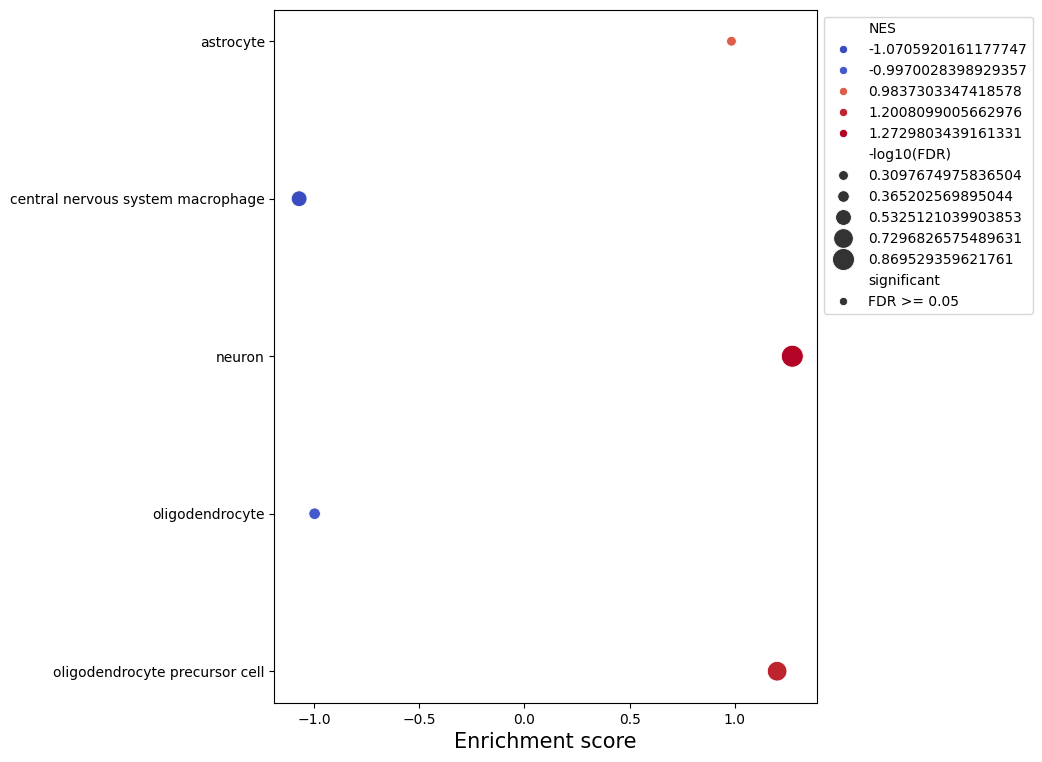

In [23]:
mpl.rcdefaults()
palette = sns.color_palette("coolwarm", as_cmap=True)

enrichment_plot(
    enrich_res=enrich_df,
    x='NES',
    y='celltype',
    size='-log10(FDR)',
    sizes=(50, 250),
    hue='NES',
    palette=palette,
    style='significant',
    markers={'FDR < 0.05': '*', 'FDR >= 0.05': 'o'}
)

### Wilcoxon

Specify DE test

In [24]:
key = 'wilcoxon'

Run enrichment for genesets

In [25]:
enrich_df = enrich_celltypes(celltypes, geneset, adata=adata_pb, key=key, gene_col='names', score_col='scores', method='lfc_product', gsea_kw={'verbose': False})
enrich_df.head(2)

  0%|          | 0/5 [00:00<?, ?it/s]

2024-07-15 16:33:48,666 [WARNING] Duplicated values found in preranked stats: 0.35% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-15 16:33:49,585 [WARNING] Duplicated values found in preranked stats: 0.23% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-15 16:33:50,014 [WARNING] Duplicated values found in preranked stats: 0.69% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


Name                  Term        ES       NES NOM p-val FDR q-val  \
0  prerank  human-specific genes -0.346524 -0.880947  0.684882  0.684882   
0  prerank  human-specific genes -0.425505 -0.972538   0.54567   0.54567   

  FWER p-val  Tag %  Gene %  \
0   0.684882  14/59  14.80%   
0    0.54567  15/59  17.96%   

                                          Lead_genes  \
0  PDE1A;IGSF21;SULF2;GNAI1;NUAK1;SCN3B;ATP1A3;GA...   
0  ASAP2;LHX2;PTPRK;NRXN1;NRXN2;SULF2;PPA1;CHST10...   

                            celltype  
0                          astrocyte  
0  central nervous system macrophage

Process enrichment results

In [26]:
process_enrichment_df(enrich_df)
enrich_df.head(2)

Name                  Term        ES       NES NOM p-val FDR q-val  \
0  prerank  human-specific genes -0.346524 -0.880947  0.684882  0.684882   
0  prerank  human-specific genes -0.425505 -0.972538   0.54567   0.54567   

  FWER p-val  Tag %  Gene %  \
0   0.684882  14/59  14.80%   
0    0.54567  15/59  17.96%   

                                          Lead_genes  \
0  PDE1A;IGSF21;SULF2;GNAI1;NUAK1;SCN3B;ATP1A3;GA...   
0  ASAP2;LHX2;PTPRK;NRXN1;NRXN2;SULF2;PPA1;CHST10...   

                            celltype  -log10(FDR) direction  significant  
0                          astrocyte     0.163751  depleted  FDR >= 0.05  
0  central nervous system macrophage     0.262275  depleted  FDR >= 0.05

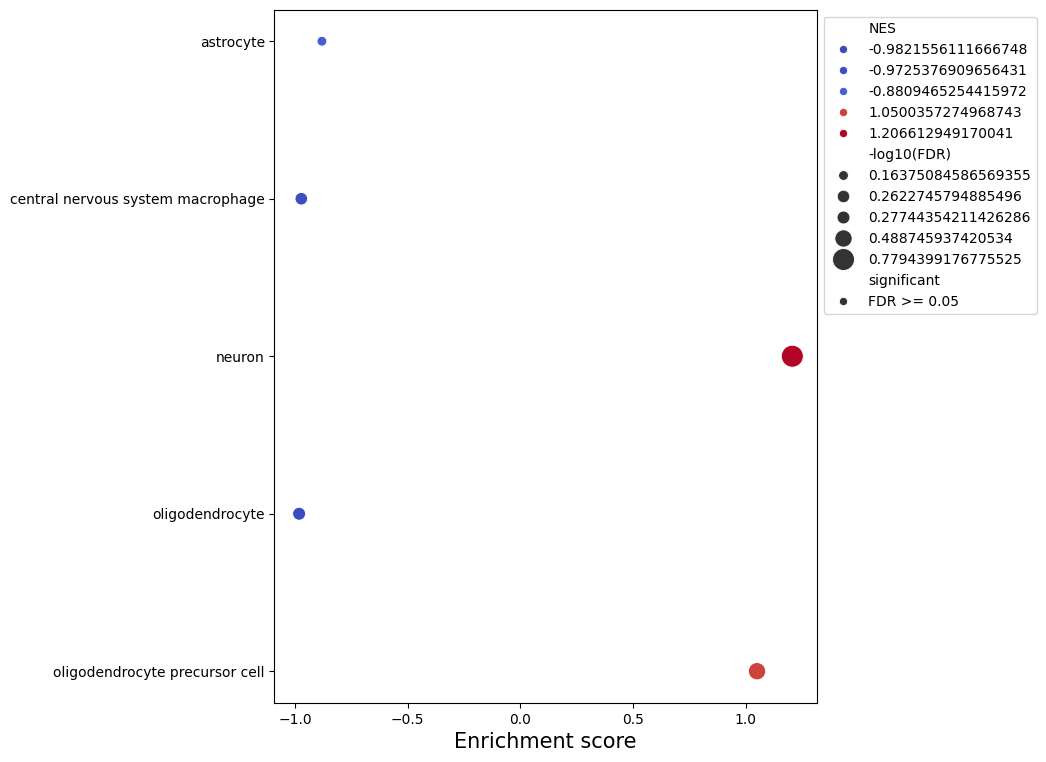

In [27]:
mpl.rcdefaults()
palette = sns.color_palette("coolwarm", as_cmap=True)

enrichment_plot(
    enrich_res=enrich_df,
    x='NES',
    y='celltype',
    size='-log10(FDR)',
    sizes=(50, 250),
    hue='NES',
    palette=palette,
    style='significant',
    markers={'FDR < 0.05': '*', 'FDR >= 0.05': 'o'}
)

### Logreg

Specify DE test

In [28]:
key = 'logreg'

Run enrichment for genesets

In [29]:
enrich_df = enrich_celltypes(celltypes, geneset, adata=adata_pb, key=key, gene_col='names', score_col='scores', method='score', gsea_kw={'verbose': False})
enrich_df.head(2)

  0%|          | 0/5 [00:00<?, ?it/s]

2024-07-15 16:33:52,116 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-15 16:33:52,546 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


Name                  Term        ES       NES NOM p-val FDR q-val  \
0  prerank  human-specific genes  0.384713  1.016506  0.420382  0.420382   
0  prerank  human-specific genes -0.412481 -1.259599  0.095823  0.095823   

  FWER p-val  Tag %  Gene %  \
0      0.264   6/59   3.41%   
0   0.095823  13/59  11.31%   

                                          Lead_genes  \
0                    AMZ2;NRXN1;MACF1;ASAP2;ID2;LHX2   
0  NRXN1;PTPRK;PDE1A;ALCAM;ASAP2;GNAI1;AMZ2;CD47;...   

                            celltype  
0                          astrocyte  
0  central nervous system macrophage

Process enrichment results

In [30]:
process_enrichment_df(enrich_df)
enrich_df.head(2)

Name                  Term        ES       NES NOM p-val FDR q-val  \
0  prerank  human-specific genes  0.384713  1.016506  0.420382  0.420382   
0  prerank  human-specific genes -0.412481 -1.259599  0.095823  0.095823   

  FWER p-val  Tag %  Gene %  \
0      0.264   6/59   3.41%   
0   0.095823  13/59  11.31%   

                                          Lead_genes  \
0                    AMZ2;NRXN1;MACF1;ASAP2;ID2;LHX2   
0  NRXN1;PTPRK;PDE1A;ALCAM;ASAP2;GNAI1;AMZ2;CD47;...   

                            celltype  -log10(FDR) direction  significant  
0                          astrocyte     0.375324  enriched  FDR >= 0.05  
0  central nervous system macrophage     1.014021  depleted  FDR >= 0.05

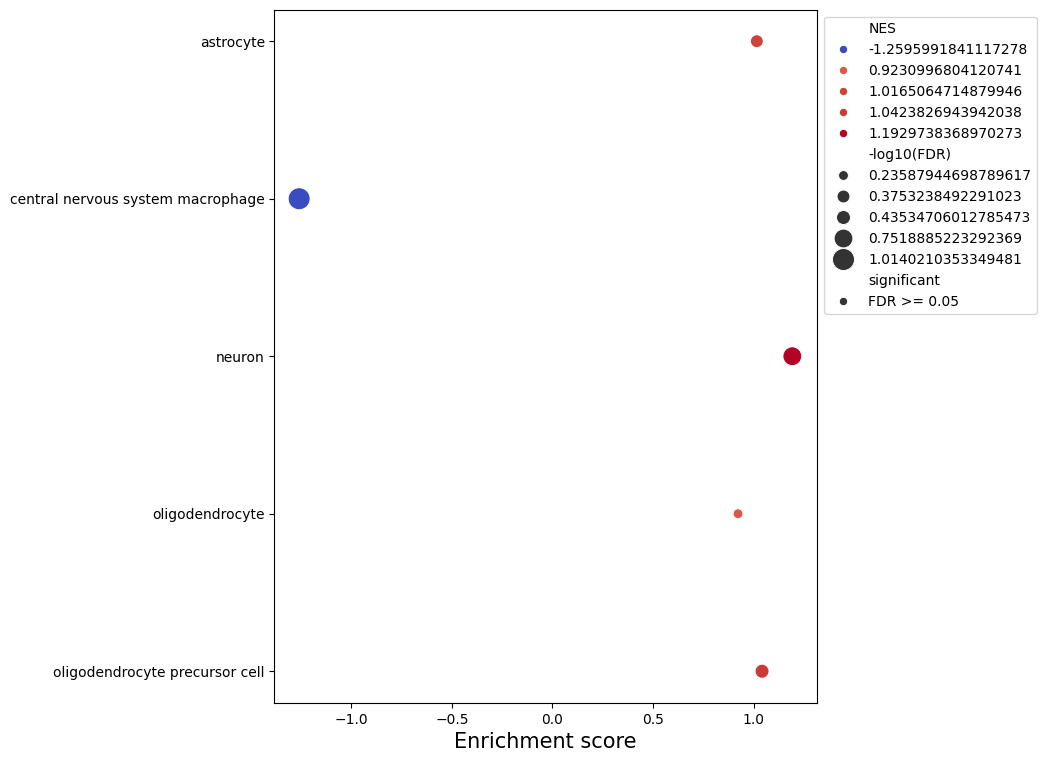

In [31]:
mpl.rcdefaults()
palette = sns.color_palette("coolwarm", as_cmap=True)

enrichment_plot(
    enrich_res=enrich_df,
    x='NES',
    y='celltype',
    size='-log10(FDR)',
    sizes=(50, 250),
    hue='NES',
    palette=palette,
    style='significant',
    markers={'FDR < 0.05': '*', 'FDR >= 0.05': 'o'}
)

### EdgeR

Run enrichment for genesets

In [32]:
res_edgeR['astrocyte']

names     logFC    logCPM             F        PValue  \
0          LRIG1  3.253504  8.243949  6.683279e+03  3.522581e-94   
1          GLUD1  3.141181  8.418112  6.414708e+03  4.395963e-87   
2           MSI2  3.249282  9.166693  5.664322e+03  3.164434e-80   
3         PARD3B  3.269945  8.535038  3.723851e+03  7.701706e-80   
4           LIFR  3.060023  8.416975  4.894451e+03  2.773269e-76   
...          ...       ...       ...           ...           ...   
13890  PABPC1L2A -0.218092  7.616359 -2.126676e-05  1.000000e+00   
13891      CERKL -0.197116  7.620379 -1.823321e-07  1.000000e+00   
13892      HTR1F -0.152406  7.620263 -9.041523e-06  1.000000e+00   
13893       HPGD -0.135412  7.612486 -1.162799e-05  1.000000e+00   
13894    TMEM212 -0.115128  7.609383 -7.412045e-06  1.000000e+00   

                FDR      score  
0      4.894626e-90  81.751325  
1      3.054095e-83  80.091871  
2      1.465661e-76  75.261689  
3      2.675380e-76  61.023366  
4      7.706914e-73  69.960356  
...             ...        ...  
13890  1.000000e+00   0.000000  
13891  1.000000e+00   0.000000  
13892  1.000000e+00   0.000000  
13893  1.000000e+00   0.000000  
13894  1.000000e+00   0.000000  

[13895 rows x 7 columns]

In [33]:
enrich_df = enrich_celltypes(res_edgeR, geneset, gene_col='names', score_col='score', method='score', gsea_kw={'verbose': True})
enrich_df.head(2)

  0%|          | 0/5 [00:00<?, ?it/s]

2024-07-15 16:33:53,271 [WARNING] Duplicated values found in preranked stats: 0.16% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-15 16:33:53,272 [INFO] Parsing data files for GSEA.............................
2024-07-15 16:33:53,275 [INFO] 0000 gene_sets have been filtered out when max_size=1000 and min_size=0
2024-07-15 16:33:53,276 [INFO] 0001 gene_sets used for further statistical testing.....
2024-07-15 16:33:53,276 [INFO] Start to run GSEA...Might take a while..................
2024-07-15 16:33:53,772 [INFO] Congratulations. GSEApy runs successfully................

2024-07-15 16:33:53,786 [WARNING] Duplicated values found in preranked stats: 0.19% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-15 16:33:53,786 [INFO] Parsing data files for GSEA.............................
2024-07-15 16:33:53,786 [INFO] 0000 gene_sets have been filtered out when max_size=1000 and min_size=0
20

Name                  Term        ES       NES NOM p-val FDR q-val  \
0  prerank  human-specific genes   0.45146   1.14468   0.28973   0.28973   
0  prerank  human-specific genes -0.315379 -1.124679  0.209945  0.209945   

  FWER p-val  Tag %  Gene %  \
0      0.268  12/64  15.29%   
0   0.209945  21/64  17.74%   

                                          Lead_genes  \
0  AMZ2;NRXN1;MACF1;LHX2;ASAP2;ID2;SYNGAP1;CHST10...   
0  ALCAM;NRXN1;PTPRK;NRXN2;ASAP2;CD47;PPA1;SYNGAP...   

                            celltype  
0                          astrocyte  
0  central nervous system macrophage

Process enrichment results

In [34]:
process_enrichment_df(enrich_df)
enrich_df.head(2)

Name                  Term        ES       NES NOM p-val FDR q-val  \
0  prerank  human-specific genes   0.45146   1.14468   0.28973   0.28973   
0  prerank  human-specific genes -0.315379 -1.124679  0.209945  0.209945   

  FWER p-val  Tag %  Gene %  \
0      0.268  12/64  15.29%   
0   0.209945  21/64  17.74%   

                                          Lead_genes  \
0  AMZ2;NRXN1;MACF1;LHX2;ASAP2;ID2;SYNGAP1;CHST10...   
0  ALCAM;NRXN1;PTPRK;NRXN2;ASAP2;CD47;PPA1;SYNGAP...   

                            celltype  -log10(FDR) direction  significant  
0                          astrocyte     0.536511  enriched  FDR >= 0.05  
0  central nervous system macrophage     0.675831  depleted  FDR >= 0.05

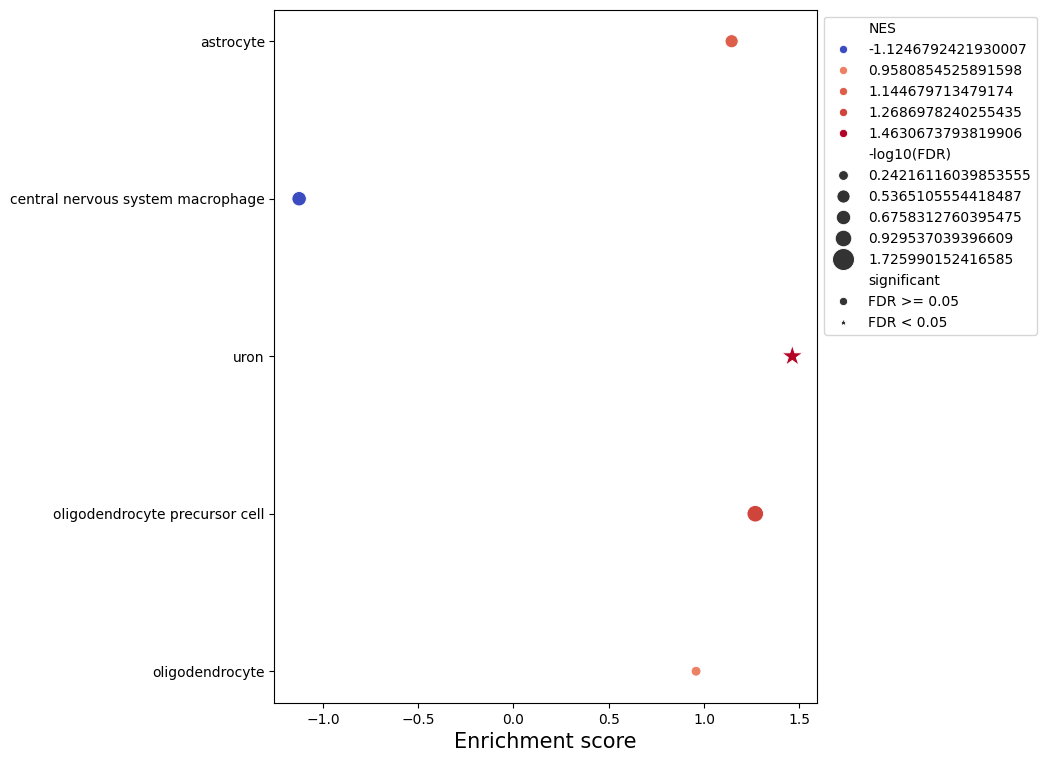

In [35]:
mpl.rcdefaults()
palette = sns.color_palette("coolwarm", as_cmap=True)

enrichment_plot(
    enrich_res=enrich_df,
    x='NES',
    y='celltype',
    size='-log10(FDR)',
    sizes=(50, 250),
    hue='NES',
    palette=palette,
    style='significant',
    markers={'FDR < 0.05': '*', 'FDR >= 0.05': 'o'}
)

### EdgeR (logFC)

Run enrichment for genesets

In [36]:
res_edgeR['astrocyte']

names     logFC    logCPM             F        PValue  \
0          LRIG1  3.253504  8.243949  6.683279e+03  3.522581e-94   
1          GLUD1  3.141181  8.418112  6.414708e+03  4.395963e-87   
2           MSI2  3.249282  9.166693  5.664322e+03  3.164434e-80   
3         PARD3B  3.269945  8.535038  3.723851e+03  7.701706e-80   
4           LIFR  3.060023  8.416975  4.894451e+03  2.773269e-76   
...          ...       ...       ...           ...           ...   
13890  PABPC1L2A -0.218092  7.616359 -2.126676e-05  1.000000e+00   
13891      CERKL -0.197116  7.620379 -1.823321e-07  1.000000e+00   
13892      HTR1F -0.152406  7.620263 -9.041523e-06  1.000000e+00   
13893       HPGD -0.135412  7.612486 -1.162799e-05  1.000000e+00   
13894    TMEM212 -0.115128  7.609383 -7.412045e-06  1.000000e+00   

                FDR      score  
0      4.894626e-90  81.751325  
1      3.054095e-83  80.091871  
2      1.465661e-76  75.261689  
3      2.675380e-76  61.023366  
4      7.706914e-73  69.960356  
...             ...        ...  
13890  1.000000e+00   0.000000  
13891  1.000000e+00   0.000000  
13892  1.000000e+00   0.000000  
13893  1.000000e+00   0.000000  
13894  1.000000e+00   0.000000  

[13895 rows x 7 columns]

In [37]:
enrich_df = enrich_celltypes(res_edgeR, geneset, gene_col='names', score_col='logFC', method='score', gsea_kw={'verbose': True})
enrich_df.head(2)

  0%|          | 0/5 [00:00<?, ?it/s]

2024-07-15 16:33:56,196 [INFO] Parsing data files for GSEA.............................
2024-07-15 16:33:56,205 [INFO] 0000 gene_sets have been filtered out when max_size=1000 and min_size=0
2024-07-15 16:33:56,206 [INFO] 0001 gene_sets used for further statistical testing.....
2024-07-15 16:33:56,207 [INFO] Start to run GSEA...Might take a while..................
2024-07-15 16:33:56,738 [INFO] Congratulations. GSEApy runs successfully................

2024-07-15 16:33:56,754 [INFO] Parsing data files for GSEA.............................
2024-07-15 16:33:56,754 [INFO] 0000 gene_sets have been filtered out when max_size=1000 and min_size=0
2024-07-15 16:33:56,754 [INFO] 0001 gene_sets used for further statistical testing.....
2024-07-15 16:33:56,754 [INFO] Start to run GSEA...Might take a while..................
2024-07-15 16:33:57,293 [INFO] Congratulations. GSEApy runs successfully................

2024-07-15 16:33:57,308 [INFO] Parsing data files for GSEA............................

Name                  Term        ES       NES NOM p-val FDR q-val  \
0  prerank  human-specific genes  0.319176  0.937885  0.559033  0.559033   
0  prerank  human-specific genes   -0.4267 -1.355213  0.045997  0.045997   

  FWER p-val  Tag %  Gene %  \
0      0.393   9/64   9.24%   
0   0.045997  22/64  19.96%   

                                          Lead_genes  \
0  AMZ2;NRXN1;ID2;LHX2;ASAP2;MACF1;CHST10;KIF21B;...   
0  NRXN1;PTPRK;ASAP2;ALCAM;PDE1A;NRXN2;SULF2;GNAI...   

                            celltype  
0                          astrocyte  
0  central nervous system macrophage

Process enrichment results

In [38]:
process_enrichment_df(enrich_df)
enrich_df.head(2)

Name                  Term        ES       NES NOM p-val FDR q-val  \
0  prerank  human-specific genes  0.319176  0.937885  0.559033  0.559033   
0  prerank  human-specific genes   -0.4267 -1.355213  0.045997  0.045997   

  FWER p-val  Tag %  Gene %  \
0      0.393   9/64   9.24%   
0   0.045997  22/64  19.96%   

                                          Lead_genes  \
0  AMZ2;NRXN1;ID2;LHX2;ASAP2;MACF1;CHST10;KIF21B;...   
0  NRXN1;PTPRK;ASAP2;ALCAM;PDE1A;NRXN2;SULF2;GNAI...   

                            celltype  -log10(FDR) direction  significant  
0                          astrocyte     0.251787  enriched  FDR >= 0.05  
0  central nervous system macrophage     1.327934  depleted   FDR < 0.05

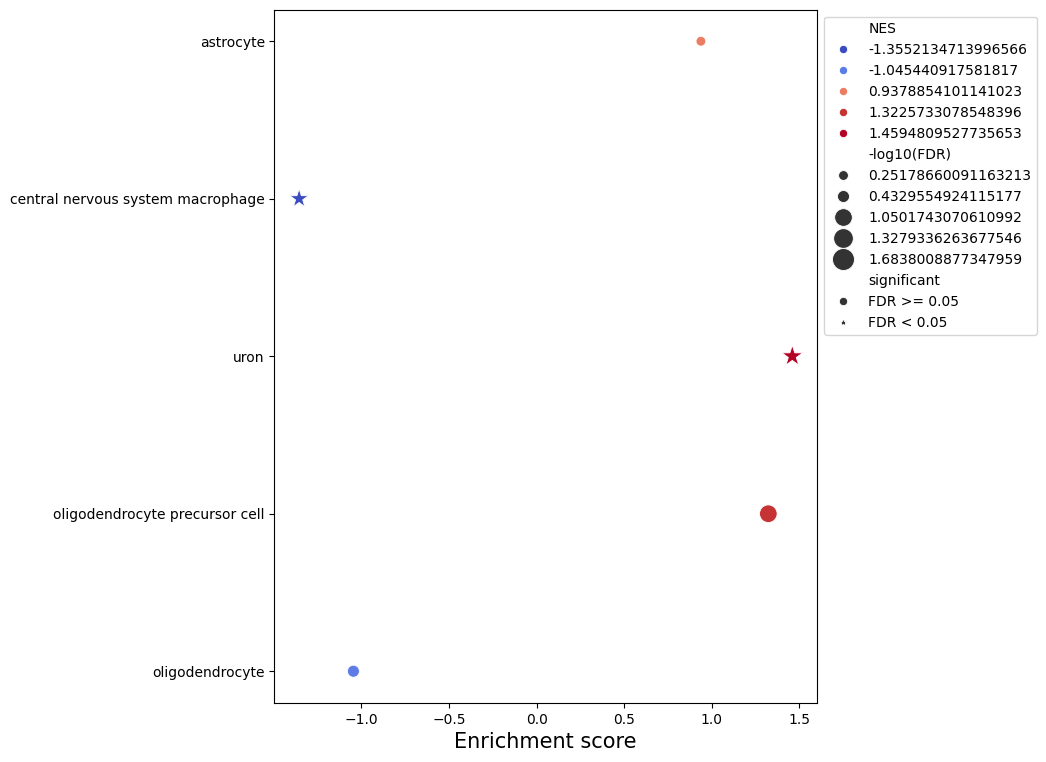

In [39]:
mpl.rcdefaults()
palette = sns.color_palette("coolwarm", as_cmap=True)

enrichment_plot(
    enrich_res=enrich_df,
    x='NES',
    y='celltype',
    size='-log10(FDR)',
    sizes=(50, 250),
    hue='NES',
    palette=palette,
    style='significant',
    markers={'FDR < 0.05': '*', 'FDR >= 0.05': 'o'}
)

### Gene visualization

Calculate average normalized expression

In [40]:
genes = scaled_adata.var_names.intersection(human_specific_genes)
scaled_adata.obs[f'All HS genes'] = scaled_adata[:, genes].X.mean(axis=1)
scaled_adata.obs.head()

roi organism_ontology_term_id  \
CellID                                                           
10X227_5:AACGGGATCCGCTGTT  Human A24            NCBITaxon:9606   
10X227_5:ATCATTCAGGCTTAGG  Human A24            NCBITaxon:9606   
10X227_5:ACATCCCGTAGGAAAG  Human A24            NCBITaxon:9606   
10X227_5:CCATAAGTCCTGGCTT  Human A24            NCBITaxon:9606   
10X227_5:ATTCTTGGTACCAATC  Human A24            NCBITaxon:9606   

                          disease_ontology_term_id  \
CellID                                               
10X227_5:AACGGGATCCGCTGTT             PATO:0000461   
10X227_5:ATCATTCAGGCTTAGG             PATO:0000461   
10X227_5:ACATCCCGTAGGAAAG             PATO:0000461   
10X227_5:CCATAAGTCCTGGCTT             PATO:0000461   
10X227_5:ATTCTTGGTACCAATC             PATO:0000461   

                          self_reported_ethnicity_ontology_term_id  \
CellID                                                               
10X227_5:AACGGGATCCGCTGTT                           HANCESTRO:0005   
10X227_5:ATCATTCAGGCTTAGG                           HANCESTRO:0005   
10X227_5:ACATCCCGTAGGAAAG                           HANCESTRO:0005   
10X227_5:CCATAAGTCCTGGCTT                           HANCESTRO:0005   
10X227_5:ATTCTTGGTACCAATC                           HANCESTRO:0005   

                          assay_ontology_term_id sex_ontology_term_id  \
CellID                                                                  
10X227_5:AACGGGATCCGCTGTT            EFO:0009922         PATO:0000384   
10X227_5:ATCATTCAGGCTTAGG            EFO:0009922         PATO:0000384   
10X227_5:ACATCCCGTAGGAAAG            EFO:0009922         PATO:0000384   
10X227_5:CCATAAGTCCTGGCTT            EFO:0009922         PATO:0000384   
10X227_5:ATTCTTGGTACCAATC            EFO:0009922         PATO:0000384   

                          development_stage_ontology_term_id    donor_id  \
CellID                                                                     
10X227_5:AACGGGATCCGCTGTT                     HsapDv:0000144  H18.30.002   
10X227_5:ATCATTCAGGCTTAGG                     HsapDv:0000144  H18.30.002   
10X227_5:ACATCCCGTAGGAAAG                     HsapDv:0000144  H18.30.002   
10X227_5:CCATAAGTCCTGGCTT                     HsapDv:0000144  H18.30.002   
10X227_5:ATTCTTGGTACCAATC                     HsapDv:0000144  H18.30.002   

                          suspension_type  \
CellID                                      
10X227_5:AACGGGATCCGCTGTT         nucleus   
10X227_5:ATCATTCAGGCTTAGG         nucleus   
10X227_5:ACATCCCGTAGGAAAG         nucleus   
10X227_5:CCATAAGTCCTGGCTT         nucleus   
10X227_5:ATTCTTGGTACCAATC         nucleus   

                                                                  dissection  \
CellID                                                                         
10X227_5:AACGGGATCCGCTGTT  Cerebral cortex (Cx) - Cingulate gyrus, rostra...   
10X227_5:ATCATTCAGGCTTAGG  Cerebral cortex (Cx) - Cingulate gyrus, rostra...   
10X227_5:ACATCCCGTAGGAAAG  Cerebral cortex (Cx) - Cingulate gyrus, rostra...   
10X227_5:CCATAAGTCCTGGCTT  Cerebral cortex (Cx) - Cingulate gyrus, rostra...   
10X227_5:ATTCTTGGTACCAATC  Cerebral cortex (Cx) - Cingulate gyrus, rostra...   

                           ...        cell_type      assay  disease  \
CellID                     ...                                        
10X227_5:AACGGGATCCGCTGTT  ...  oligodendrocyte  10x 3' v3   normal   
10X227_5:ATCATTCAGGCTTAGG  ...  oligodendrocyte  10x 3' v3   normal   
10X227_5:ACATCCCGTAGGAAAG  ...  oligodendrocyte  10x 3' v3   normal   
10X227_5:CCATAAGTCCTGGCTT  ...  oligodendrocyte  10x 3' v3   normal   
10X227_5:ATTCTTGGTACCAATC  ...  oligodendrocyte  10x 3' v3   normal   

                               organism   sex           tissue  \
CellID                                                           
10X227_5:AACGGGATCCGCTGTT  Homo sapiens  male  cerebral cortex   
10X227_5:ATCATTCAGGCTTAGG  Homo sapiens  male  cerebral cortex   
10X227_5:ACATCCC

Vusualize

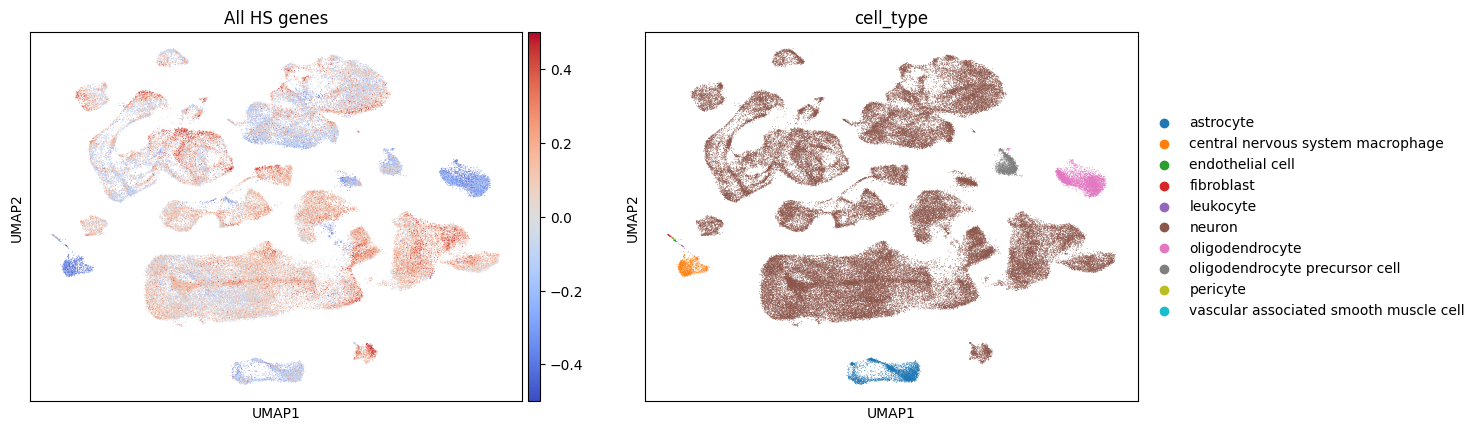

In [41]:
cmap = mpl.cm.coolwarm
norm = mpl.colors.TwoSlopeNorm(vcenter=0, vmax=0.5, vmin=-0.5)

sc.pl.umap(scaled_adata, color=['All HS genes', 'cell_type'], cmap=cmap, norm=norm)

## Enrich for HS/AS groups

Create geneset dict

In [42]:
gene_sets = dict()
for label in hs_groups.label.unique():
  gene_sets[label] = hs_groups[hs_groups.label == label].index.to_list()

### T-test

Specify DE test

In [43]:
key = 't-test'

Run enrichment for genesets

In [44]:
enrich_df = enrich_celltypes(celltypes, gene_sets, adata=adata_pb, key=key, gene_col='names', score_col='scores', method='score', gsea_kw={'verbose': False})
enrich_df.head(2)

  0%|          | 0/5 [00:00<?, ?it/s]

2024-07-15 16:34:01,190 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-15 16:34:01,726 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-15 16:34:02,264 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-15 16:34:02,797 [WARNING] Duplicated values found in preranked stats: 0.03% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


Name                Term        ES       NES NOM p-val FDR q-val  \
0  prerank  maybe age-specific  0.462344  1.158952  0.293403  0.585621   
1  prerank      human-specific  0.564409  1.121075  0.362573   0.32854   

  FWER p-val Tag % Gene %      Lead_genes   celltype  
0      0.531  3/16  4.29%  MACF1;LHX2;ID2  astrocyte  
1      0.575   1/6  1.42%            AMZ2  astrocyte

Process enrichment results

In [45]:
process_enrichment_df(enrich_df)
enrich_df.head(2)

Name                Term        ES       NES NOM p-val FDR q-val  \
0  prerank  maybe age-specific  0.462344  1.158952  0.293403  0.585621   
1  prerank      human-specific  0.564409  1.121075  0.362573   0.32854   

  FWER p-val Tag % Gene %      Lead_genes   celltype  -log10(FDR) direction  \
0      0.531  3/16  4.29%  MACF1;LHX2;ID2  astrocyte     0.231642  enriched   
1      0.575   1/6  1.42%            AMZ2  astrocyte     0.482091  enriched   

   significant  
0  FDR >= 0.05  
1  FDR >= 0.05

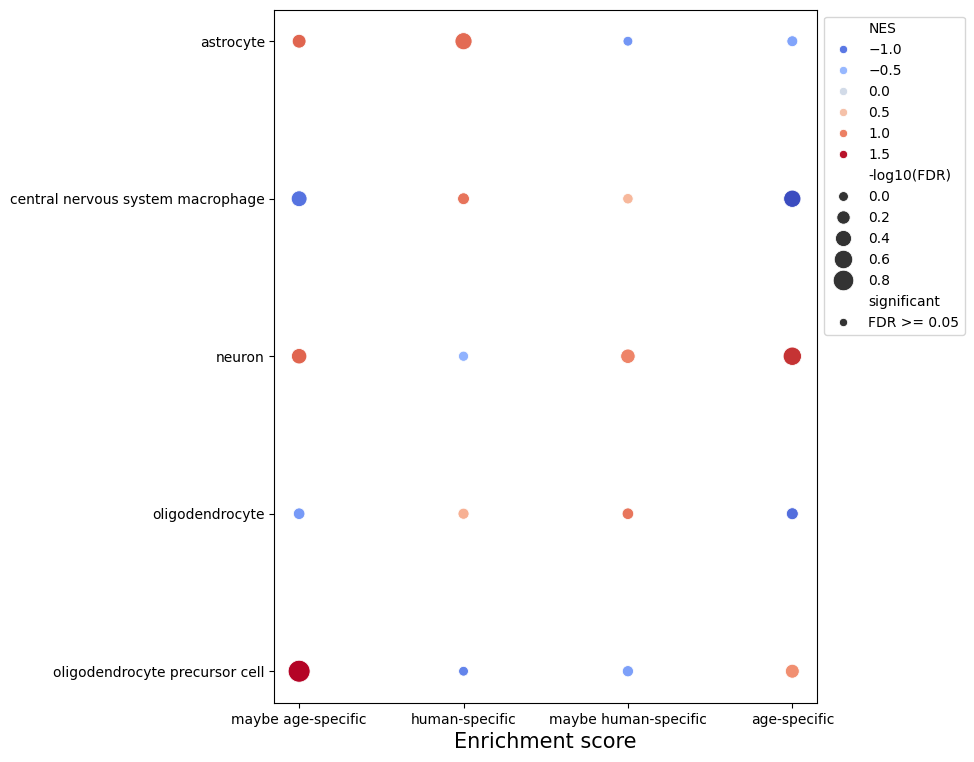

In [46]:
mpl.rcdefaults()
palette = sns.color_palette("coolwarm", as_cmap=True)

enrichment_plot(
    enrich_res=enrich_df,
    x='Term',
    y='celltype',
    size='-log10(FDR)',
    sizes=(50, 250),
    hue='NES',
    palette=palette,
    style='significant',
    markers={'FDR < 0.05': '*', 'FDR >= 0.05': 'o'}
)

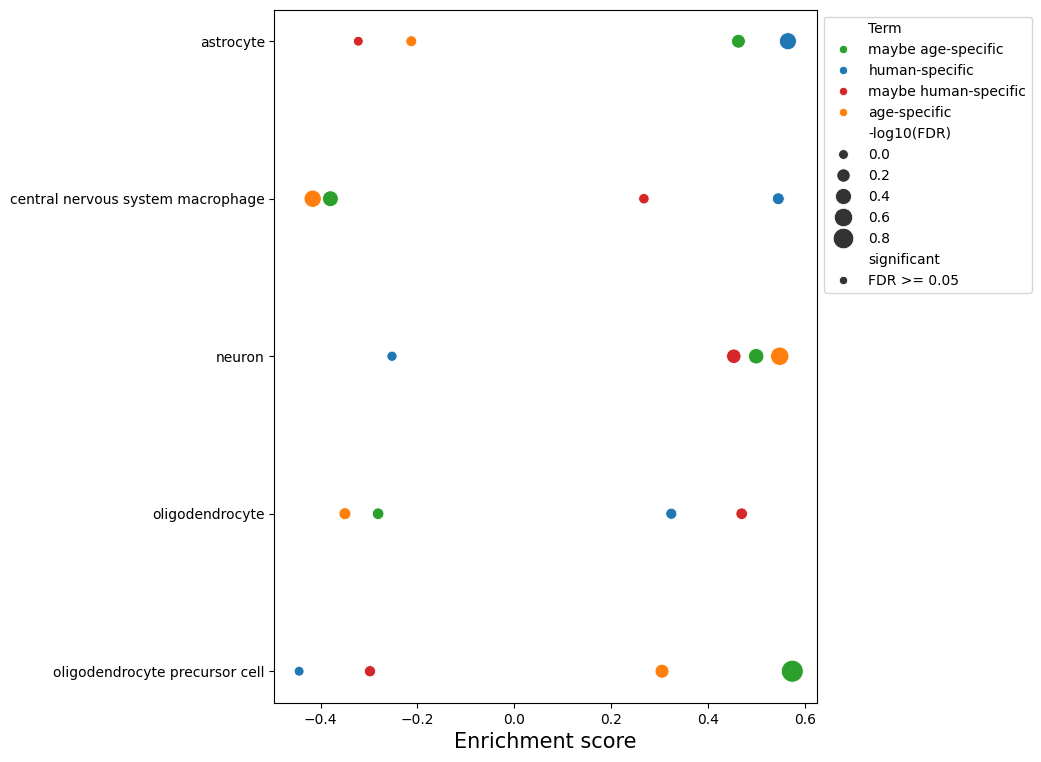

In [47]:
mpl.rcdefaults()
palette = {'human-specific': 'tab:blue', 'age-specific': 'tab:orange', 'maybe human-specific': 'tab:red', 'maybe age-specific': 'tab:green'}

enrichment_plot(
    enrich_res=enrich_df,
    x='ES',
    y='celltype',
    size='-log10(FDR)',
    sizes=(50, 250),
    hue='Term',
    palette=palette,
    style='significant',
    markers={'FDR < 0.05': '*', 'FDR >= 0.05': 'o'}
)

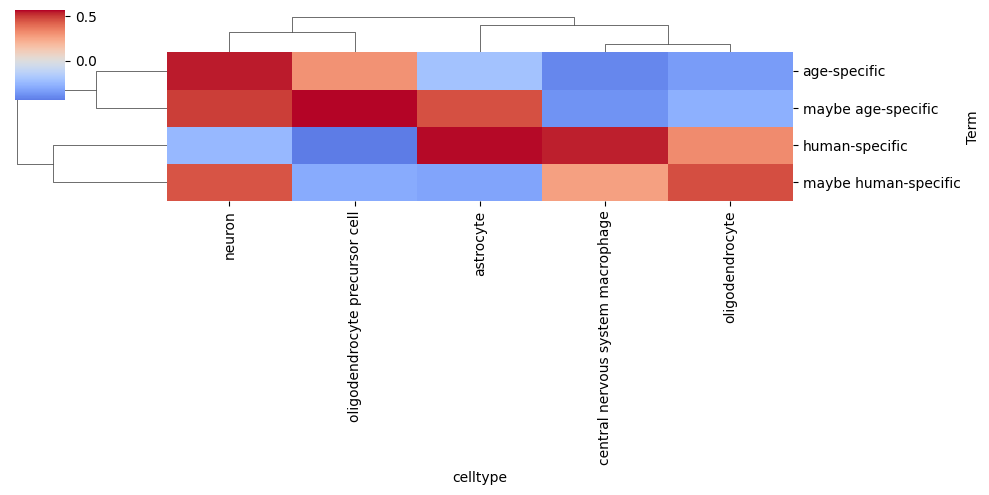

In [48]:
import seaborn as sns
es_df = enrich_df.pivot(index='Term', columns='celltype', values='ES')
sns.clustermap(es_df.astype(float), figsize=(10, 5), cmap='coolwarm', center=0)

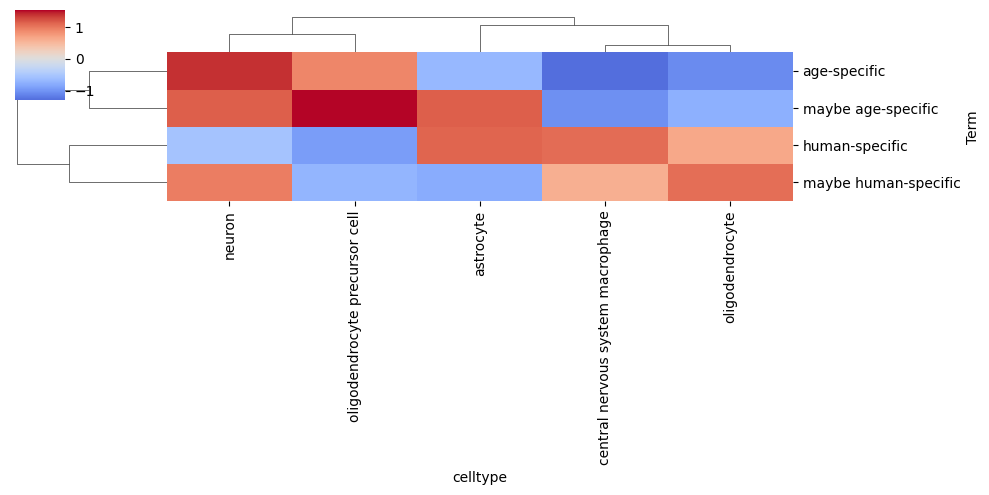

In [49]:
es_df = enrich_df.pivot(index='Term', columns='celltype', values='NES')
sns.clustermap(es_df.astype(float), figsize=(10, 5), cmap='coolwarm', center=0)

<Axes: xlabel='Term', ylabel='celltype'>

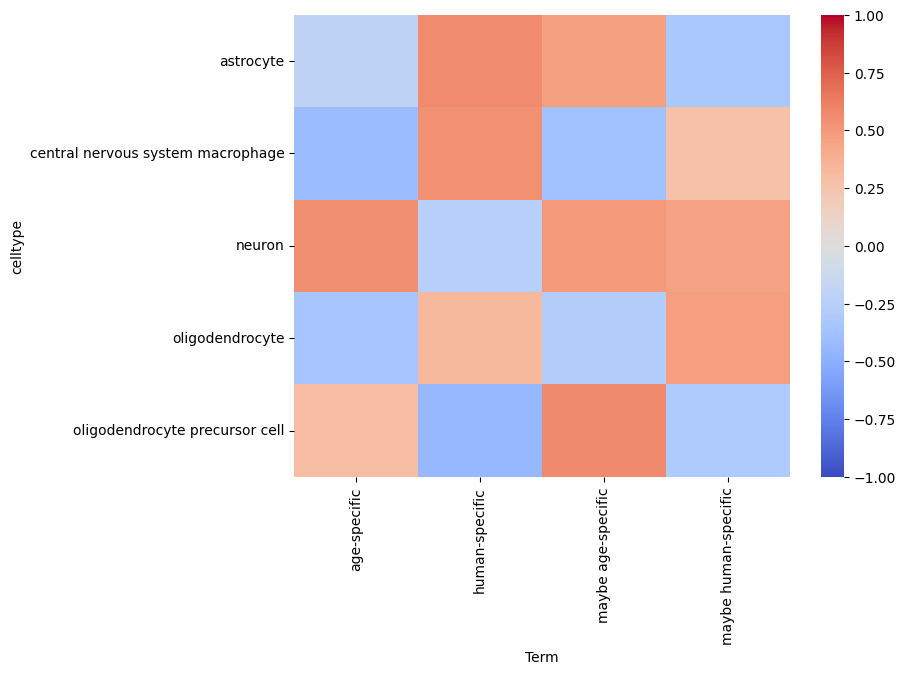

In [50]:
import seaborn as sns
fig = plt.figure(figsize=(8, 6))
es_df = enrich_df.pivot(index='Term', columns='celltype', values='ES')
sns.heatmap(es_df.astype(float).T, cmap='coolwarm', center=0, vmin=-1, vmax=1)

### Wilcoxon

Specify DE test

In [51]:
key = 'wilcoxon'

Run enrichment for genesets

In [52]:
enrich_df = enrich_celltypes(celltypes, gene_sets, adata=adata_pb, key=key, gene_col='names', score_col='scores', method='lfc_product', gsea_kw={'verbose': False})
enrich_df.head(2)

  0%|          | 0/5 [00:00<?, ?it/s]

2024-07-15 16:34:04,887 [WARNING] Duplicated values found in preranked stats: 0.35% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-15 16:34:05,876 [WARNING] Duplicated values found in preranked stats: 0.23% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-15 16:34:06,440 [WARNING] Duplicated values found in preranked stats: 0.69% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


Name            Term        ES       NES NOM p-val FDR q-val FWER p-val  \
0  prerank  human-specific  0.759424  1.245601  0.216216  0.199214      0.303   
1  prerank    age-specific -0.422006 -0.927621  0.548673       1.0   0.828601   

  Tag % Gene %               Lead_genes   celltype  
0   1/6  1.22%                     AMZ2  astrocyte  
1  4/25  8.71%  PDE1A;GNAI1;ATP1A3;GAD1  astrocyte

Process enrichment results

In [53]:
process_enrichment_df(enrich_df)
enrich_df.head(2)

Name            Term        ES       NES NOM p-val FDR q-val FWER p-val  \
0  prerank  human-specific  0.759424  1.245601  0.216216  0.199214      0.303   
1  prerank    age-specific -0.422006 -0.927621  0.548673       1.0   0.828601   

  Tag % Gene %               Lead_genes   celltype  -log10(FDR) direction  \
0   1/6  1.22%                     AMZ2  astrocyte     0.698505  enriched   
1  4/25  8.71%  PDE1A;GNAI1;ATP1A3;GAD1  astrocyte    -0.000434  depleted   

   significant  
0  FDR >= 0.05  
1  FDR >= 0.05

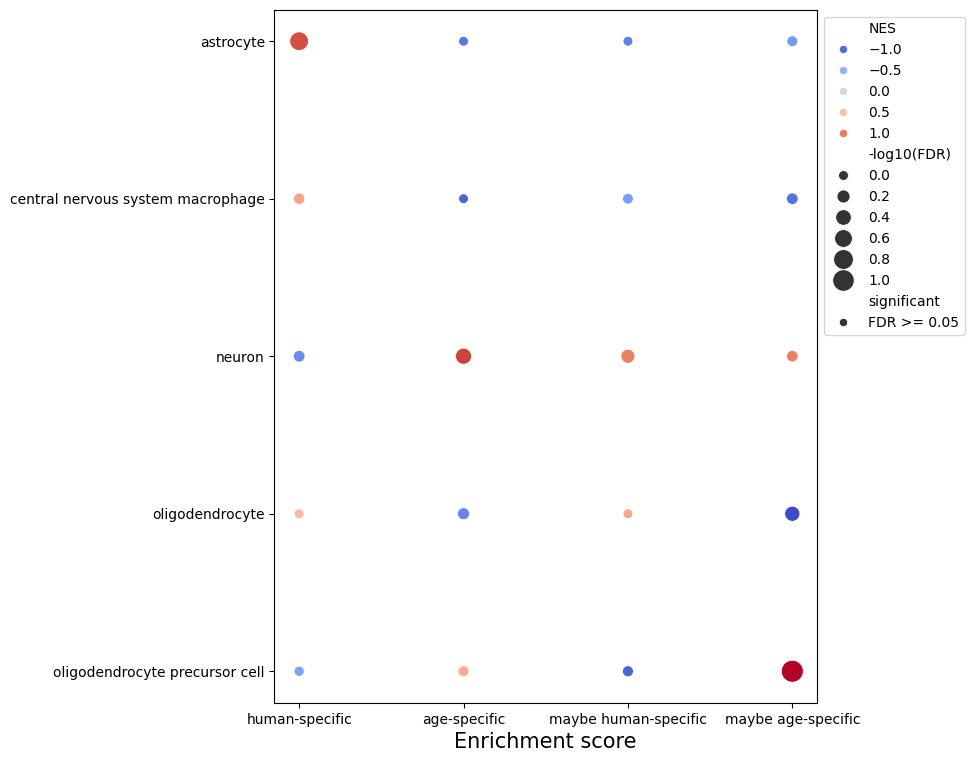

In [54]:
mpl.rcdefaults()
palette = sns.color_palette("coolwarm", as_cmap=True)

enrichment_plot(
    enrich_res=enrich_df,
    x='Term',
    y='celltype',
    size='-log10(FDR)',
    sizes=(50, 250),
    hue='NES',
    palette=palette,
    style='significant',
    markers={'FDR < 0.05': '*', 'FDR >= 0.05': 'o'}
)

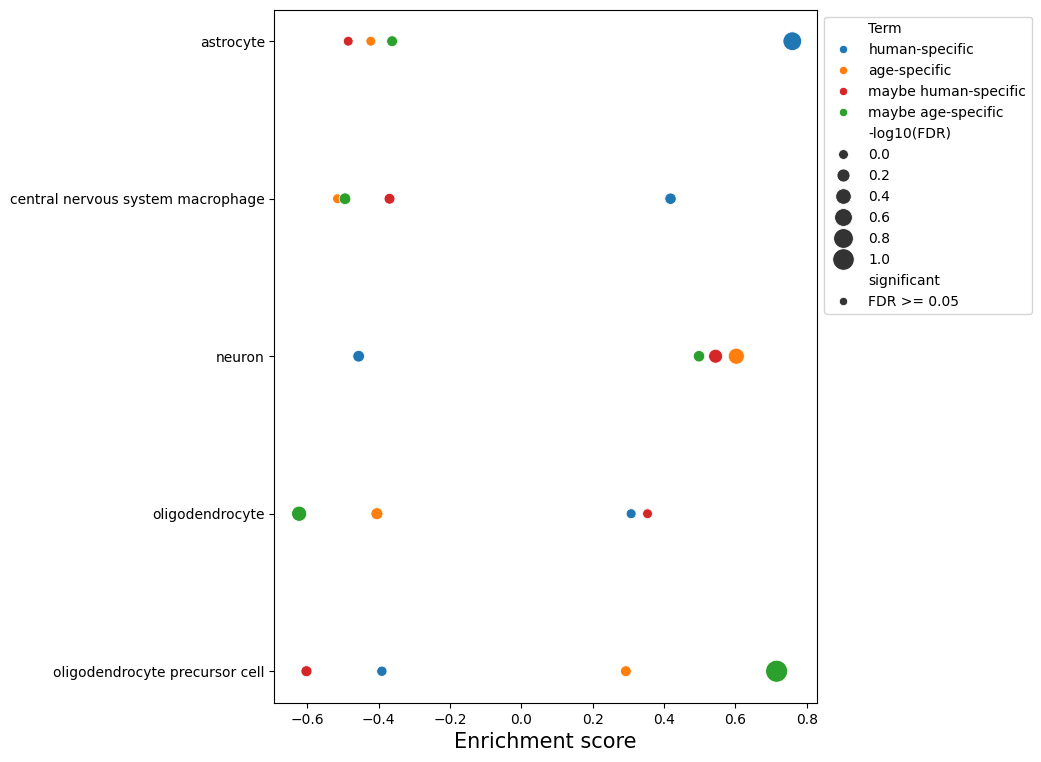

In [55]:
mpl.rcdefaults()
palette = {'human-specific': 'tab:blue', 'age-specific': 'tab:orange', 'maybe human-specific': 'tab:red', 'maybe age-specific': 'tab:green'}

enrichment_plot(
    enrich_res=enrich_df,
    x='ES',
    y='celltype',
    size='-log10(FDR)',
    sizes=(50, 250),
    hue='Term',
    palette=palette,
    style='significant',
    markers={'FDR < 0.05': '*', 'FDR >= 0.05': 'o'}
)

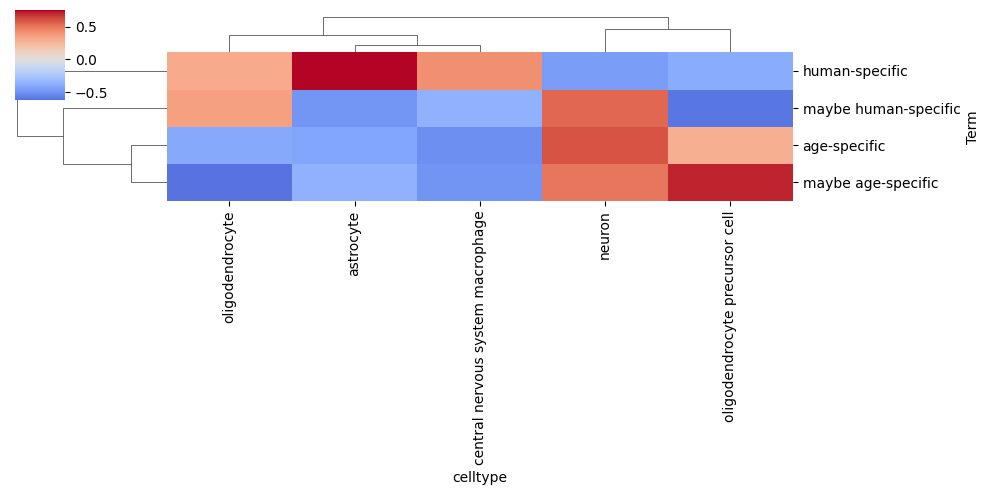

In [56]:
import seaborn as sns
es_df = enrich_df.pivot(index='Term', columns='celltype', values='ES')
sns.clustermap(es_df.astype(float), figsize=(10, 5), cmap='coolwarm', center=0)

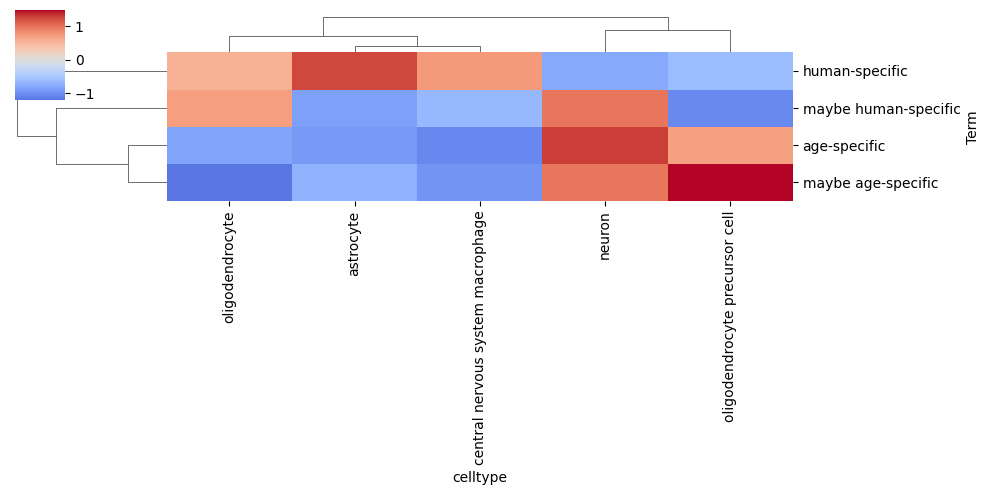

In [57]:
es_df = enrich_df.pivot(index='Term', columns='celltype', values='NES')
sns.clustermap(es_df.astype(float), figsize=(10, 5), cmap='coolwarm', center=0)

<Axes: xlabel='Term', ylabel='celltype'>

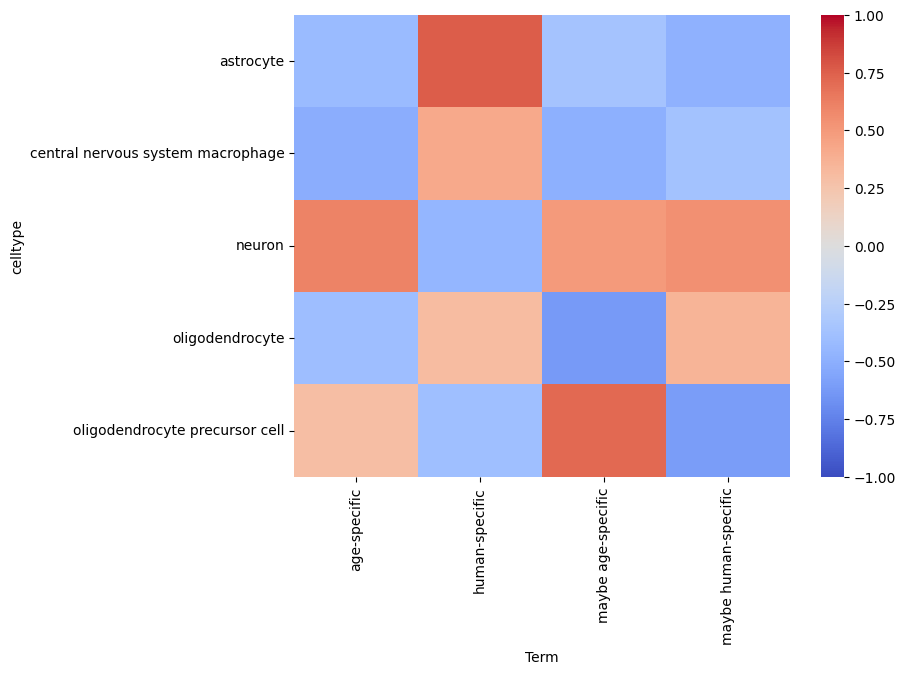

In [58]:
import seaborn as sns
fig = plt.figure(figsize=(8, 6))
es_df = enrich_df.pivot(index='Term', columns='celltype', values='ES')
sns.heatmap(es_df.astype(float).T, cmap='coolwarm', center=0, vmin=-1, vmax=1)

### Logreg

Specify DE test

In [59]:
key = 'logreg'

Run enrichment for genesets

In [60]:
enrich_df = enrich_celltypes(celltypes, gene_sets, adata=adata_pb, key=key, gene_col='names', score_col='scores', method='score', gsea_kw={'verbose': False})
enrich_df.head(2)

  0%|          | 0/5 [00:00<?, ?it/s]

2024-07-15 16:34:09,447 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-15 16:34:09,900 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


Name                  Term        ES       NES NOM p-val FDR q-val  \
0  prerank        human-specific  0.820965  1.431534   0.08125  0.134011   
1  prerank  maybe human-specific -0.479069 -0.968504  0.502155       1.0   

  FWER p-val Tag %  Gene %         Lead_genes   celltype  
0      0.137   1/6   0.44%               AMZ2  astrocyte  
1   0.718478  3/10  12.13%  NUAK1;ALCAM;SCN3B  astrocyte

Process enrichment results

In [61]:
process_enrichment_df(enrich_df)
enrich_df.head(2)

Name                  Term        ES       NES NOM p-val FDR q-val  \
0  prerank        human-specific  0.820965  1.431534   0.08125  0.134011   
1  prerank  maybe human-specific -0.479069 -0.968504  0.502155       1.0   

  FWER p-val Tag %  Gene %         Lead_genes   celltype  -log10(FDR)  \
0      0.137   1/6   0.44%               AMZ2  astrocyte     0.869631   
1   0.718478  3/10  12.13%  NUAK1;ALCAM;SCN3B  astrocyte    -0.000434   

  direction  significant  
0  enriched  FDR >= 0.05  
1  depleted  FDR >= 0.05

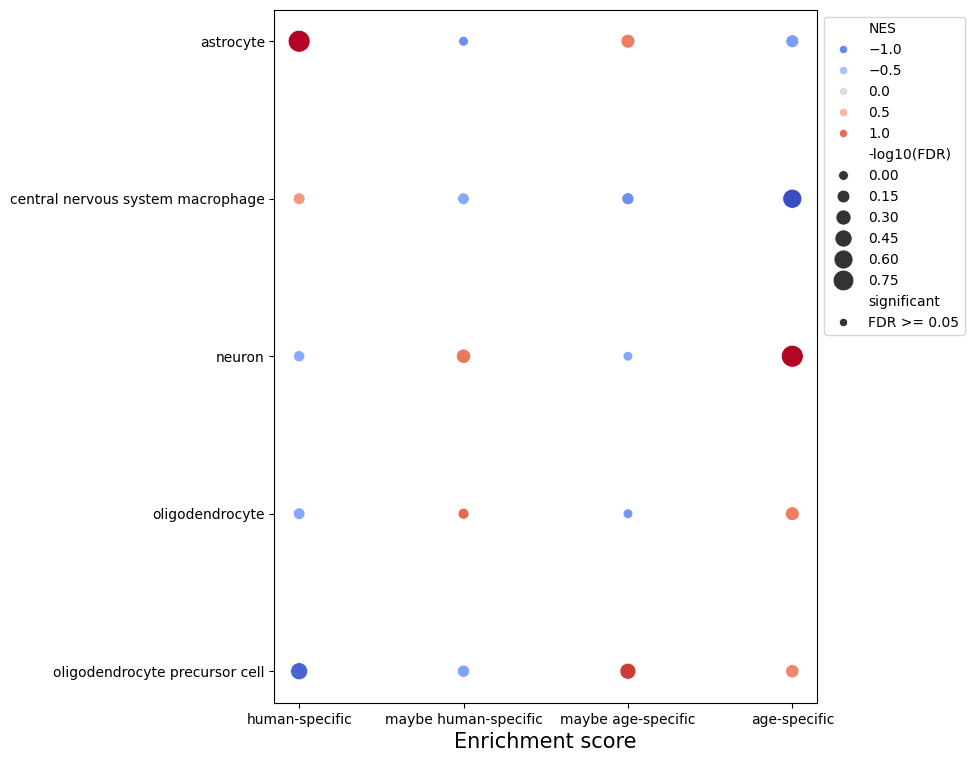

In [62]:
mpl.rcdefaults()
palette = sns.color_palette("coolwarm", as_cmap=True)

enrichment_plot(
    enrich_res=enrich_df,
    x='Term',
    y='celltype',
    size='-log10(FDR)',
    sizes=(50, 250),
    hue='NES',
    palette=palette,
    style='significant',
    markers={'FDR < 0.05': '*', 'FDR >= 0.05': 'o'}
)

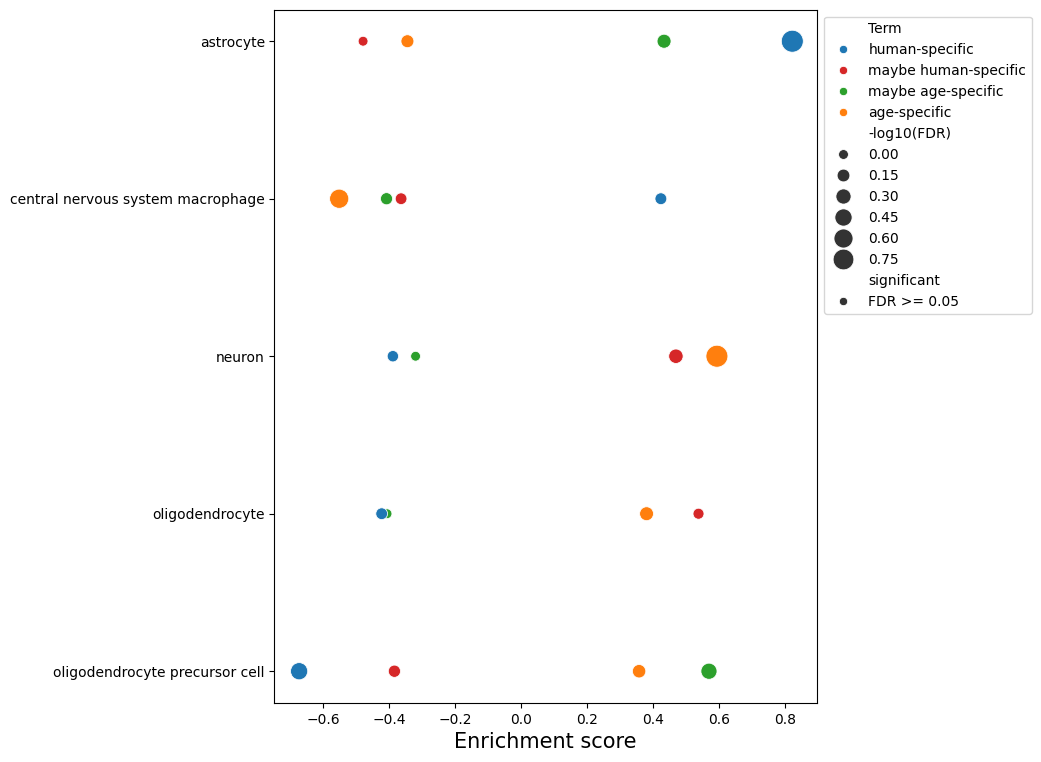

In [63]:
mpl.rcdefaults()
palette = {'human-specific': 'tab:blue', 'age-specific': 'tab:orange', 'maybe human-specific': 'tab:red', 'maybe age-specific': 'tab:green'}

enrichment_plot(
    enrich_res=enrich_df,
    x='ES',
    y='celltype',
    size='-log10(FDR)',
    sizes=(50, 250),
    hue='Term',
    palette=palette,
    style='significant',
    markers={'FDR < 0.05': '*', 'FDR >= 0.05': 'o'}
)

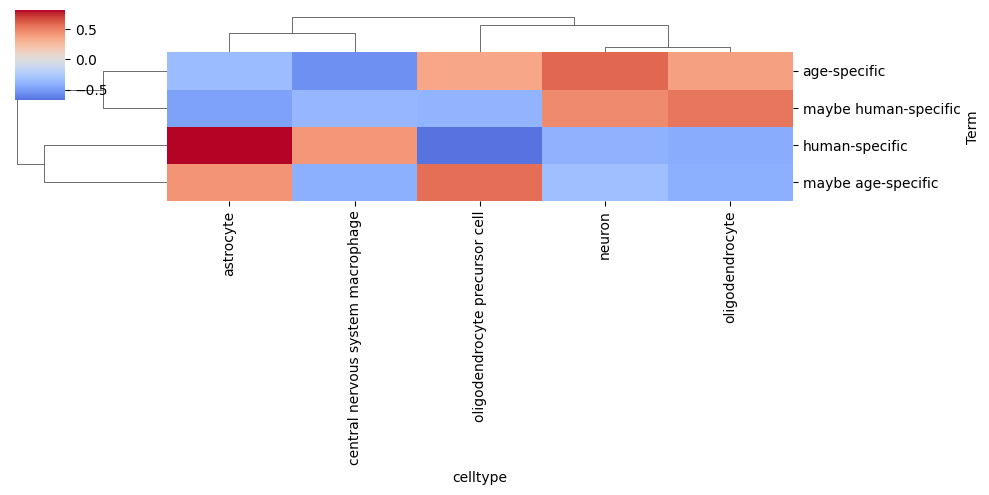

In [64]:
import seaborn as sns
es_df = enrich_df.pivot(index='Term', columns='celltype', values='ES')
sns.clustermap(es_df.astype(float), figsize=(10, 5), cmap='coolwarm', center=0)

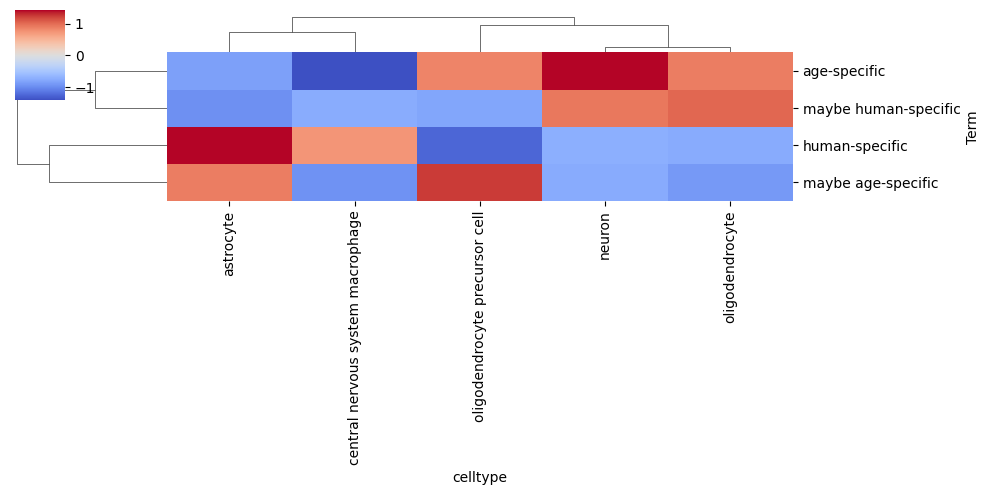

In [65]:
es_df = enrich_df.pivot(index='Term', columns='celltype', values='NES')
sns.clustermap(es_df.astype(float), figsize=(10, 5), cmap='coolwarm', center=0)

<Axes: xlabel='Term', ylabel='celltype'>

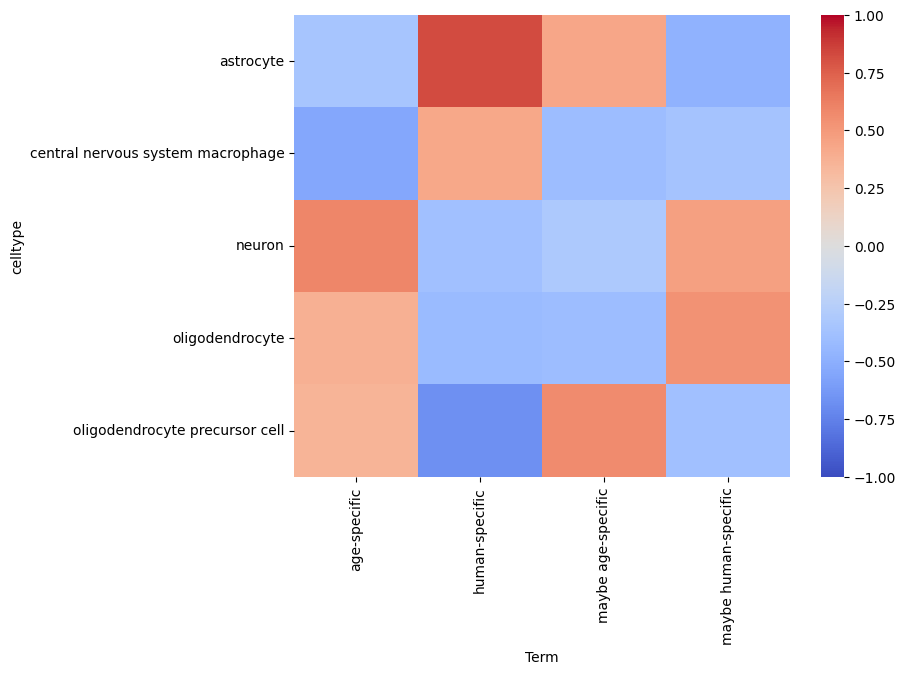

In [66]:
import seaborn as sns
fig = plt.figure(figsize=(8, 6))
es_df = enrich_df.pivot(index='Term', columns='celltype', values='ES')
sns.heatmap(es_df.astype(float).T, cmap='coolwarm', center=0, vmin=-1, vmax=1)

### EdgeR

Run enrichment for genesets

In [67]:
enrich_df = enrich_celltypes(res_edgeR, gene_sets, gene_col='names', score_col='score', method='score', gsea_kw={'verbose': True})
enrich_df.head(2)

  0%|          | 0/5 [00:00<?, ?it/s]

2024-07-15 16:34:11,607 [WARNING] Duplicated values found in preranked stats: 0.16% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-15 16:34:11,607 [INFO] Parsing data files for GSEA.............................
2024-07-15 16:34:11,607 [INFO] 0000 gene_sets have been filtered out when max_size=1000 and min_size=0
2024-07-15 16:34:11,607 [INFO] 0004 gene_sets used for further statistical testing.....
2024-07-15 16:34:11,614 [INFO] Start to run GSEA...Might take a while..................
2024-07-15 16:34:12,237 [INFO] Congratulations. GSEApy runs successfully................

2024-07-15 16:34:12,237 [WARNING] Duplicated values found in preranked stats: 0.19% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-15 16:34:12,253 [INFO] Parsing data files for GSEA.............................
2024-07-15 16:34:12,253 [INFO] 0000 gene_sets have been filtered out when max_size=1000 and min_size=0
20

Name                Term        ES       NES NOM p-val FDR q-val  \
0  prerank  maybe age-specific  0.598416  1.253225  0.197333  0.825701   
1  prerank      human-specific  0.628446  1.182189  0.266566  0.548189   

  FWER p-val Tag % Gene %      Lead_genes   celltype  
0      0.473  3/16  3.77%  MACF1;LHX2;ID2  astrocyte  
1      0.586   1/9  1.19%            AMZ2  astrocyte

Process enrichment results

In [68]:
process_enrichment_df(enrich_df)
enrich_df.head(2)

Name                Term        ES       NES NOM p-val FDR q-val  \
0  prerank  maybe age-specific  0.598416  1.253225  0.197333  0.825701   
1  prerank      human-specific  0.628446  1.182189  0.266566  0.548189   

  FWER p-val Tag % Gene %      Lead_genes   celltype  -log10(FDR) direction  \
0      0.473  3/16  3.77%  MACF1;LHX2;ID2  astrocyte     0.082652  enriched   
1      0.586   1/9  1.19%            AMZ2  astrocyte     0.260278  enriched   

   significant  
0  FDR >= 0.05  
1  FDR >= 0.05

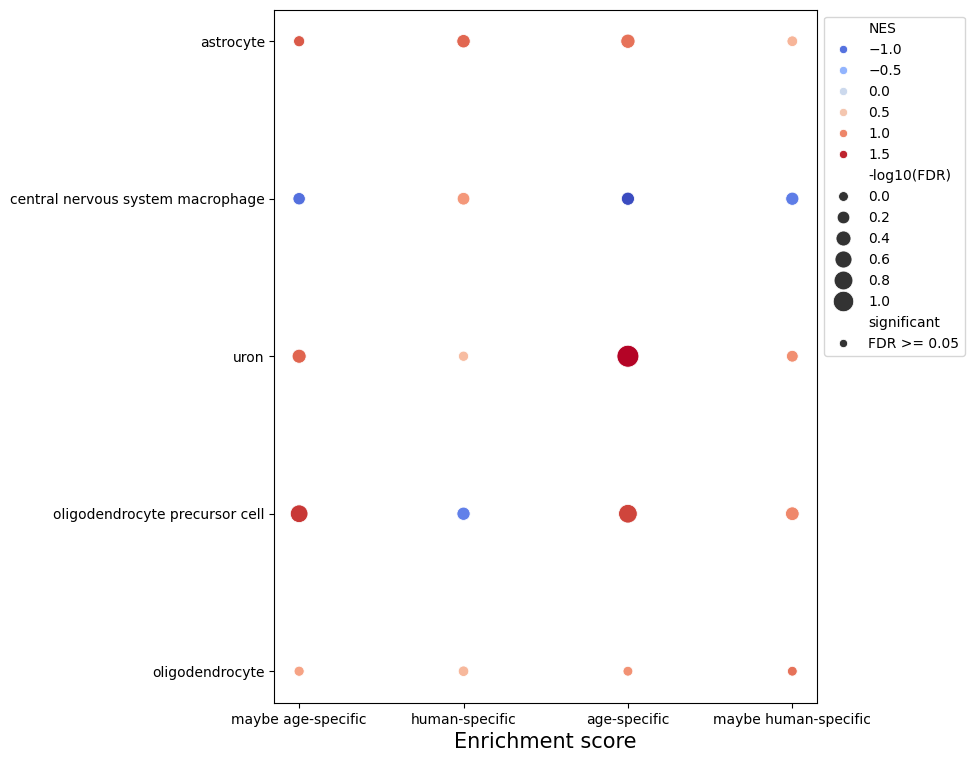

In [69]:
mpl.rcdefaults()
palette = sns.color_palette("coolwarm", as_cmap=True)

enrichment_plot(
    enrich_res=enrich_df,
    x='Term',
    y='celltype',
    size='-log10(FDR)',
    sizes=(50, 250),
    hue='NES',
    palette=palette,
    style='significant',
    markers={'FDR < 0.05': '*', 'FDR >= 0.05': 'o'}
)

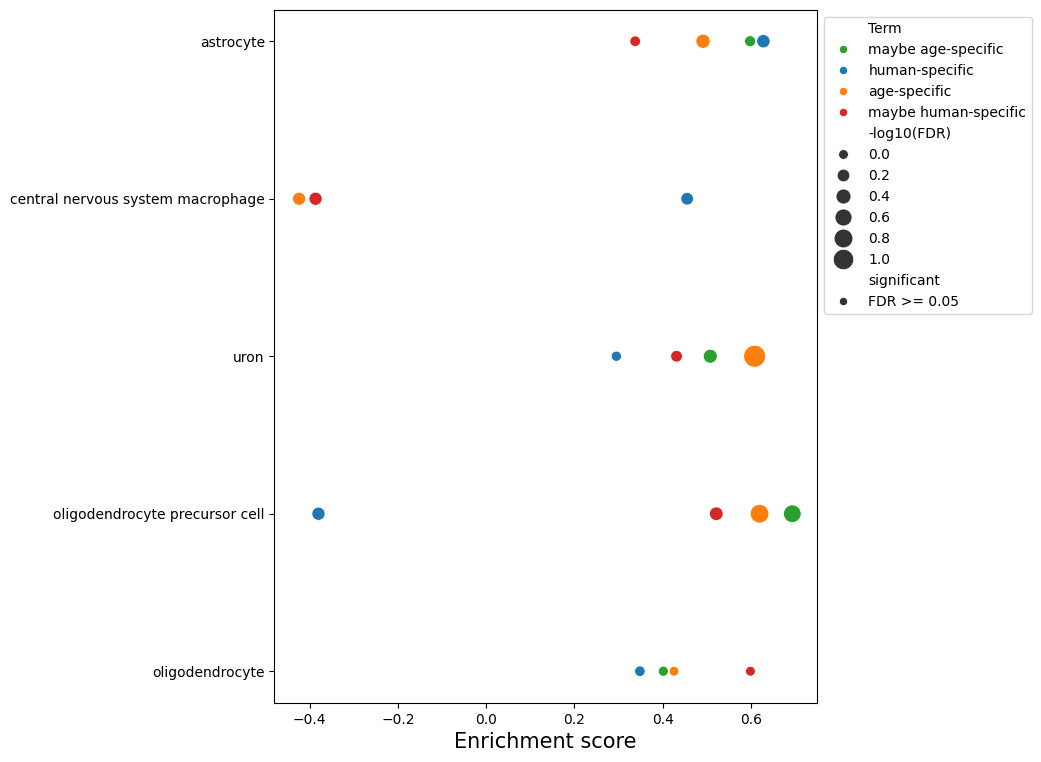

In [70]:
mpl.rcdefaults()
palette = {'human-specific': 'tab:blue', 'age-specific': 'tab:orange', 'maybe human-specific': 'tab:red', 'maybe age-specific': 'tab:green'}

enrichment_plot(
    enrich_res=enrich_df,
    x='ES',
    y='celltype',
    size='-log10(FDR)',
    sizes=(50, 250),
    hue='Term',
    palette=palette,
    style='significant',
    markers={'FDR < 0.05': '*', 'FDR >= 0.05': 'o'}
)

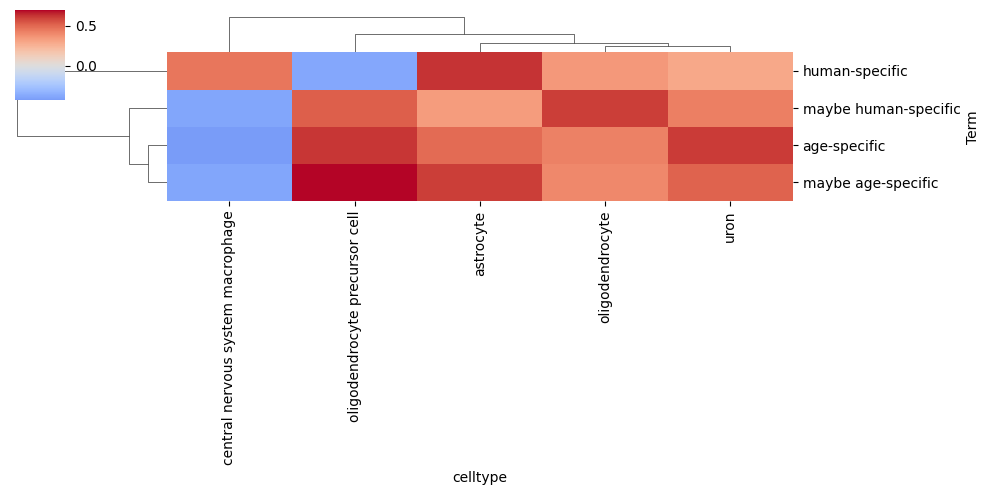

In [71]:
import seaborn as sns
es_df = enrich_df.pivot(index='Term', columns='celltype', values='ES')
sns.clustermap(es_df.astype(float), figsize=(10, 5), cmap='coolwarm', center=0)

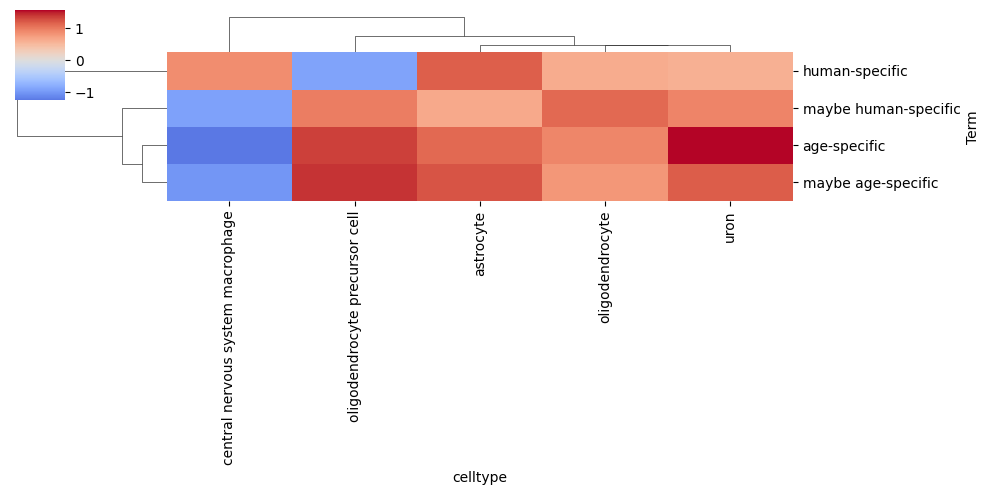

In [72]:
es_df = enrich_df.pivot(index='Term', columns='celltype', values='NES')
sns.clustermap(es_df.astype(float), figsize=(10, 5), cmap='coolwarm', center=0)

<Axes: xlabel='Term', ylabel='celltype'>

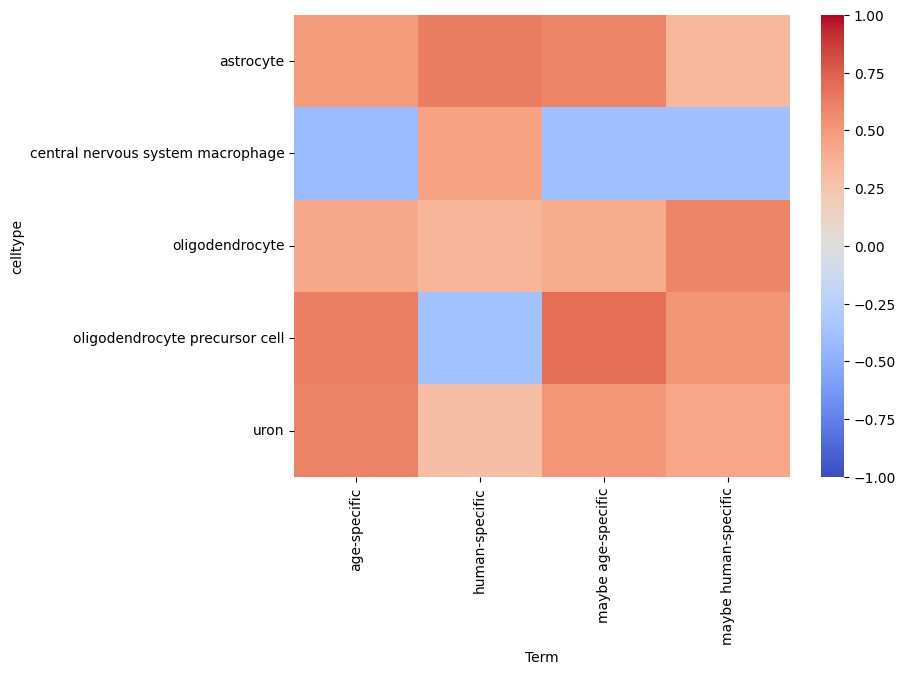

In [73]:
import seaborn as sns
fig = plt.figure(figsize=(8, 6))
es_df = enrich_df.pivot(index='Term', columns='celltype', values='ES')
sns.heatmap(es_df.astype(float).T, cmap='coolwarm', center=0, vmin=-1, vmax=1)

### EdgeR (logFC)

Run enrichment for genesets

In [74]:
enrich_df = enrich_celltypes(res_edgeR, gene_sets, gene_col='names', score_col='logFC', method='score', gsea_kw={'verbose': True})
enrich_df.head(2)

  0%|          | 0/5 [00:00<?, ?it/s]

2024-07-15 16:34:15,551 [INFO] Parsing data files for GSEA.............................
2024-07-15 16:34:15,566 [INFO] 0000 gene_sets have been filtered out when max_size=1000 and min_size=0
2024-07-15 16:34:15,566 [INFO] 0004 gene_sets used for further statistical testing.....
2024-07-15 16:34:15,566 [INFO] Start to run GSEA...Might take a while..................
2024-07-15 16:34:16,282 [INFO] Congratulations. GSEApy runs successfully................

2024-07-15 16:34:16,301 [INFO] Parsing data files for GSEA.............................
2024-07-15 16:34:16,314 [INFO] 0000 gene_sets have been filtered out when max_size=1000 and min_size=0
2024-07-15 16:34:16,314 [INFO] 0004 gene_sets used for further statistical testing.....
2024-07-15 16:34:16,314 [INFO] Start to run GSEA...Might take a while..................
2024-07-15 16:34:16,887 [INFO] Congratulations. GSEApy runs successfully................

2024-07-15 16:34:16,901 [INFO] Parsing data files for GSEA............................

Name                Term        ES       NES NOM p-val FDR q-val  \
0  prerank      human-specific  0.677295  1.340484  0.119217  0.244482   
1  prerank  maybe age-specific  0.407448  0.929768  0.571189  0.575976   

  FWER p-val Tag % Gene %      Lead_genes   celltype  
0      0.256   1/9  0.62%            AMZ2  astrocyte  
1        0.8  3/16  4.22%  ID2;LHX2;MACF1  astrocyte

Process enrichment results

In [75]:
process_enrichment_df(enrich_df)
enrich_df.head(2)

Name                Term        ES       NES NOM p-val FDR q-val  \
0  prerank      human-specific  0.677295  1.340484  0.119217  0.244482   
1  prerank  maybe age-specific  0.407448  0.929768  0.571189  0.575976   

  FWER p-val Tag % Gene %      Lead_genes   celltype  -log10(FDR) direction  \
0      0.256   1/9  0.62%            AMZ2  astrocyte     0.609980  enriched   
1        0.8  3/16  4.22%  ID2;LHX2;MACF1  astrocyte     0.238842  enriched   

   significant  
0  FDR >= 0.05  
1  FDR >= 0.05

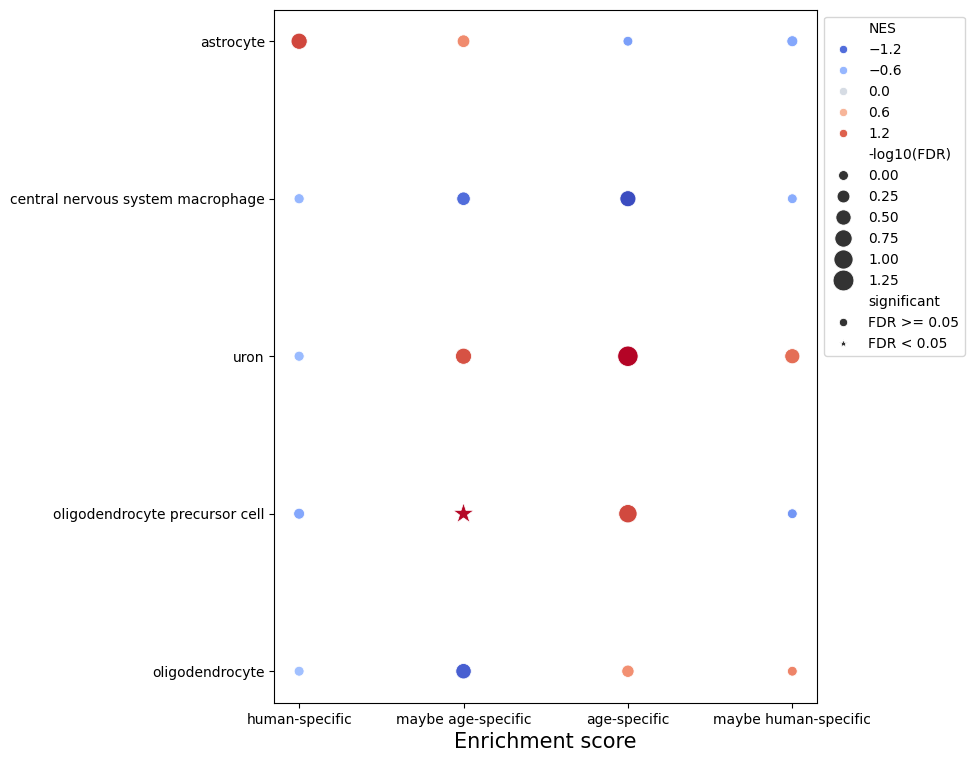

In [76]:
mpl.rcdefaults()
palette = sns.color_palette("coolwarm", as_cmap=True)

enrichment_plot(
    enrich_res=enrich_df,
    x='Term',
    y='celltype',
    size='-log10(FDR)',
    sizes=(50, 250),
    hue='NES',
    palette=palette,
    style='significant',
    markers={'FDR < 0.05': '*', 'FDR >= 0.05': 'o'}
)

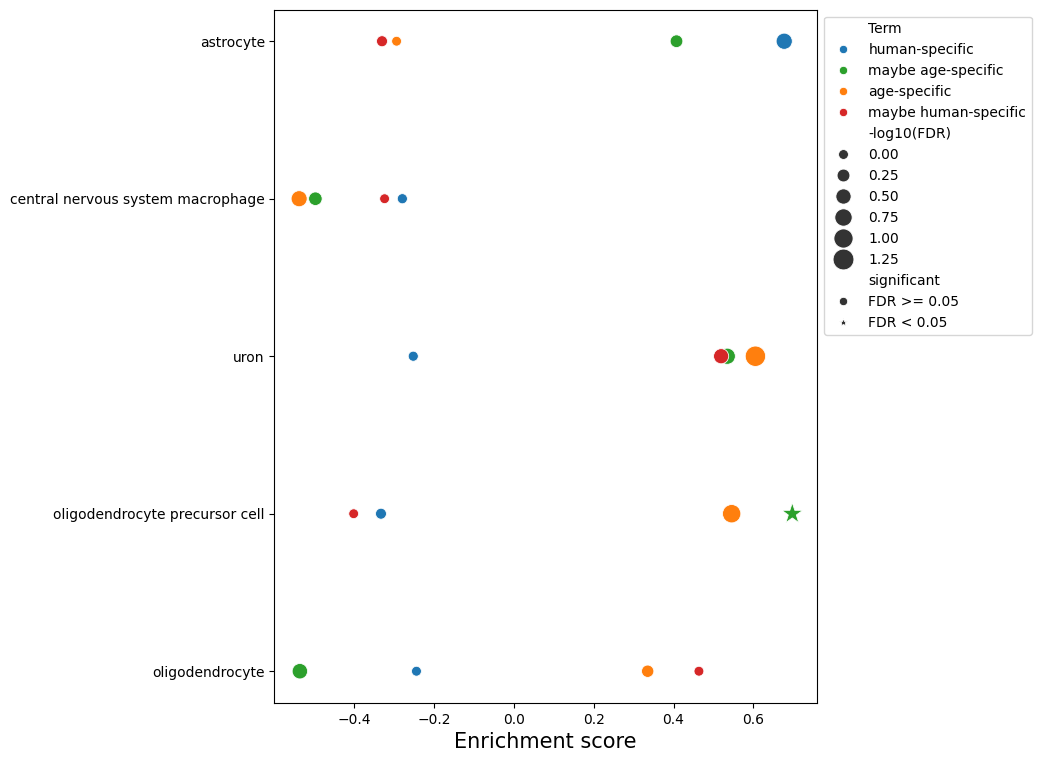

In [77]:
mpl.rcdefaults()
palette = {'human-specific': 'tab:blue', 'age-specific': 'tab:orange', 'maybe human-specific': 'tab:red', 'maybe age-specific': 'tab:green'}

enrichment_plot(
    enrich_res=enrich_df,
    x='ES',
    y='celltype',
    size='-log10(FDR)',
    sizes=(50, 250),
    hue='Term',
    palette=palette,
    style='significant',
    markers={'FDR < 0.05': '*', 'FDR >= 0.05': 'o'}
)

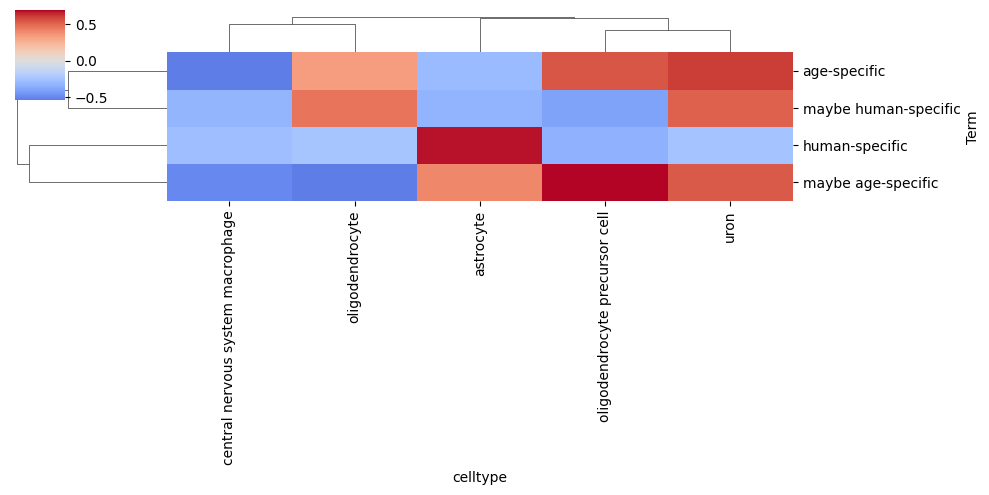

In [78]:
import seaborn as sns
es_df = enrich_df.pivot(index='Term', columns='celltype', values='ES')
sns.clustermap(es_df.astype(float), figsize=(10, 5), cmap='coolwarm', center=0)

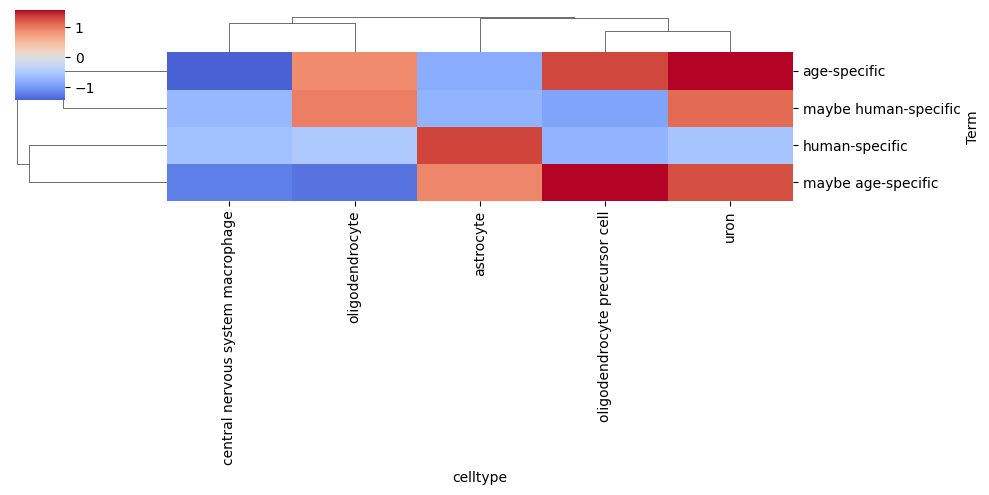

In [79]:
es_df = enrich_df.pivot(index='Term', columns='celltype', values='NES')
sns.clustermap(es_df.astype(float), figsize=(10, 5), cmap='coolwarm', center=0)

<Axes: xlabel='Term', ylabel='celltype'>

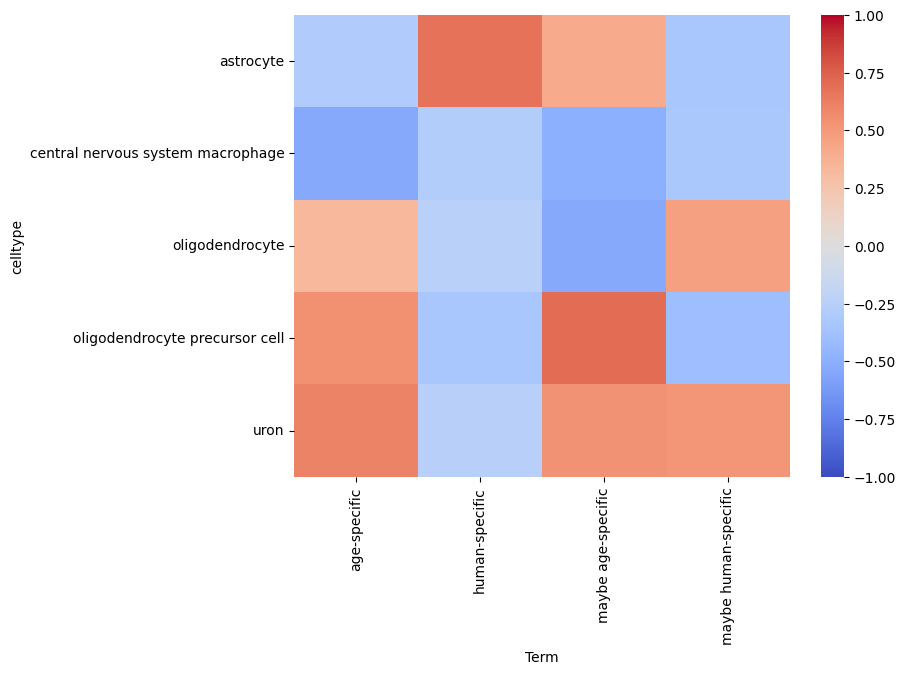

In [80]:
import seaborn as sns
fig = plt.figure(figsize=(8, 6))
es_df = enrich_df.pivot(index='Term', columns='celltype', values='ES')
sns.heatmap(es_df.astype(float).T, cmap='coolwarm', center=0, vmin=-1, vmax=1)

### Gene visualization

Calculate average normalized expression

In [81]:
for cell_type in gene_sets.keys():
    genes = scaled_adata.var_names.intersection(gene_sets[cell_type])
    scaled_adata.obs[f'{cell_type}_scaled'] = scaled_adata[:, genes].X.mean(axis=1)
scaled_adata.obs.head()

roi organism_ontology_term_id  \
CellID                                                           
10X227_5:AACGGGATCCGCTGTT  Human A24            NCBITaxon:9606   
10X227_5:ATCATTCAGGCTTAGG  Human A24            NCBITaxon:9606   
10X227_5:ACATCCCGTAGGAAAG  Human A24            NCBITaxon:9606   
10X227_5:CCATAAGTCCTGGCTT  Human A24            NCBITaxon:9606   
10X227_5:ATTCTTGGTACCAATC  Human A24            NCBITaxon:9606   

                          disease_ontology_term_id  \
CellID                                               
10X227_5:AACGGGATCCGCTGTT             PATO:0000461   
10X227_5:ATCATTCAGGCTTAGG             PATO:0000461   
10X227_5:ACATCCCGTAGGAAAG             PATO:0000461   
10X227_5:CCATAAGTCCTGGCTT             PATO:0000461   
10X227_5:ATTCTTGGTACCAATC             PATO:0000461   

                          self_reported_ethnicity_ontology_term_id  \
CellID                                                               
10X227_5:AACGGGATCCGCTGTT                           HANCESTRO:0005   
10X227_5:ATCATTCAGGCTTAGG                           HANCESTRO:0005   
10X227_5:ACATCCCGTAGGAAAG                           HANCESTRO:0005   
10X227_5:CCATAAGTCCTGGCTT                           HANCESTRO:0005   
10X227_5:ATTCTTGGTACCAATC                           HANCESTRO:0005   

                          assay_ontology_term_id sex_ontology_term_id  \
CellID                                                                  
10X227_5:AACGGGATCCGCTGTT            EFO:0009922         PATO:0000384   
10X227_5:ATCATTCAGGCTTAGG            EFO:0009922         PATO:0000384   
10X227_5:ACATCCCGTAGGAAAG            EFO:0009922         PATO:0000384   
10X227_5:CCATAAGTCCTGGCTT            EFO:0009922         PATO:0000384   
10X227_5:ATTCTTGGTACCAATC            EFO:0009922         PATO:0000384   

                          development_stage_ontology_term_id    donor_id  \
CellID                                                                     
10X227_5:AACGGGATCCGCTGTT                     HsapDv:0000144  H18.30.002   
10X227_5:ATCATTCAGGCTTAGG                     HsapDv:0000144  H18.30.002   
10X227_5:ACATCCCGTAGGAAAG                     HsapDv:0000144  H18.30.002   
10X227_5:CCATAAGTCCTGGCTT                     HsapDv:0000144  H18.30.002   
10X227_5:ATTCTTGGTACCAATC                     HsapDv:0000144  H18.30.002   

                          suspension_type  \
CellID                                      
10X227_5:AACGGGATCCGCTGTT         nucleus   
10X227_5:ATCATTCAGGCTTAGG         nucleus   
10X227_5:ACATCCCGTAGGAAAG         nucleus   
10X227_5:CCATAAGTCCTGGCTT         nucleus   
10X227_5:ATTCTTGGTACCAATC         nucleus   

                                                                  dissection  \
CellID                                                                         
10X227_5:AACGGGATCCGCTGTT  Cerebral cortex (Cx) - Cingulate gyrus, rostra...   
10X227_5:ATCATTCAGGCTTAGG  Cerebral cortex (Cx) - Cingulate gyrus, rostra...   
10X227_5:ACATCCCGTAGGAAAG  Cerebral cortex (Cx) - Cingulate gyrus, rostra...   
10X227_5:CCATAAGTCCTGGCTT  Cerebral cortex (Cx) - Cingulate gyrus, rostra...   
10X227_5:ATTCTTGGTACCAATC  Cerebral cortex (Cx) - Cingulate gyrus, rostra...   

                           ...   sex           tissue  \
CellID                     ...                          
10X227_5:AACGGGATCCGCTGTT  ...  male  cerebral cortex   
10X227_5:ATCATTCAGGCTTAGG  ...  male  cerebral cortex   
10X227_5:ACATCCCGTAGGAAAG  ...  male  cerebral cortex   
10X227_5:CCATAAGTCCTGGCTT  ...  male  cerebral cortex   
10X227_5:ATTCTTGGTACCAATC  ...  male  cerebral cortex   

                           self_reported_ethnicity        development_stage  \
CellID                                                                        
10X227_5:AACGGGATCCGCTGTT                 European  50-year-old human stage   
10X227_5:ATCATTCAGGCTTAGG                 European  50-year-old human stage   
10X227_5:ACATCCCGTAGGAAAG                 European  50-year-ol

Vusualize

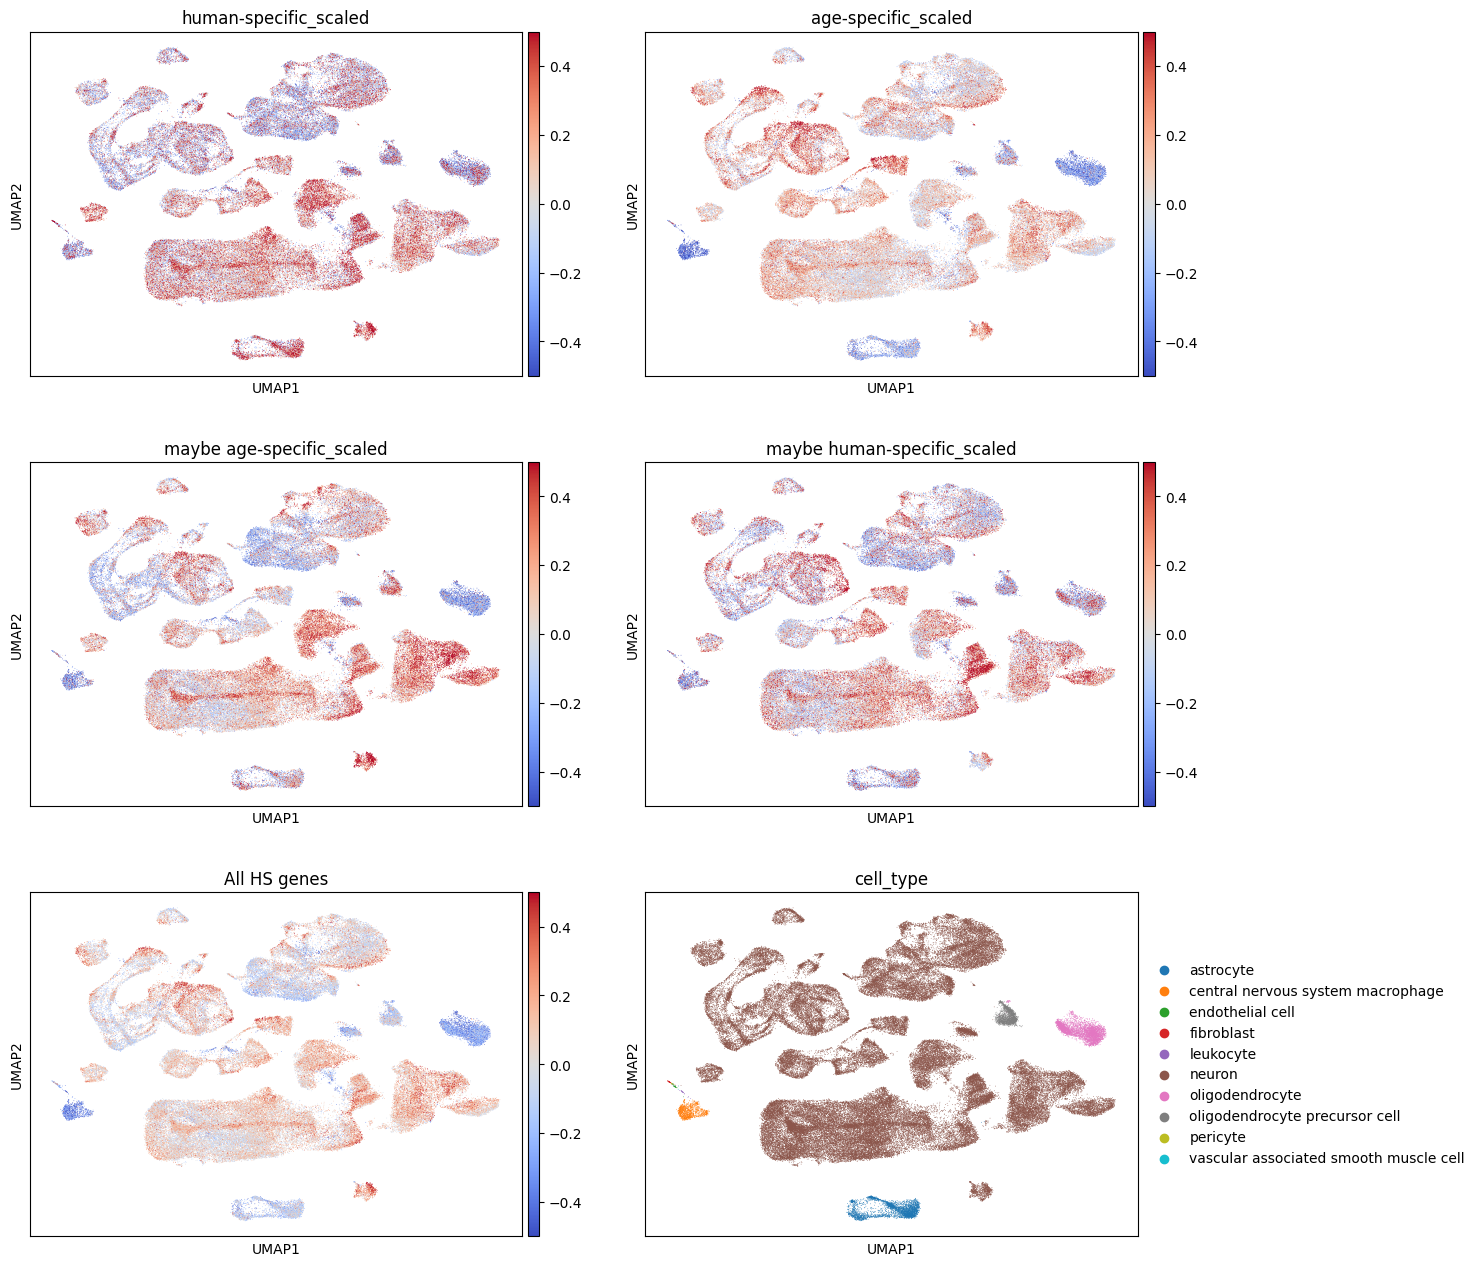

In [82]:
cmap = mpl.cm.coolwarm
norm = mpl.colors.TwoSlopeNorm(vcenter=0, vmax=0.5, vmin=-0.5)
color = [
    'human-specific_scaled', 
    'age-specific_scaled', 
    'maybe age-specific_scaled', 
    'maybe human-specific_scaled', 
    'All HS genes', 
    'cell_type'
    ]

sc.pl.umap(scaled_adata, color=color, cmap=cmap, norm=norm, ncols=2)

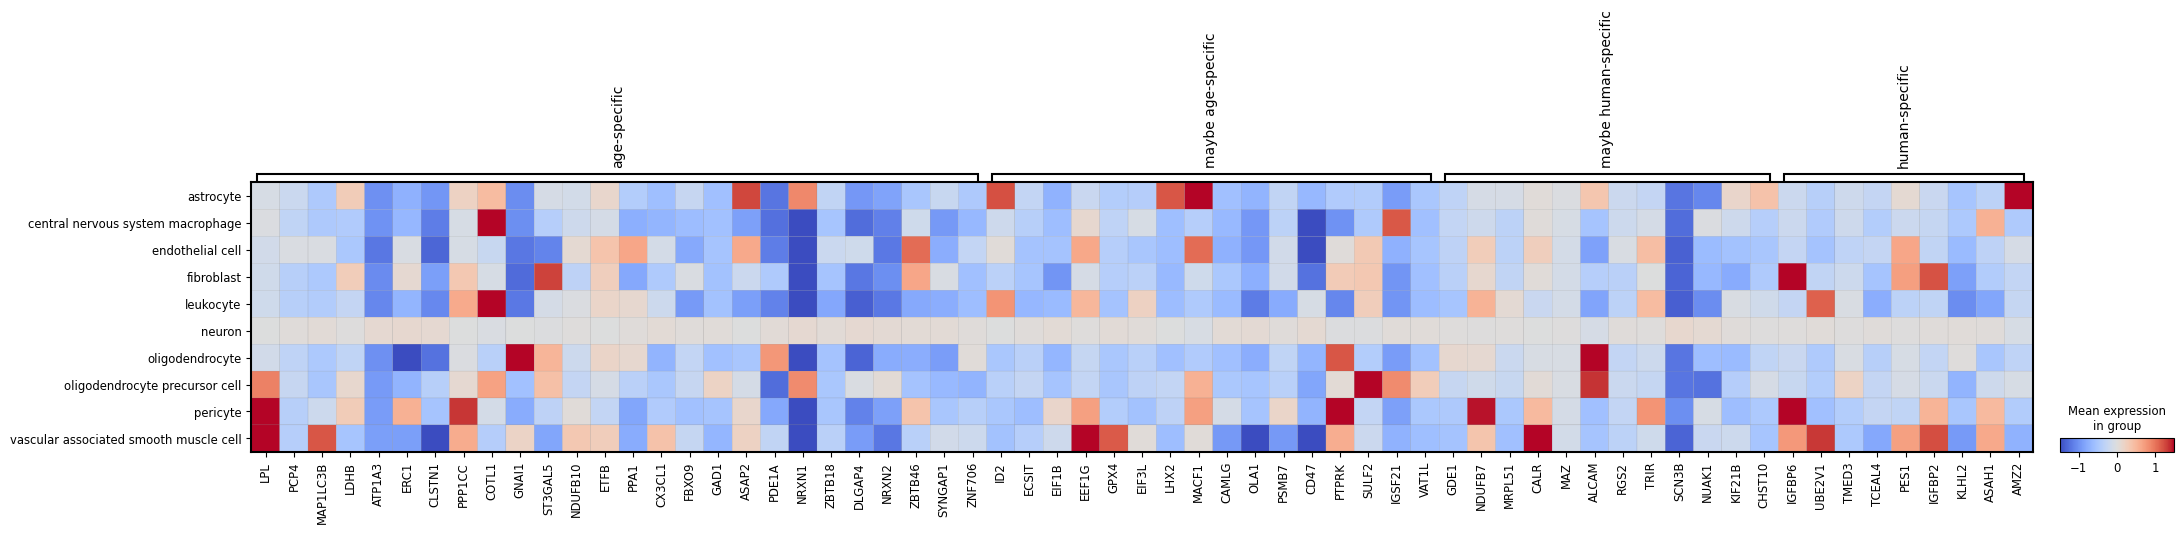

In [83]:
cmap = mpl.cm.coolwarm
norm = mpl.colors.TwoSlopeNorm(vcenter=0, vmax=1.5, vmin=-1.5)
gene_sets_inter = {key: scaled_adata.var_names.intersection(value) for key, value in gene_sets.items()}

sc.pl.matrixplot(scaled_adata, gene_sets_inter, groupby='cell_type', cmap='coolwarm', norm=norm)

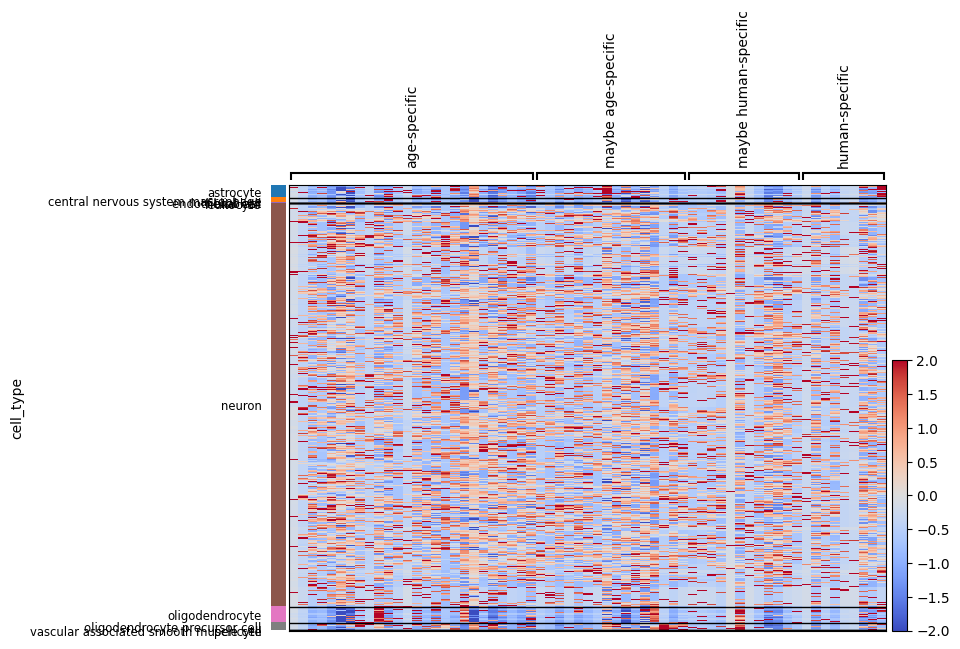

In [84]:
cmap = mpl.cm.coolwarm
norm = mpl.colors.TwoSlopeNorm(vcenter=0, vmax=2, vmin=-2)
gene_sets_inter = {key: scaled_adata.var_names.intersection(value) for key, value in gene_sets.items()}

sc.pl.heatmap(scaled_adata, gene_sets_inter, groupby='cell_type', cmap='coolwarm', norm=norm)

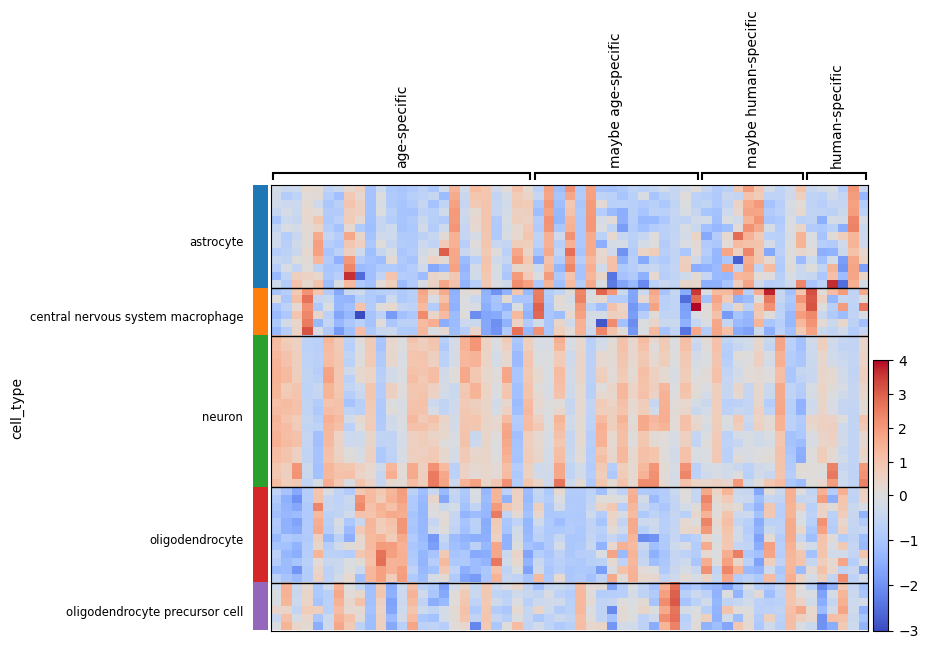

In [85]:
cmap = mpl.cm.coolwarm
norm = mpl.colors.TwoSlopeNorm(vcenter=0)
gene_sets_inter = {key: scaled_adata_pb.var_names.intersection(value) for key, value in gene_sets.items()}

sc.pl.heatmap(scaled_adata_pb, gene_sets_inter, groupby='cell_type', cmap='coolwarm', vcenter=0, vmin=-3, vmax=4)

## Enrich for clusters

In [86]:
gene_sets = dict()
for label in cluster_groups.label.unique():
  gene_sets[f'cluster{label}'] = cluster_groups[cluster_groups.label == label].index.to_list()

### T-test

Specify DE test

In [87]:
key = 't-test'

Run enrichment for genesets

In [88]:
enrich_df = enrich_celltypes(celltypes, gene_sets, adata=adata_pb, key=key, gene_col='names', score_col='scores', method='score', gsea_kw={'verbose': False})
enrich_df.head(2)

  0%|          | 0/5 [00:00<?, ?it/s]

2024-07-15 16:34:24,624 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-15 16:34:25,132 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-15 16:34:25,682 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-15 16:34:26,224 [WARNING] Duplicated values found in preranked stats: 0.03% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


Name      Term        ES       NES NOM p-val FDR q-val FWER p-val Tag %  \
0  prerank  cluster4 -0.694149 -1.581886  0.016129  0.057235   0.052577   5/8   
1  prerank  cluster2 -0.706334 -1.561328  0.018947  0.036177   0.065979   4/7   

   Gene %                        Lead_genes   celltype  
0  19.91%  IGSF21;ATP1A3;PTPRK;VAT1L;CLSTN1  astrocyte  
1   9.98%            NUAK1;GNAI1;OLA1;KLHL2  astrocyte

Process enrichment results

In [89]:
process_enrichment_df(enrich_df)
enrich_df.head(2)

Name      Term        ES       NES NOM p-val FDR q-val FWER p-val Tag %  \
0  prerank  cluster4 -0.694149 -1.581886  0.016129  0.057235   0.052577   5/8   
1  prerank  cluster2 -0.706334 -1.561328  0.018947  0.036177   0.065979   4/7   

   Gene %                        Lead_genes   celltype  -log10(FDR) direction  \
0  19.91%  IGSF21;ATP1A3;PTPRK;VAT1L;CLSTN1  astrocyte     1.234813  depleted   
1   9.98%            NUAK1;GNAI1;OLA1;KLHL2  astrocyte     1.429724  depleted   

   significant  
0  FDR >= 0.05  
1   FDR < 0.05

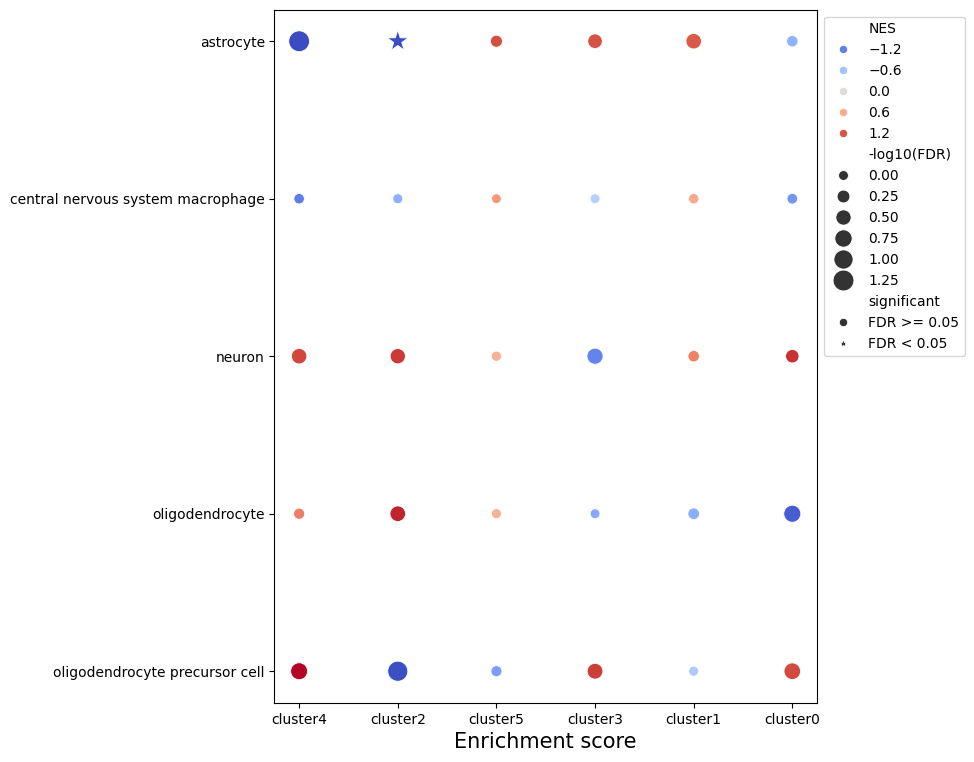

In [90]:
mpl.rcdefaults()
palette = sns.color_palette("coolwarm", as_cmap=True)

enrichment_plot(
    enrich_res=enrich_df,
    x='Term',
    y='celltype',
    size='-log10(FDR)',
    sizes=(50, 250),
    hue='NES',
    palette=palette,
    style='significant',
    markers={'FDR < 0.05': '*', 'FDR >= 0.05': 'o'}
)

C:\Users\claptar\AppData\Local\Temp\ipykernel_18644\2110194606.py:6: UserWarning: The palette list has more values (12) than needed (6), which may not be intended.
  ax = sns.scatterplot(data=enrich_res.reset_index(), **kw_scatterplot)


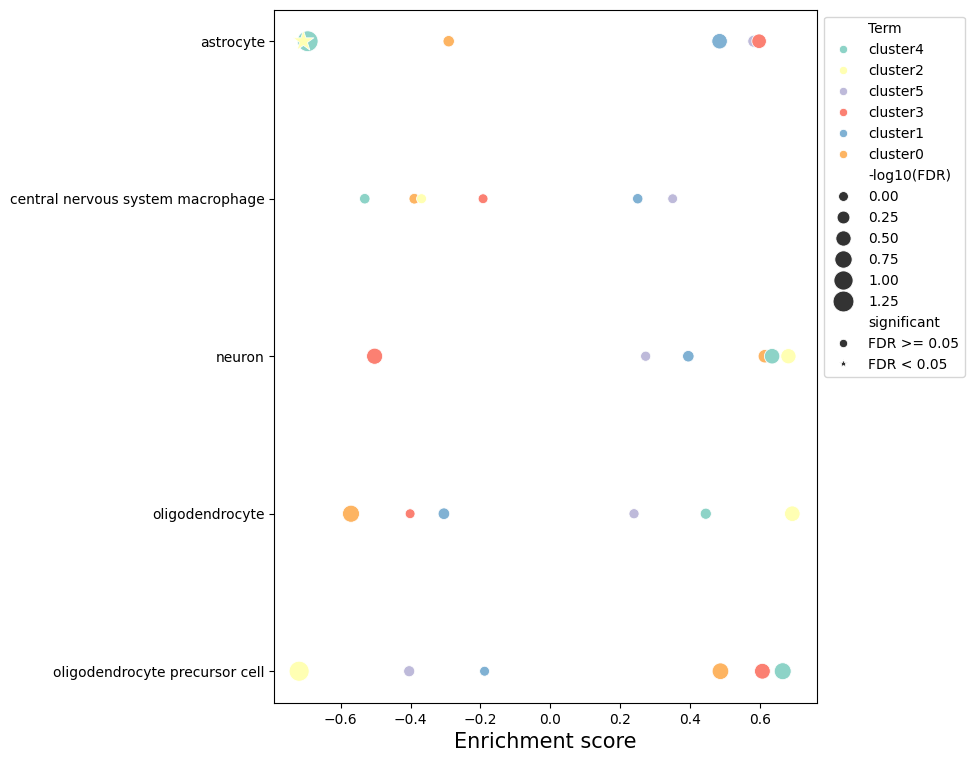

In [91]:
mpl.rcdefaults()
palette = sns.color_palette("Set3")

enrichment_plot(
    enrich_res=enrich_df,
    x='ES',
    y='celltype',
    size='-log10(FDR)',
    sizes=(50, 250),
    hue='Term',
    palette=palette,
    style='significant',
    markers={'FDR < 0.05': '*', 'FDR >= 0.05': 'o'}
)

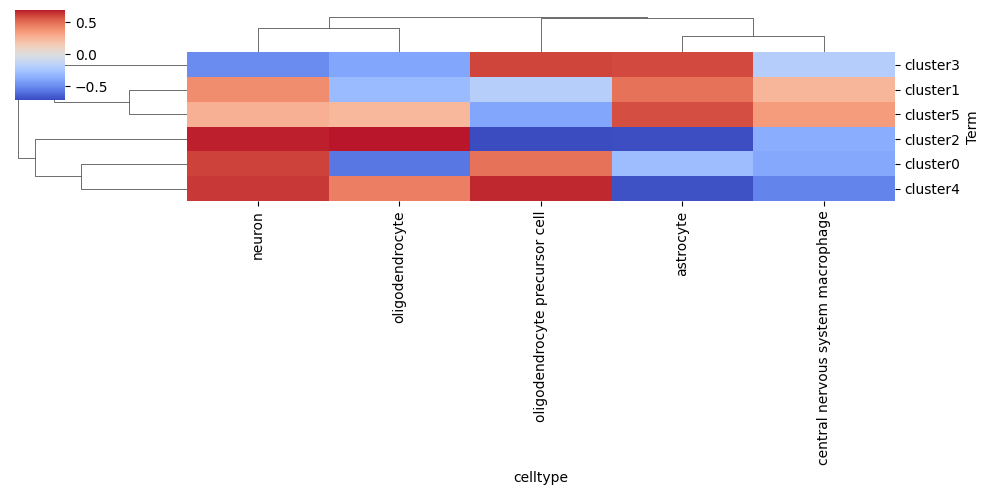

In [92]:
import seaborn as sns
es_df = enrich_df.pivot(index='Term', columns='celltype', values='ES')
sns.clustermap(es_df.astype(float), figsize=(10, 5), cmap='coolwarm', center=0)

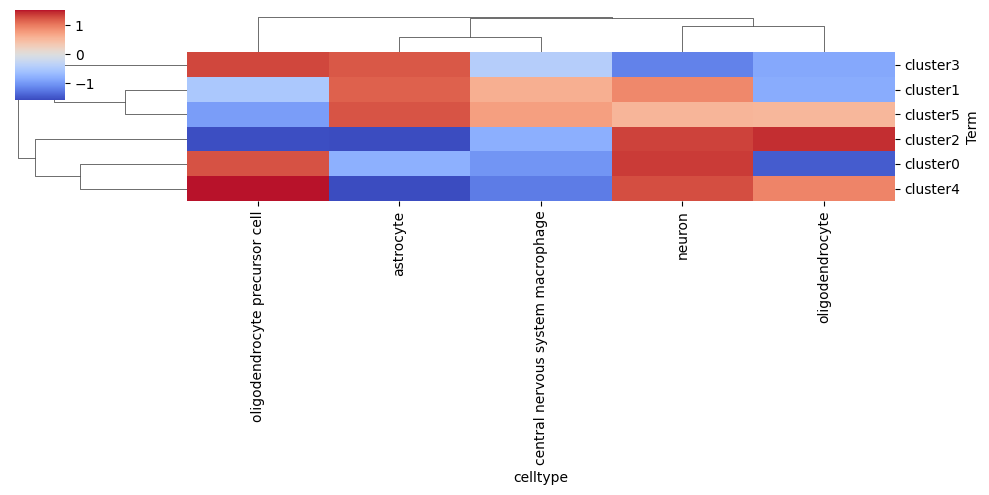

In [93]:
es_df = enrich_df.pivot(index='Term', columns='celltype', values='NES')
sns.clustermap(es_df.astype(float), figsize=(10, 5), cmap='coolwarm', center=0)

<Axes: xlabel='Term', ylabel='celltype'>

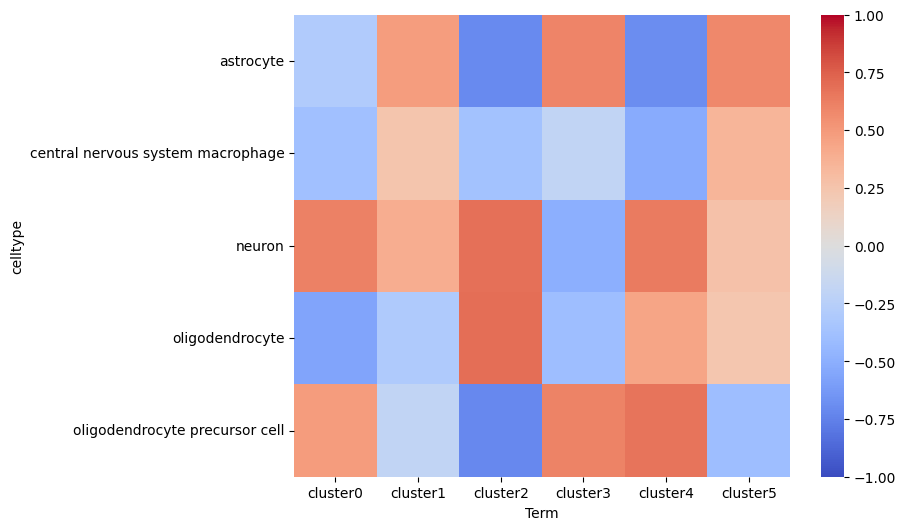

In [94]:
import seaborn as sns
fig = plt.figure(figsize=(8, 6))
es_df = enrich_df.pivot(index='Term', columns='celltype', values='ES')
sns.heatmap(es_df.astype(float).T, cmap='coolwarm', center=0, vmin=-1, vmax=1)

### Wilcoxon

Specify DE test

In [95]:
key = 'wilcoxon'

Run enrichment for genesets

In [96]:
enrich_df = enrich_celltypes(celltypes, gene_sets, adata=adata_pb, key=key, gene_col='names', score_col='scores', method='lfc_product', gsea_kw={'verbose': False})
enrich_df.head(2)

  0%|          | 0/5 [00:00<?, ?it/s]

2024-07-15 16:34:28,565 [WARNING] Duplicated values found in preranked stats: 0.35% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-15 16:34:29,674 [WARNING] Duplicated values found in preranked stats: 0.23% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-15 16:34:30,258 [WARNING] Duplicated values found in preranked stats: 0.69% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


Name      Term        ES       NES NOM p-val FDR q-val FWER p-val Tag %  \
0  prerank  cluster4 -0.816706 -1.418447  0.046125  0.173596   0.135952   4/8   
1  prerank  cluster2 -0.732734 -1.229302  0.234347   0.43217   0.524673   2/7   

   Gene %                 Lead_genes   celltype  
0  12.58%  IGSF21;ATP1A3;PTPRK;VAT1L  astrocyte  
1   6.18%                GNAI1;NUAK1  astrocyte

Process enrichment results

In [97]:
process_enrichment_df(enrich_df)
enrich_df.head(2)

Name      Term        ES       NES NOM p-val FDR q-val FWER p-val Tag %  \
0  prerank  cluster4 -0.816706 -1.418447  0.046125  0.173596   0.135952   4/8   
1  prerank  cluster2 -0.732734 -1.229302  0.234347   0.43217   0.524673   2/7   

   Gene %                 Lead_genes   celltype  -log10(FDR) direction  \
0  12.58%  IGSF21;ATP1A3;PTPRK;VAT1L  astrocyte     0.757965  depleted   
1   6.18%                GNAI1;NUAK1  astrocyte     0.363342  depleted   

   significant  
0  FDR >= 0.05  
1  FDR >= 0.05

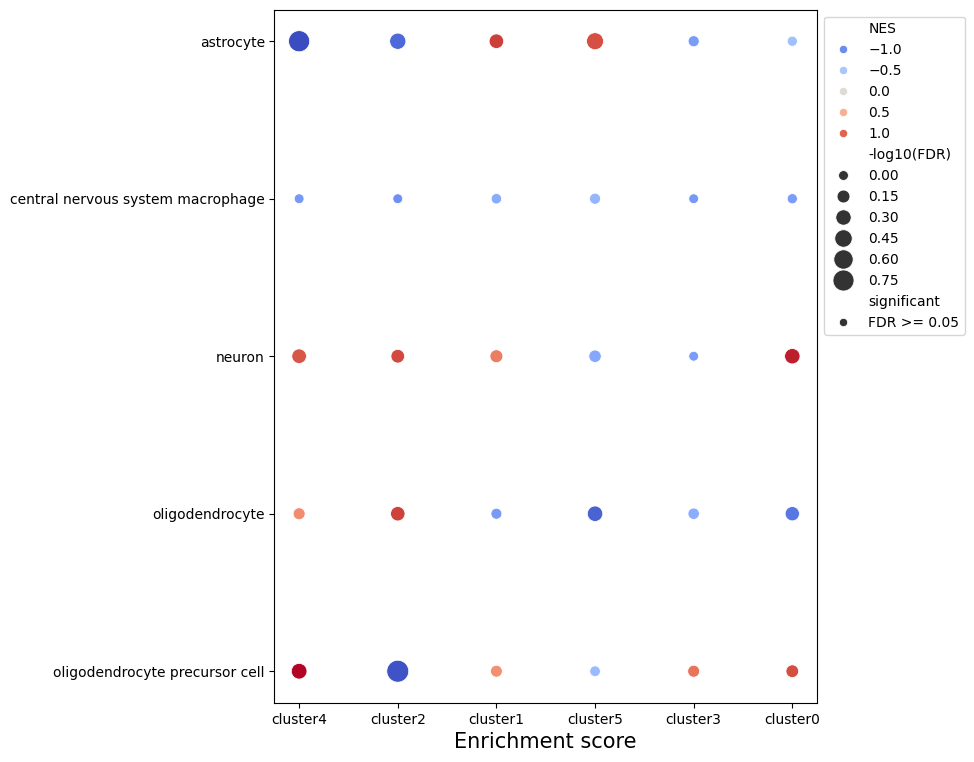

In [98]:
mpl.rcdefaults()
palette = sns.color_palette("coolwarm", as_cmap=True)

enrichment_plot(
    enrich_res=enrich_df,
    x='Term',
    y='celltype',
    size='-log10(FDR)',
    sizes=(50, 250),
    hue='NES',
    palette=palette,
    style='significant',
    markers={'FDR < 0.05': '*', 'FDR >= 0.05': 'o'}
)

C:\Users\claptar\AppData\Local\Temp\ipykernel_18644\2110194606.py:6: UserWarning: The palette list has more values (12) than needed (6), which may not be intended.
  ax = sns.scatterplot(data=enrich_res.reset_index(), **kw_scatterplot)


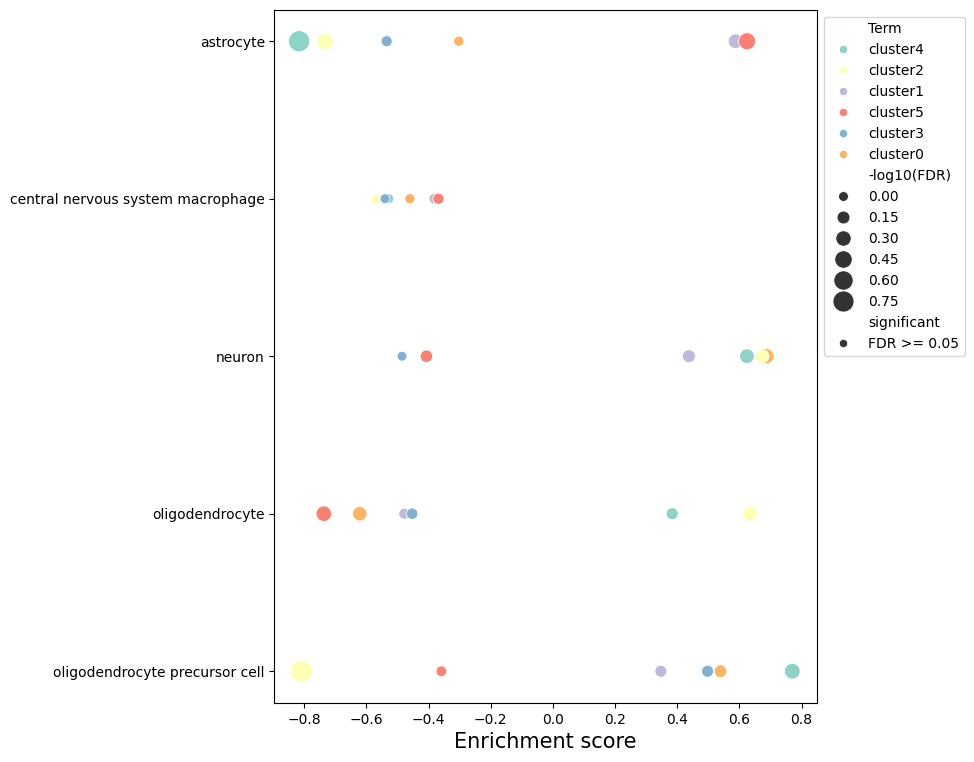

In [99]:
mpl.rcdefaults()
palette = sns.color_palette("Set3")

enrichment_plot(
    enrich_res=enrich_df,
    x='ES',
    y='celltype',
    size='-log10(FDR)',
    sizes=(50, 250),
    hue='Term',
    palette=palette,
    style='significant',
    markers={'FDR < 0.05': '*', 'FDR >= 0.05': 'o'}
)

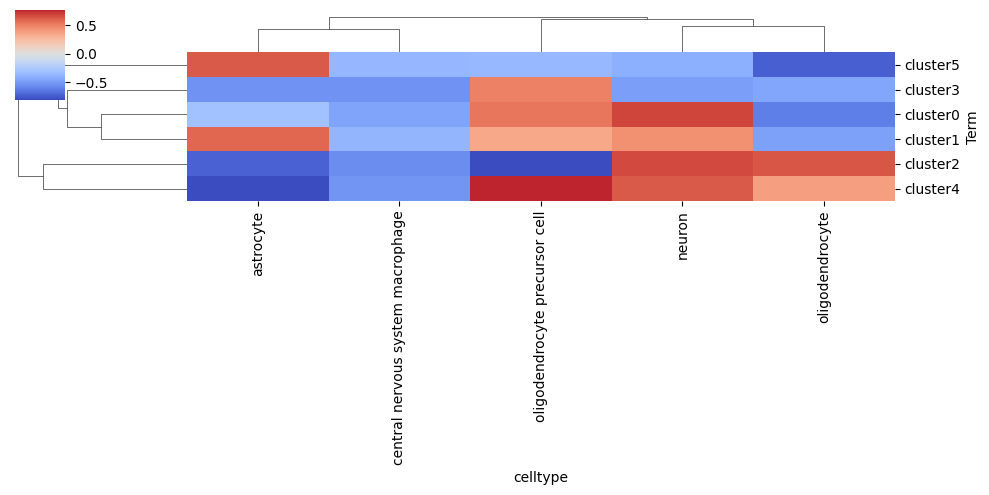

In [100]:
import seaborn as sns
es_df = enrich_df.pivot(index='Term', columns='celltype', values='ES')
sns.clustermap(es_df.astype(float), figsize=(10, 5), cmap='coolwarm', center=0)

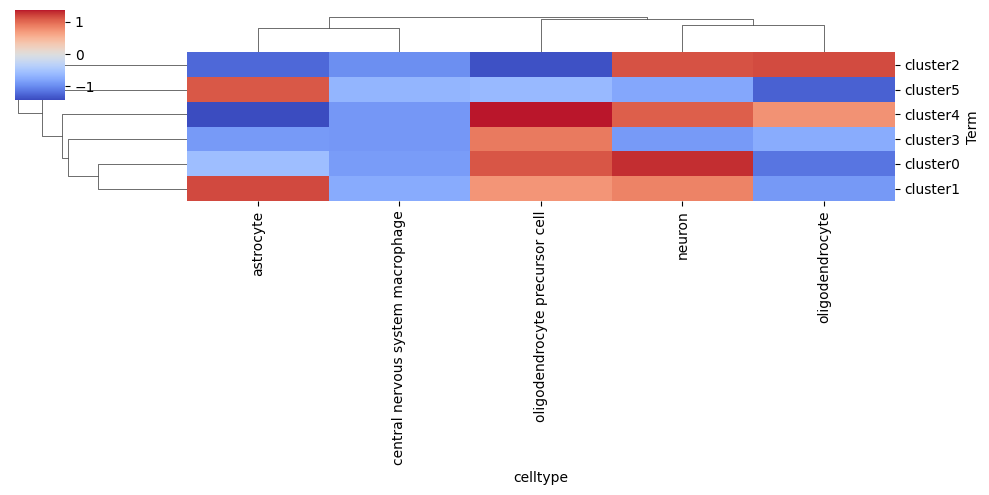

In [101]:
es_df = enrich_df.pivot(index='Term', columns='celltype', values='NES')
sns.clustermap(es_df.astype(float), figsize=(10, 5), cmap='coolwarm', center=0)

<Axes: xlabel='Term', ylabel='celltype'>

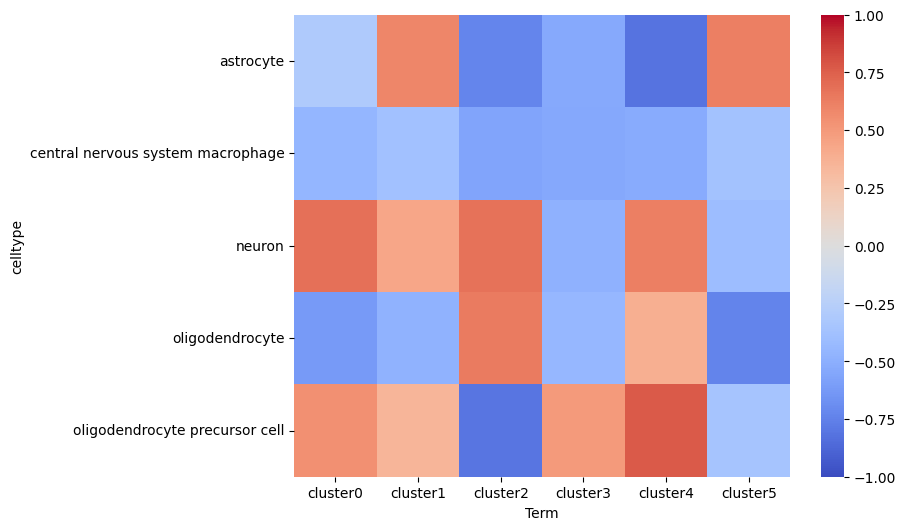

In [102]:
import seaborn as sns
fig = plt.figure(figsize=(8, 6))
es_df = enrich_df.pivot(index='Term', columns='celltype', values='ES')
sns.heatmap(es_df.astype(float).T, cmap='coolwarm', center=0, vmin=-1, vmax=1)

### Logreg

Specify DE test

In [103]:
key = 'logreg'

Run enrichment for genesets

In [104]:
enrich_df = enrich_celltypes(celltypes, gene_sets, adata=adata_pb, key=key, gene_col='names', score_col='scores', method='score', gsea_kw={'verbose': False})
enrich_df.head(2)

  0%|          | 0/5 [00:00<?, ?it/s]

2024-07-15 16:34:33,383 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-15 16:34:33,961 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


Name      Term        ES       NES NOM p-val FDR q-val FWER p-val Tag %  \
0  prerank  cluster4 -0.837335 -1.558449  0.006508  0.041712   0.058642   6/8   
1  prerank  cluster2  -0.72318 -1.330364  0.139918  0.151744   0.368313   2/7   

   Gene %                              Lead_genes   celltype  
0  11.69%  IGSF21;PTPRK;ALCAM;VAT1L;CLSTN1;ATP1A3  astrocyte  
1   5.11%                             GNAI1;NUAK1  astrocyte

Process enrichment results

In [105]:
process_enrichment_df(enrich_df)
enrich_df.head(2)

Name      Term        ES       NES NOM p-val FDR q-val FWER p-val Tag %  \
0  prerank  cluster4 -0.837335 -1.558449  0.006508  0.041712   0.058642   6/8   
1  prerank  cluster2  -0.72318 -1.330364  0.139918  0.151744   0.368313   2/7   

   Gene %                              Lead_genes   celltype  -log10(FDR)  \
0  11.69%  IGSF21;PTPRK;ALCAM;VAT1L;CLSTN1;ATP1A3  astrocyte     1.369454   
1   5.11%                             GNAI1;NUAK1  astrocyte     0.816036   

  direction  significant  
0  depleted   FDR < 0.05  
1  depleted  FDR >= 0.05

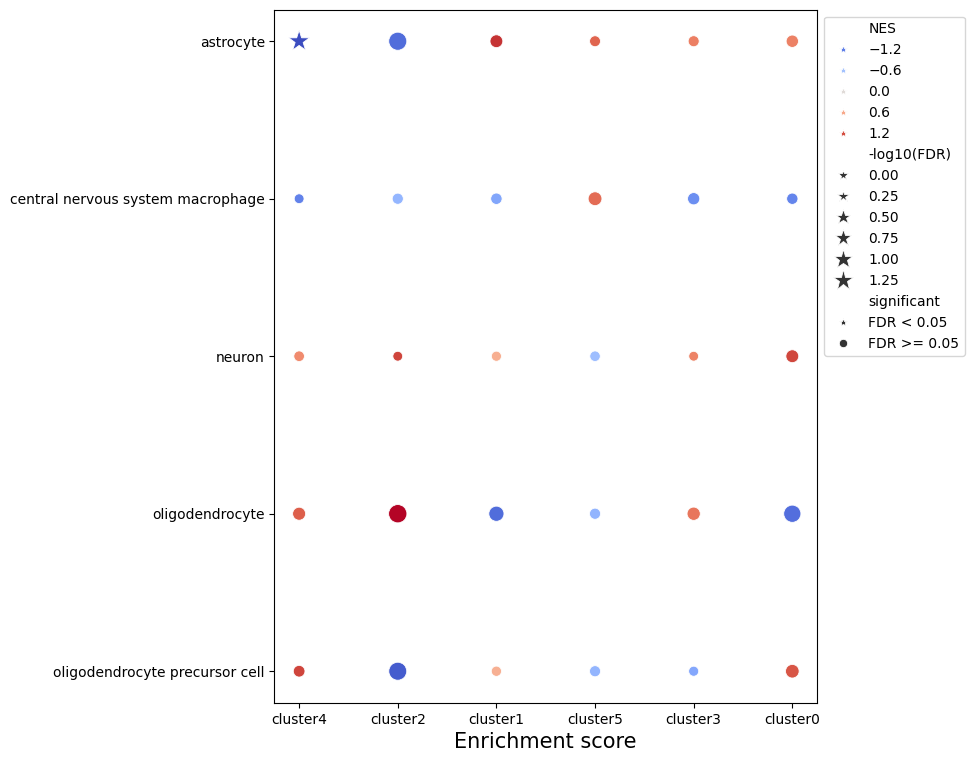

In [106]:
mpl.rcdefaults()
palette = sns.color_palette("coolwarm", as_cmap=True)

enrichment_plot(
    enrich_res=enrich_df,
    x='Term',
    y='celltype',
    size='-log10(FDR)',
    sizes=(50, 250),
    hue='NES',
    palette=palette,
    style='significant',
    markers={'FDR < 0.05': '*', 'FDR >= 0.05': 'o'}
)

C:\Users\claptar\AppData\Local\Temp\ipykernel_18644\2110194606.py:6: UserWarning: The palette list has more values (12) than needed (6), which may not be intended.
  ax = sns.scatterplot(data=enrich_res.reset_index(), **kw_scatterplot)


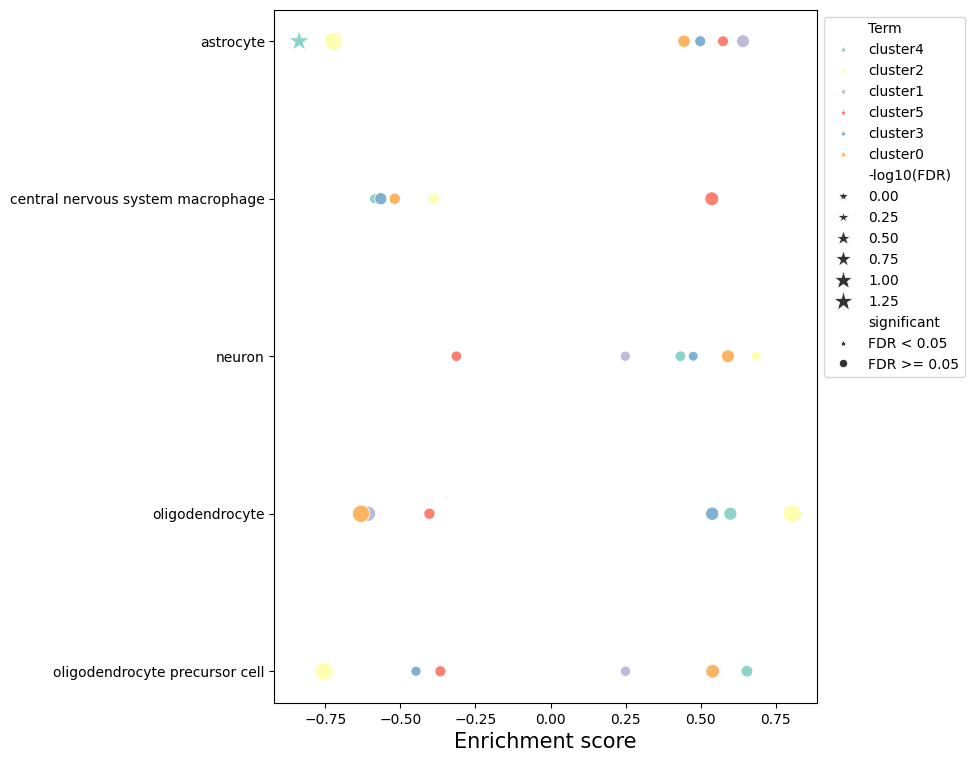

In [107]:
mpl.rcdefaults()
palette = sns.color_palette("Set3")

enrichment_plot(
    enrich_res=enrich_df,
    x='ES',
    y='celltype',
    size='-log10(FDR)',
    sizes=(50, 250),
    hue='Term',
    palette=palette,
    style='significant',
    markers={'FDR < 0.05': '*', 'FDR >= 0.05': 'o'}
)

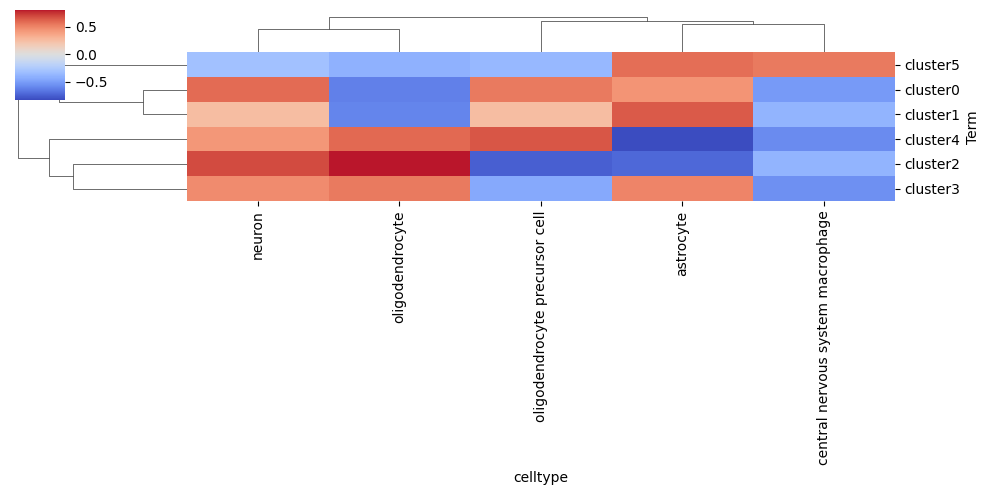

In [108]:
import seaborn as sns
es_df = enrich_df.pivot(index='Term', columns='celltype', values='ES')
sns.clustermap(es_df.astype(float), figsize=(10, 5), cmap='coolwarm', center=0)

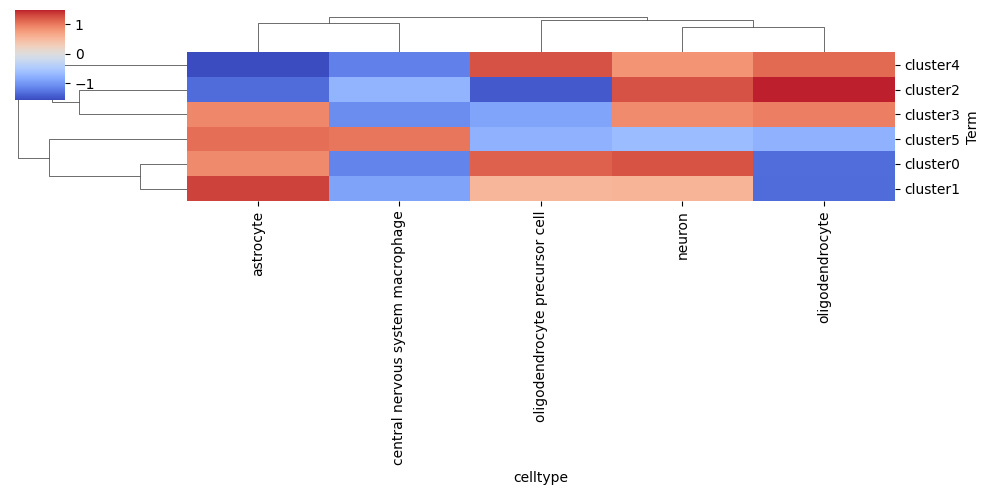

In [109]:
es_df = enrich_df.pivot(index='Term', columns='celltype', values='NES')
sns.clustermap(es_df.astype(float), figsize=(10, 5), cmap='coolwarm', center=0)

<Axes: xlabel='Term', ylabel='celltype'>

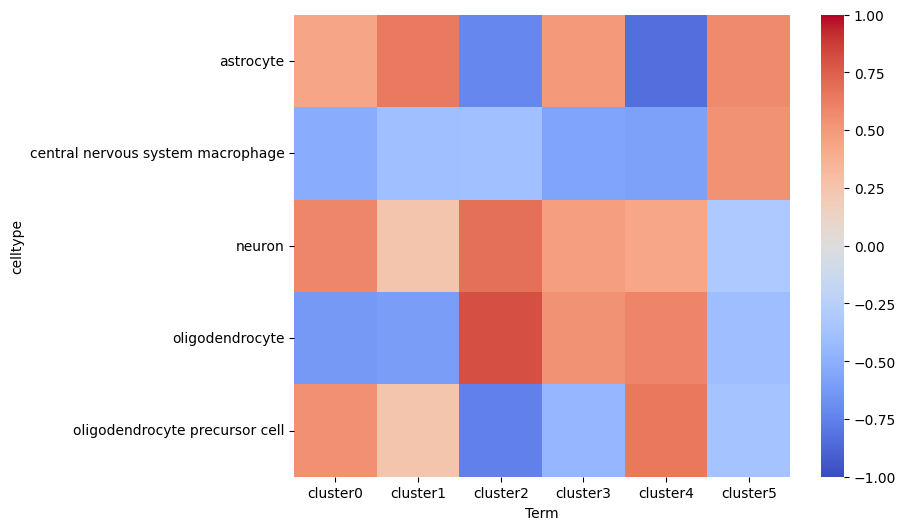

In [110]:
import seaborn as sns
fig = plt.figure(figsize=(8, 6))
es_df = enrich_df.pivot(index='Term', columns='celltype', values='ES')
sns.heatmap(es_df.astype(float).T, cmap='coolwarm', center=0, vmin=-1, vmax=1)

### EdgeR

Run enrichment for genesets

In [111]:
enrich_df = enrich_celltypes(res_edgeR, gene_sets, gene_col='names', score_col='score', method='score', gsea_kw={'verbose': True})
enrich_df.head(2)

  0%|          | 0/5 [00:00<?, ?it/s]

2024-07-15 16:34:35,875 [WARNING] Duplicated values found in preranked stats: 0.16% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-15 16:34:35,875 [INFO] Parsing data files for GSEA.............................
2024-07-15 16:34:35,875 [INFO] 0000 gene_sets have been filtered out when max_size=1000 and min_size=0
2024-07-15 16:34:35,875 [INFO] 0006 gene_sets used for further statistical testing.....
2024-07-15 16:34:35,875 [INFO] Start to run GSEA...Might take a while..................
2024-07-15 16:34:36,566 [INFO] Congratulations. GSEApy runs successfully................

2024-07-15 16:34:36,583 [WARNING] Duplicated values found in preranked stats: 0.19% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-15 16:34:36,583 [INFO] Parsing data files for GSEA.............................
2024-07-15 16:34:36,592 [INFO] 0000 gene_sets have been filtered out when max_size=1000 and min_size=0
20

Name      Term        ES       NES NOM p-val FDR q-val FWER p-val Tag %  \
0  prerank  cluster2 -0.820259 -1.763274  0.002809  0.009751   0.010101   4/7   
1  prerank  cluster4 -0.600035  -1.31188  0.164671   0.18039    0.32211   6/8   

   Gene %                              Lead_genes   celltype  
0  15.24%                  GNAI1;NUAK1;OLA1;KLHL2  astrocyte  
1  28.78%  IGSF21;ATP1A3;CLSTN1;PTPRK;VAT1L;ALCAM  astrocyte

Process enrichment results

In [112]:
process_enrichment_df(enrich_df)
enrich_df.head(2)

Name      Term        ES       NES NOM p-val FDR q-val FWER p-val Tag %  \
0  prerank  cluster2 -0.820259 -1.763274  0.002809  0.009751   0.010101   4/7   
1  prerank  cluster4 -0.600035  -1.31188  0.164671   0.18039    0.32211   6/8   

   Gene %                              Lead_genes   celltype  -log10(FDR)  \
0  15.24%                  GNAI1;NUAK1;OLA1;KLHL2  astrocyte     1.968559   
1  28.78%  IGSF21;ATP1A3;CLSTN1;PTPRK;VAT1L;ALCAM  astrocyte     0.741387   

  direction  significant  
0  depleted   FDR < 0.05  
1  depleted  FDR >= 0.05

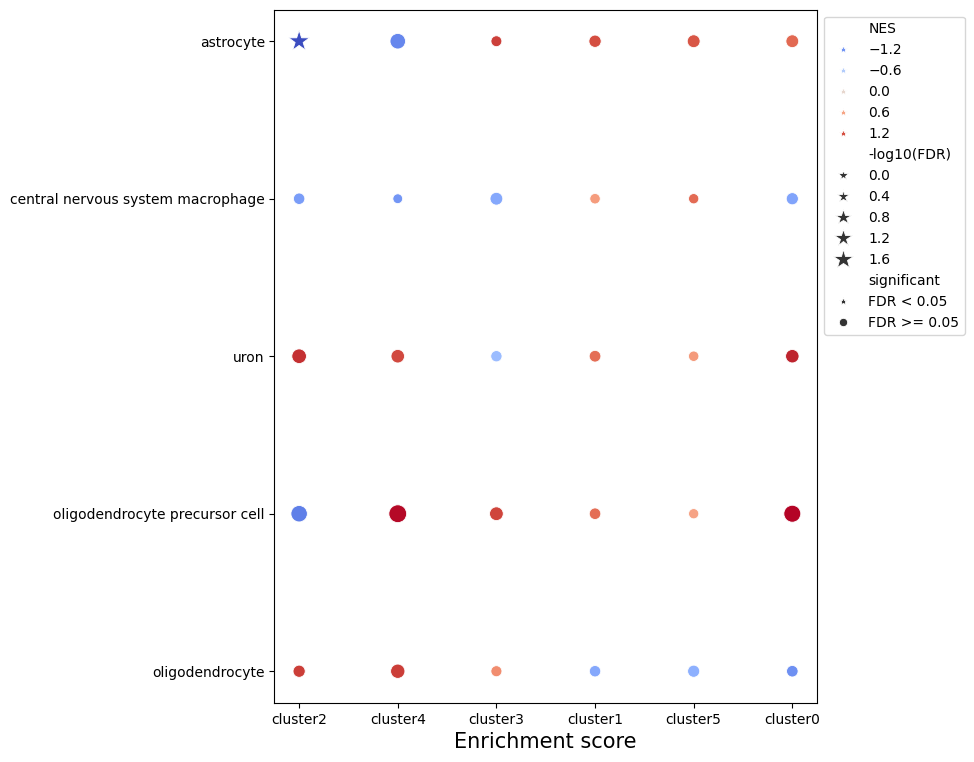

In [113]:
mpl.rcdefaults()
palette = sns.color_palette("coolwarm", as_cmap=True)

enrichment_plot(
    enrich_res=enrich_df,
    x='Term',
    y='celltype',
    size='-log10(FDR)',
    sizes=(50, 250),
    hue='NES',
    palette=palette,
    style='significant',
    markers={'FDR < 0.05': '*', 'FDR >= 0.05': 'o'}
)

C:\Users\claptar\AppData\Local\Temp\ipykernel_18644\2110194606.py:6: UserWarning: The palette list has more values (12) than needed (6), which may not be intended.
  ax = sns.scatterplot(data=enrich_res.reset_index(), **kw_scatterplot)


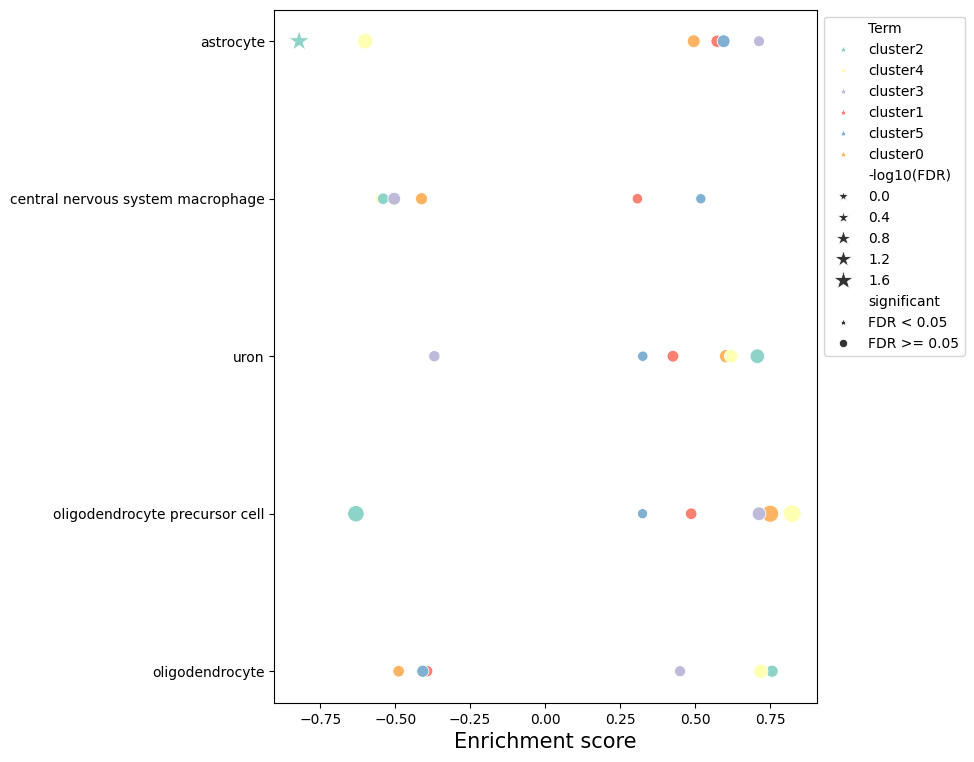

In [114]:
mpl.rcdefaults()
palette = sns.color_palette("Set3")

enrichment_plot(
    enrich_res=enrich_df,
    x='ES',
    y='celltype',
    size='-log10(FDR)',
    sizes=(50, 250),
    hue='Term',
    palette=palette,
    style='significant',
    markers={'FDR < 0.05': '*', 'FDR >= 0.05': 'o'}
)

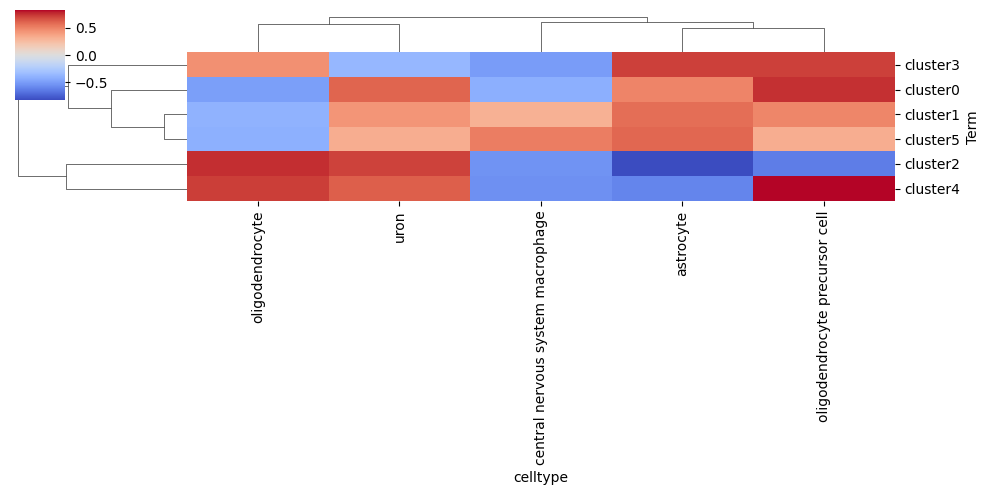

In [115]:
import seaborn as sns
es_df = enrich_df.pivot(index='Term', columns='celltype', values='ES')
sns.clustermap(es_df.astype(float), figsize=(10, 5), cmap='coolwarm', center=0)

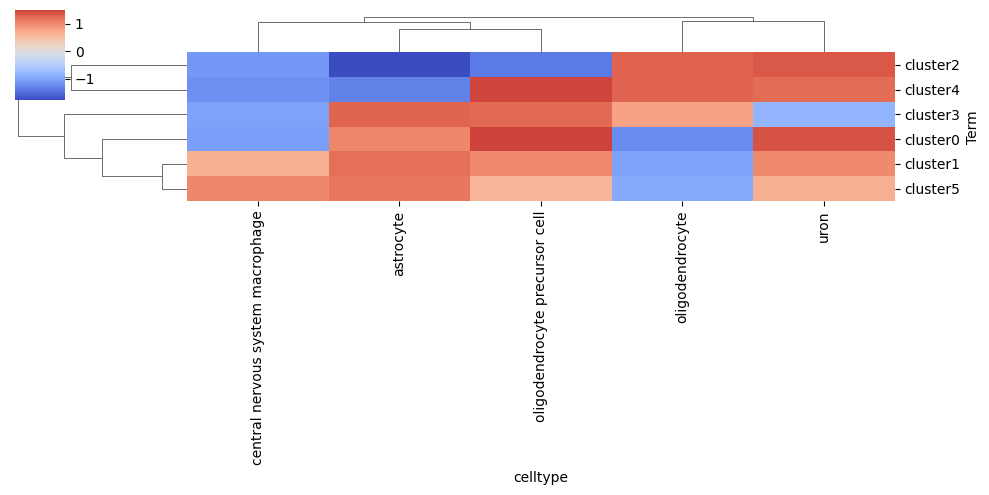

In [116]:
es_df = enrich_df.pivot(index='Term', columns='celltype', values='NES')
sns.clustermap(es_df.astype(float), figsize=(10, 5), cmap='coolwarm', center=0)

<Axes: xlabel='Term', ylabel='celltype'>

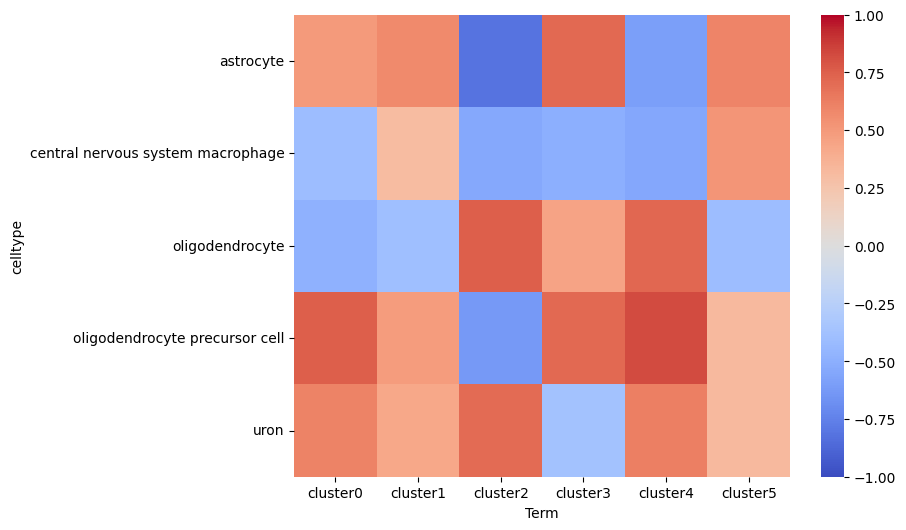

In [117]:
import seaborn as sns
fig = plt.figure(figsize=(8, 6))
es_df = enrich_df.pivot(index='Term', columns='celltype', values='ES')
sns.heatmap(es_df.astype(float).T, cmap='coolwarm', center=0, vmin=-1, vmax=1)

### EdgeR (logFC)

Run enrichment for genesets

In [118]:
enrich_df = enrich_celltypes(res_edgeR, gene_sets, gene_col='names', score_col='logFC', method='score', gsea_kw={'verbose': True})
enrich_df.head(2)

  0%|          | 0/5 [00:00<?, ?it/s]

2024-07-15 16:34:40,242 [INFO] Parsing data files for GSEA.............................
2024-07-15 16:34:40,242 [INFO] 0000 gene_sets have been filtered out when max_size=1000 and min_size=0
2024-07-15 16:34:40,242 [INFO] 0006 gene_sets used for further statistical testing.....
2024-07-15 16:34:40,242 [INFO] Start to run GSEA...Might take a while..................
2024-07-15 16:34:40,900 [INFO] Congratulations. GSEApy runs successfully................

2024-07-15 16:34:40,908 [INFO] Parsing data files for GSEA.............................
2024-07-15 16:34:40,917 [INFO] 0000 gene_sets have been filtered out when max_size=1000 and min_size=0
2024-07-15 16:34:40,917 [INFO] 0006 gene_sets used for further statistical testing.....
2024-07-15 16:34:40,917 [INFO] Start to run GSEA...Might take a while..................
2024-07-15 16:34:41,583 [INFO] Congratulations. GSEApy runs successfully................

2024-07-15 16:34:41,600 [INFO] Parsing data files for GSEA............................

Name      Term        ES       NES NOM p-val FDR q-val FWER p-val Tag %  \
0  prerank  cluster4 -0.765442 -1.566318  0.016878  0.041857   0.056818   4/8   
1  prerank  cluster2 -0.768676 -1.554603  0.023605  0.024734   0.066116   2/7   

   Gene %                 Lead_genes   celltype  
0  10.05%  IGSF21;ATP1A3;VAT1L;PTPRK  astrocyte  
1   2.89%                GNAI1;NUAK1  astrocyte

Process enrichment results

In [119]:
process_enrichment_df(enrich_df)
enrich_df.head(2)

Name      Term        ES       NES NOM p-val FDR q-val FWER p-val Tag %  \
0  prerank  cluster4 -0.765442 -1.566318  0.016878  0.041857   0.056818   4/8   
1  prerank  cluster2 -0.768676 -1.554603  0.023605  0.024734   0.066116   2/7   

   Gene %                 Lead_genes   celltype  -log10(FDR) direction  \
0  10.05%  IGSF21;ATP1A3;VAT1L;PTPRK  astrocyte     1.367979  depleted   
1   2.89%                GNAI1;NUAK1  astrocyte     1.589499  depleted   

  significant  
0  FDR < 0.05  
1  FDR < 0.05

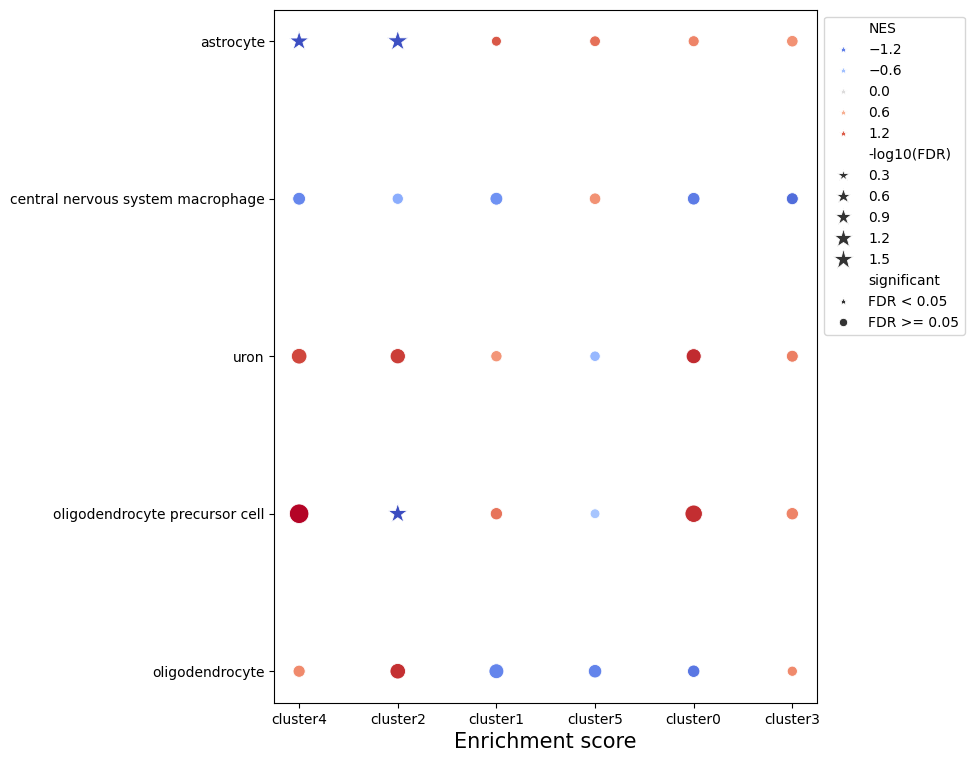

In [120]:
mpl.rcdefaults()
palette = sns.color_palette("coolwarm", as_cmap=True)

enrichment_plot(
    enrich_res=enrich_df,
    x='Term',
    y='celltype',
    size='-log10(FDR)',
    sizes=(50, 250),
    hue='NES',
    palette=palette,
    style='significant',
    markers={'FDR < 0.05': '*', 'FDR >= 0.05': 'o'}
)

C:\Users\claptar\AppData\Local\Temp\ipykernel_18644\2110194606.py:6: UserWarning: The palette list has more values (12) than needed (6), which may not be intended.
  ax = sns.scatterplot(data=enrich_res.reset_index(), **kw_scatterplot)


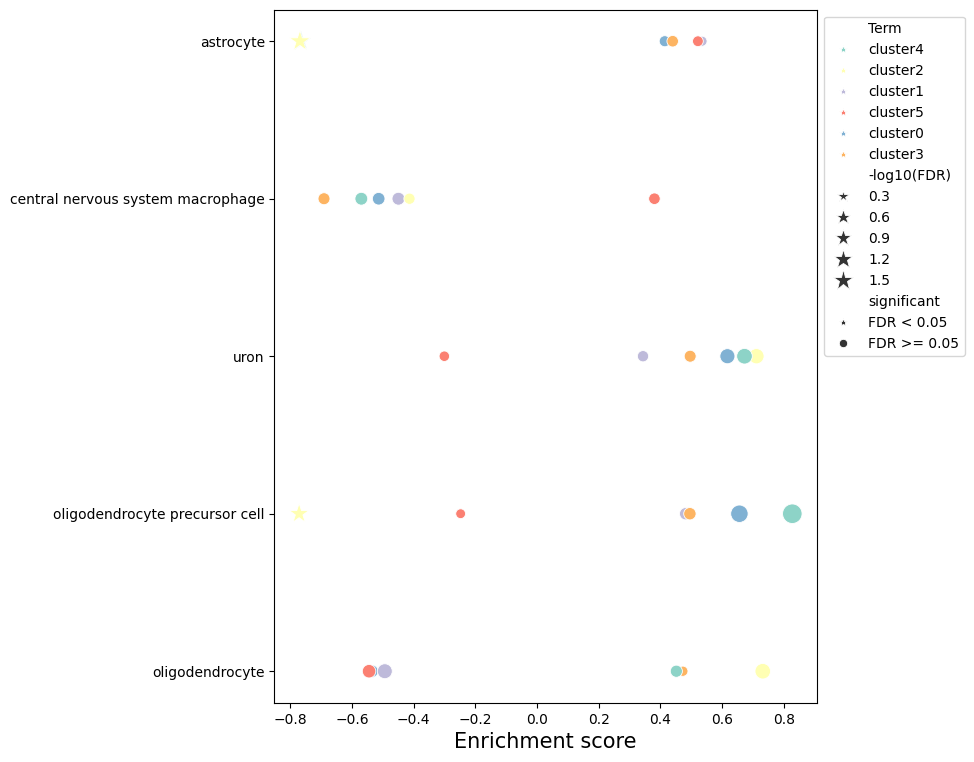

In [121]:
mpl.rcdefaults()
palette = sns.color_palette("Set3")

enrichment_plot(
    enrich_res=enrich_df,
    x='ES',
    y='celltype',
    size='-log10(FDR)',
    sizes=(50, 250),
    hue='Term',
    palette=palette,
    style='significant',
    markers={'FDR < 0.05': '*', 'FDR >= 0.05': 'o'}
)

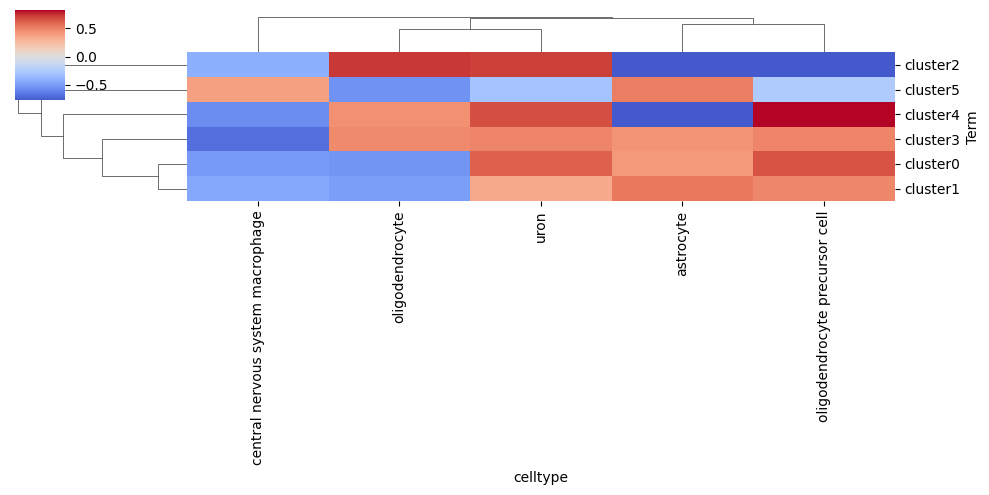

In [122]:
import seaborn as sns
es_df = enrich_df.pivot(index='Term', columns='celltype', values='ES')
sns.clustermap(es_df.astype(float), figsize=(10, 5), cmap='coolwarm', center=0)

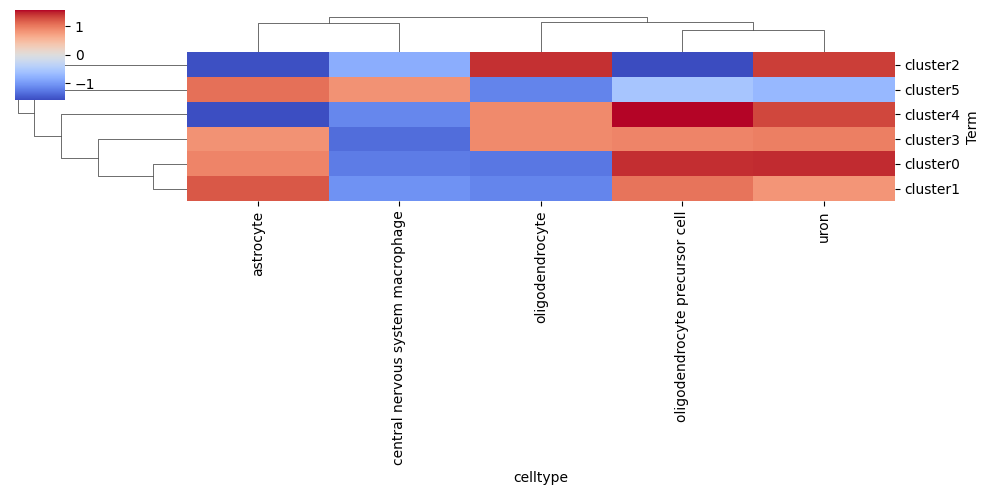

In [123]:
es_df = enrich_df.pivot(index='Term', columns='celltype', values='NES')
sns.clustermap(es_df.astype(float), figsize=(10, 5), cmap='coolwarm', center=0)

<Axes: xlabel='Term', ylabel='celltype'>

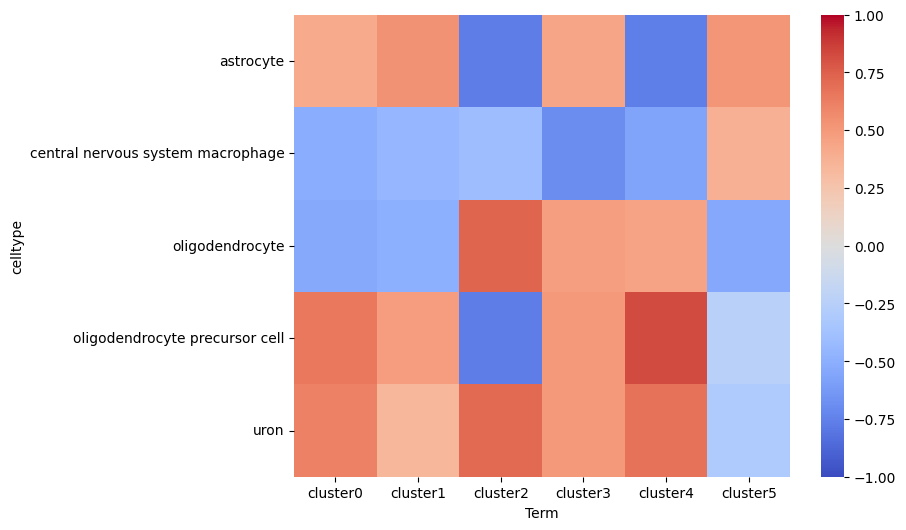

In [124]:
import seaborn as sns
fig = plt.figure(figsize=(8, 6))
es_df = enrich_df.pivot(index='Term', columns='celltype', values='ES')
sns.heatmap(es_df.astype(float).T, cmap='coolwarm', center=0, vmin=-1, vmax=1)

### Gene visualization

Calculate average normalized expression

In [125]:
for cell_type in gene_sets.keys():
    genes = scaled_adata.var_names.intersection(gene_sets[cell_type])
    scaled_adata.obs[f'{cell_type}_scaled'] = scaled_adata[:, genes].X.mean(axis=1)
scaled_adata.obs.head()

roi organism_ontology_term_id  \
CellID                                                           
10X227_5:AACGGGATCCGCTGTT  Human A24            NCBITaxon:9606   
10X227_5:ATCATTCAGGCTTAGG  Human A24            NCBITaxon:9606   
10X227_5:ACATCCCGTAGGAAAG  Human A24            NCBITaxon:9606   
10X227_5:CCATAAGTCCTGGCTT  Human A24            NCBITaxon:9606   
10X227_5:ATTCTTGGTACCAATC  Human A24            NCBITaxon:9606   

                          disease_ontology_term_id  \
CellID                                               
10X227_5:AACGGGATCCGCTGTT             PATO:0000461   
10X227_5:ATCATTCAGGCTTAGG             PATO:0000461   
10X227_5:ACATCCCGTAGGAAAG             PATO:0000461   
10X227_5:CCATAAGTCCTGGCTT             PATO:0000461   
10X227_5:ATTCTTGGTACCAATC             PATO:0000461   

                          self_reported_ethnicity_ontology_term_id  \
CellID                                                               
10X227_5:AACGGGATCCGCTGTT                           HANCESTRO:0005   
10X227_5:ATCATTCAGGCTTAGG                           HANCESTRO:0005   
10X227_5:ACATCCCGTAGGAAAG                           HANCESTRO:0005   
10X227_5:CCATAAGTCCTGGCTT                           HANCESTRO:0005   
10X227_5:ATTCTTGGTACCAATC                           HANCESTRO:0005   

                          assay_ontology_term_id sex_ontology_term_id  \
CellID                                                                  
10X227_5:AACGGGATCCGCTGTT            EFO:0009922         PATO:0000384   
10X227_5:ATCATTCAGGCTTAGG            EFO:0009922         PATO:0000384   
10X227_5:ACATCCCGTAGGAAAG            EFO:0009922         PATO:0000384   
10X227_5:CCATAAGTCCTGGCTT            EFO:0009922         PATO:0000384   
10X227_5:ATTCTTGGTACCAATC            EFO:0009922         PATO:0000384   

                          development_stage_ontology_term_id    donor_id  \
CellID                                                                     
10X227_5:AACGGGATCCGCTGTT                     HsapDv:0000144  H18.30.002   
10X227_5:ATCATTCAGGCTTAGG                     HsapDv:0000144  H18.30.002   
10X227_5:ACATCCCGTAGGAAAG                     HsapDv:0000144  H18.30.002   
10X227_5:CCATAAGTCCTGGCTT                     HsapDv:0000144  H18.30.002   
10X227_5:ATTCTTGGTACCAATC                     HsapDv:0000144  H18.30.002   

                          suspension_type  \
CellID                                      
10X227_5:AACGGGATCCGCTGTT         nucleus   
10X227_5:ATCATTCAGGCTTAGG         nucleus   
10X227_5:ACATCCCGTAGGAAAG         nucleus   
10X227_5:CCATAAGTCCTGGCTT         nucleus   
10X227_5:ATTCTTGGTACCAATC         nucleus   

                                                                  dissection  \
CellID                                                                         
10X227_5:AACGGGATCCGCTGTT  Cerebral cortex (Cx) - Cingulate gyrus, rostra...   
10X227_5:ATCATTCAGGCTTAGG  Cerebral cortex (Cx) - Cingulate gyrus, rostra...   
10X227_5:ACATCCCGTAGGAAAG  Cerebral cortex (Cx) - Cingulate gyrus, rostra...   
10X227_5:CCATAAGTCCTGGCTT  Cerebral cortex (Cx) - Cingulate gyrus, rostra...   
10X227_5:ATTCTTGGTACCAATC  Cerebral cortex (Cx) - Cingulate gyrus, rostra...   

                           ...  age-specific_scaled  \
CellID                     ...                        
10X227_5:AACGGGATCCGCTGTT  ...             0.130140   
10X227_5:ATCATTCAGGCTTAGG  ...            -0.459783   
10X227_5:ACATCCCGTAGGAAAG  ...            -0.420267   
10X227_5:CCATAAGTCCTGGCTT  ...            -0.366426   
10X227_5:ATTCTTGGTACCAATC  ...            -0.216217   

                           maybe age-specific_scaled  \
CellID                                                 
10X227_5:AACGGGATCCGCTGTT                  -0.112366   
10X227_5:ATCATTCAGGCTTAGG                   0.013721   
10X227_5:ACATCCCGTAGGAAAG                  -0.172398   
10X227_5:CCATAAGTCCTGGCTT                  -0.311726   
10X227_5:ATTCTTGGTACCAATC                  -0.171606   


Vusualize

In [126]:
scaled_adata.obs.columns

Index(['roi', 'organism_ontology_term_id', 'disease_ontology_term_id',
       'self_reported_ethnicity_ontology_term_id', 'assay_ontology_term_id',
       'sex_ontology_term_id', 'development_stage_ontology_term_id',
       'donor_id', 'suspension_type', 'dissection', 'fraction_mitochondrial',
       'fraction_unspliced', 'cell_cycle_score', 'total_genes', 'total_UMIs',
       'sample_id', 'supercluster_term', 'cluster_id', 'subcluster_id',
       'cell_type_ontology_term_id', 'tissue_ontology_term_id',
       'is_primary_data', 'tissue_type', 'cell_type', 'assay', 'disease',
       'organism', 'sex', 'tissue', 'self_reported_ethnicity',
       'development_stage', 'observation_joinid', 'All HS genes',
       'age-specific_scaled', 'maybe age-specific_scaled',
       'maybe human-specific_scaled', 'human-specific_scaled',
       'cluster0_scaled', 'cluster1_scaled', 'cluster2_scaled',
       'cluster3_scaled', 'cluster4_scaled', 'cluster5_scaled'],
      dtype='object')

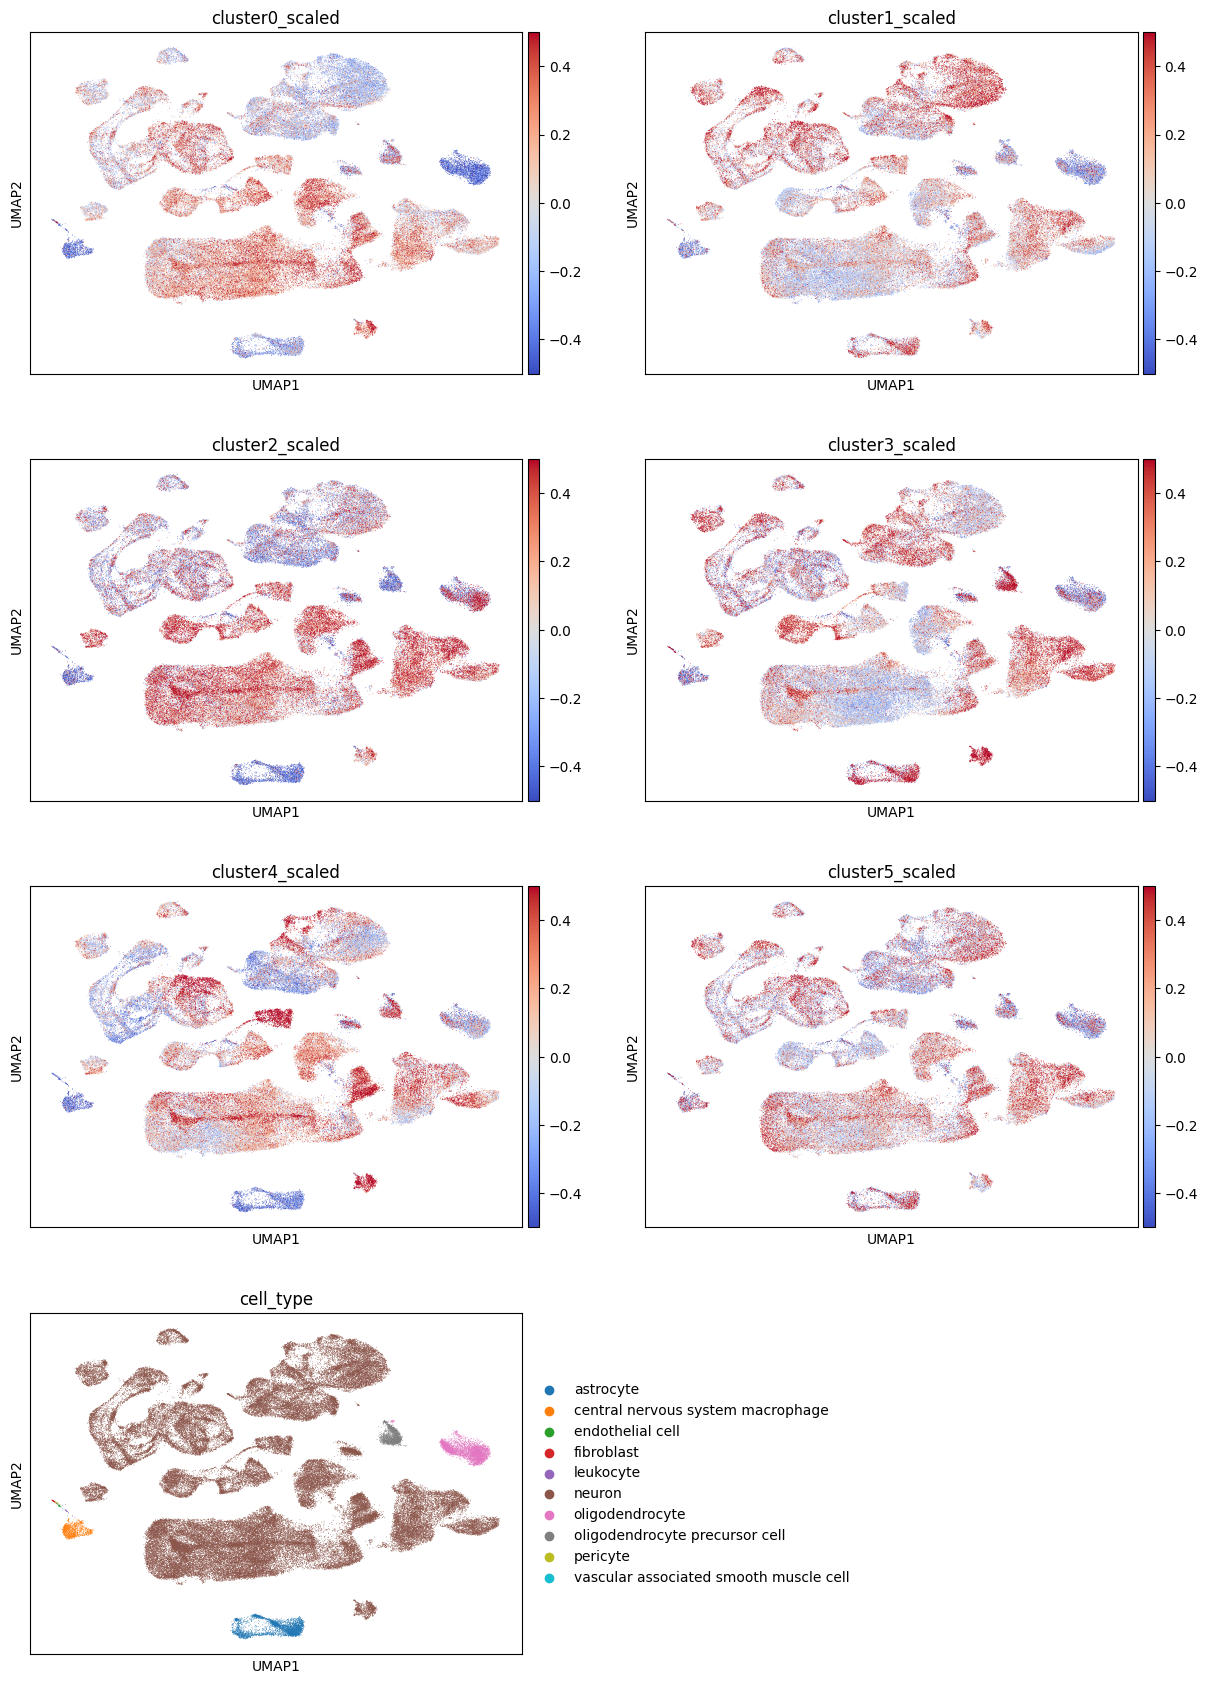

In [127]:
cmap = mpl.cm.coolwarm
norm = mpl.colors.TwoSlopeNorm(vcenter=0, vmax=0.5, vmin=-0.5)
color = [
    'cluster0_scaled', 
    'cluster1_scaled',
    'cluster2_scaled', 
    'cluster3_scaled', 
    'cluster4_scaled',
    'cluster5_scaled', 
    'cell_type'
    ]

sc.pl.umap(scaled_adata, color=color, cmap=cmap, norm=norm, ncols=2)

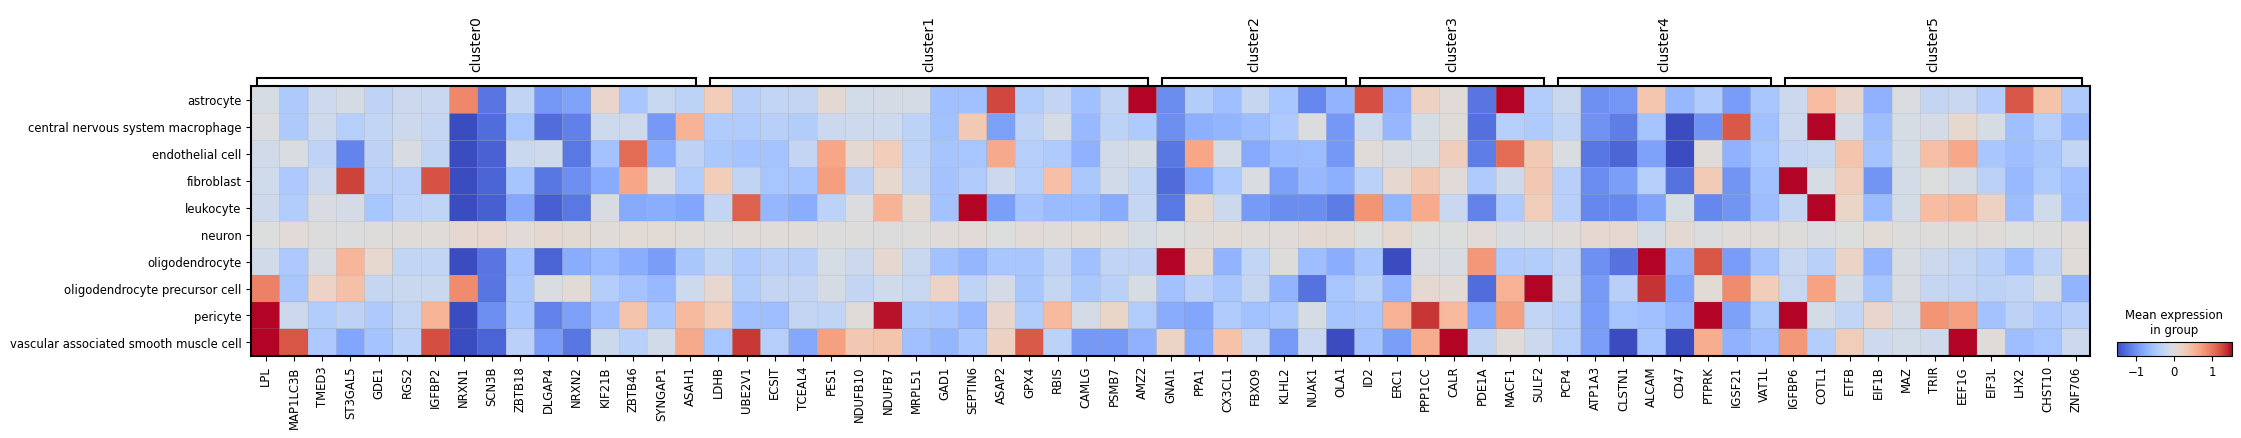

In [128]:
cmap = mpl.cm.coolwarm
norm = mpl.colors.TwoSlopeNorm(vcenter=0, vmax=1.5, vmin=-1.5)
gene_sets_inter = {key: scaled_adata.var_names.intersection(value) for key, value in gene_sets.items()}

sc.pl.matrixplot(scaled_adata, gene_sets_inter, groupby='cell_type', cmap='coolwarm', norm=norm)

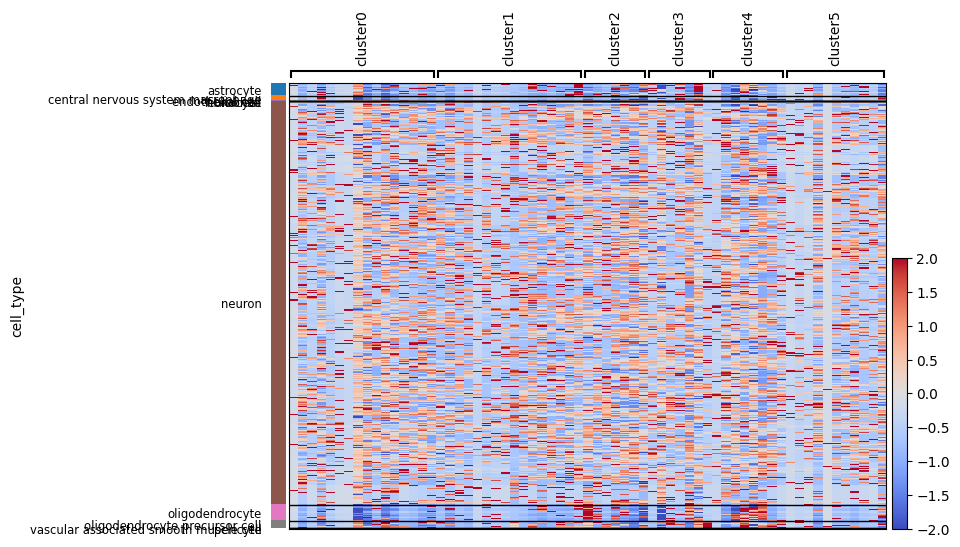

In [129]:
cmap = mpl.cm.coolwarm
norm = mpl.colors.TwoSlopeNorm(vcenter=0, vmax=2, vmin=-2)
gene_sets_inter = {key: scaled_adata.var_names.intersection(value) for key, value in gene_sets.items()}

sc.pl.heatmap(scaled_adata, gene_sets_inter, groupby='cell_type', cmap='coolwarm', norm=norm)

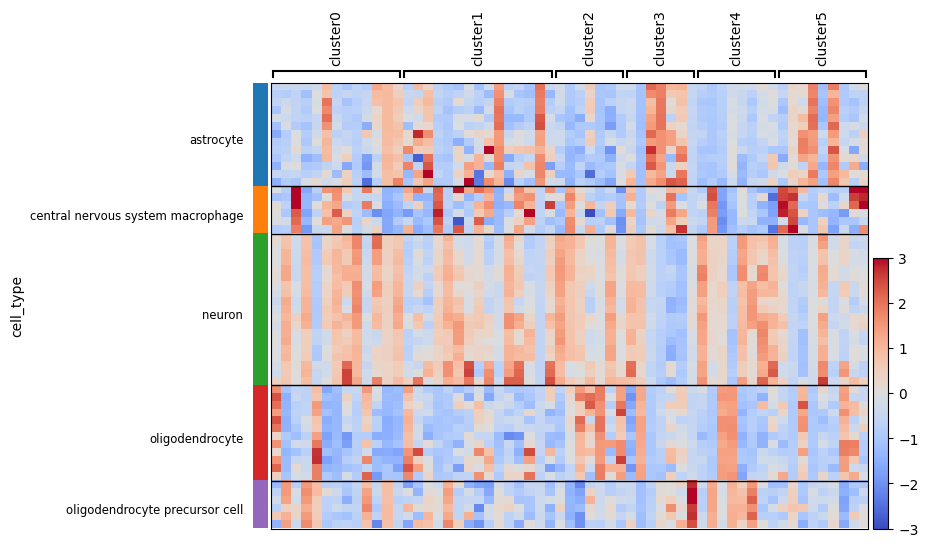

In [130]:
cmap = mpl.cm.coolwarm
norm = mpl.colors.TwoSlopeNorm(vcenter=0)
gene_sets_inter = {key: scaled_adata_pb.var_names.intersection(value) for key, value in gene_sets.items()}

sc.pl.heatmap(scaled_adata_pb, gene_sets_inter, groupby='cell_type', cmap='coolwarm', vcenter=0, vmin=-3, vmax=3)

## Enrichment for chimp-specific genes

Create a dict with genesets

In [131]:
geneset = {'chimp-specific genes': chimp_specific_genes}

### T-test

Specify DE test

In [132]:
key = 't-test'

Run enrichment for genesets

In [133]:
enrich_df = enrich_celltypes(celltypes, geneset, adata=adata_pb, key=key, gene_col='names', score_col='scores', method='score', gsea_kw={'verbose': False})
enrich_df.head(2)

  0%|          | 0/5 [00:00<?, ?it/s]

2024-07-15 16:34:49,980 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-15 16:34:50,493 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-15 16:34:50,954 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-15 16:34:51,396 [WARNING] Duplicated values found in preranked stats: 0.03% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


Name                  Term        ES       NES NOM p-val FDR q-val  \
0  prerank  chimp-specific genes  0.622793   1.41355  0.103825  0.103825   
0  prerank  chimp-specific genes -0.397566 -0.988561  0.461197  0.461197   

  FWER p-val Tag %  Gene %                      Lead_genes  \
0      0.057  4/11   7.45%      TPD52L1;SLC1A3;BCL6;SEMA3A   
0   0.461197  5/11  20.72%  SPARC;ANK3;SEMA3A;BCL6;TPD52L1   

                            celltype  
0                          astrocyte  
0  central nervous system macrophage

Process enrichment results

In [134]:
process_enrichment_df(enrich_df)
enrich_df.head(2)

Name                  Term        ES       NES NOM p-val FDR q-val  \
0  prerank  chimp-specific genes  0.622793   1.41355  0.103825  0.103825   
0  prerank  chimp-specific genes -0.397566 -0.988561  0.461197  0.461197   

  FWER p-val Tag %  Gene %                      Lead_genes  \
0      0.057  4/11   7.45%      TPD52L1;SLC1A3;BCL6;SEMA3A   
0   0.461197  5/11  20.72%  SPARC;ANK3;SEMA3A;BCL6;TPD52L1   

                            celltype  -log10(FDR) direction  significant  
0                          astrocyte     0.979535  enriched  FDR >= 0.05  
0  central nervous system macrophage     0.335173  depleted  FDR >= 0.05

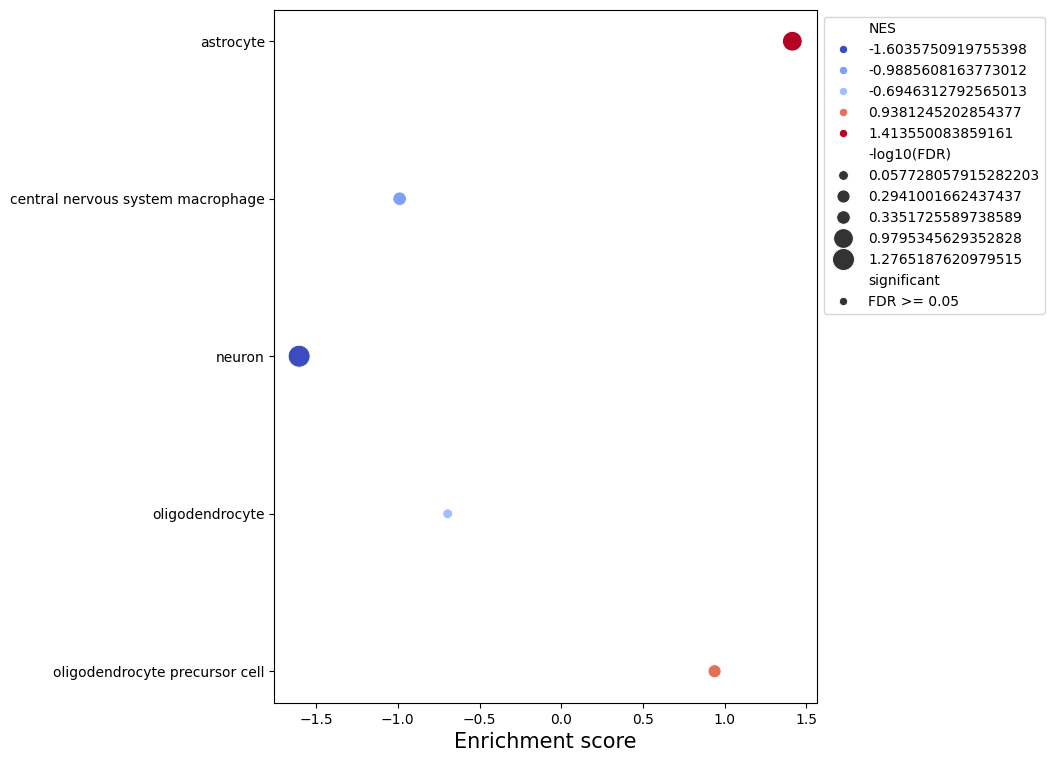

In [135]:
mpl.rcdefaults()
palette = sns.color_palette("coolwarm", as_cmap=True)

enrichment_plot(
    enrich_res=enrich_df,
    x='NES',
    y='celltype',
    size='-log10(FDR)',
    sizes=(50, 250),
    hue='NES',
    palette=palette,
    style='significant',
    markers={'FDR < 0.05': '*', 'FDR >= 0.05': 'o'}
)

### Wilcoxon

Specify DE test

In [136]:
key = 'wilcoxon'

Run enrichment for genesets

In [137]:
enrich_df = enrich_celltypes(celltypes, geneset, adata=adata_pb, key=key, gene_col='names', score_col='scores', method='lfc_product', gsea_kw={'verbose': False})
enrich_df.head(2)

  0%|          | 0/5 [00:00<?, ?it/s]

2024-07-15 16:34:52,565 [WARNING] Duplicated values found in preranked stats: 0.35% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-15 16:34:53,456 [WARNING] Duplicated values found in preranked stats: 0.23% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-15 16:34:53,922 [WARNING] Duplicated values found in preranked stats: 0.69% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


Name                  Term        ES       NES NOM p-val FDR q-val  \
0  prerank  chimp-specific genes  0.622383  1.172655  0.263393  0.263393   
0  prerank  chimp-specific genes  -0.59982 -1.107408  0.354103  0.354103   

  FWER p-val Tag %  Gene %                      Lead_genes  \
0      0.118  4/11   6.42%      TPD52L1;SLC1A3;BCL6;SEMA3A   
0   0.354103  5/11  18.21%  SPARC;TPD52L1;ANK3;BCL6;SEMA3A   

                            celltype  
0                          astrocyte  
0  central nervous system macrophage

Process enrichment results

In [138]:
process_enrichment_df(enrich_df)
enrich_df.head(2)

Name                  Term        ES       NES NOM p-val FDR q-val  \
0  prerank  chimp-specific genes  0.622383  1.172655  0.263393  0.263393   
0  prerank  chimp-specific genes  -0.59982 -1.107408  0.354103  0.354103   

  FWER p-val Tag %  Gene %                      Lead_genes  \
0      0.118  4/11   6.42%      TPD52L1;SLC1A3;BCL6;SEMA3A   
0   0.354103  5/11  18.21%  SPARC;TPD52L1;ANK3;BCL6;SEMA3A   

                            celltype  -log10(FDR) direction  significant  
0                          astrocyte     0.577750  enriched  FDR >= 0.05  
0  central nervous system macrophage     0.449645  depleted  FDR >= 0.05

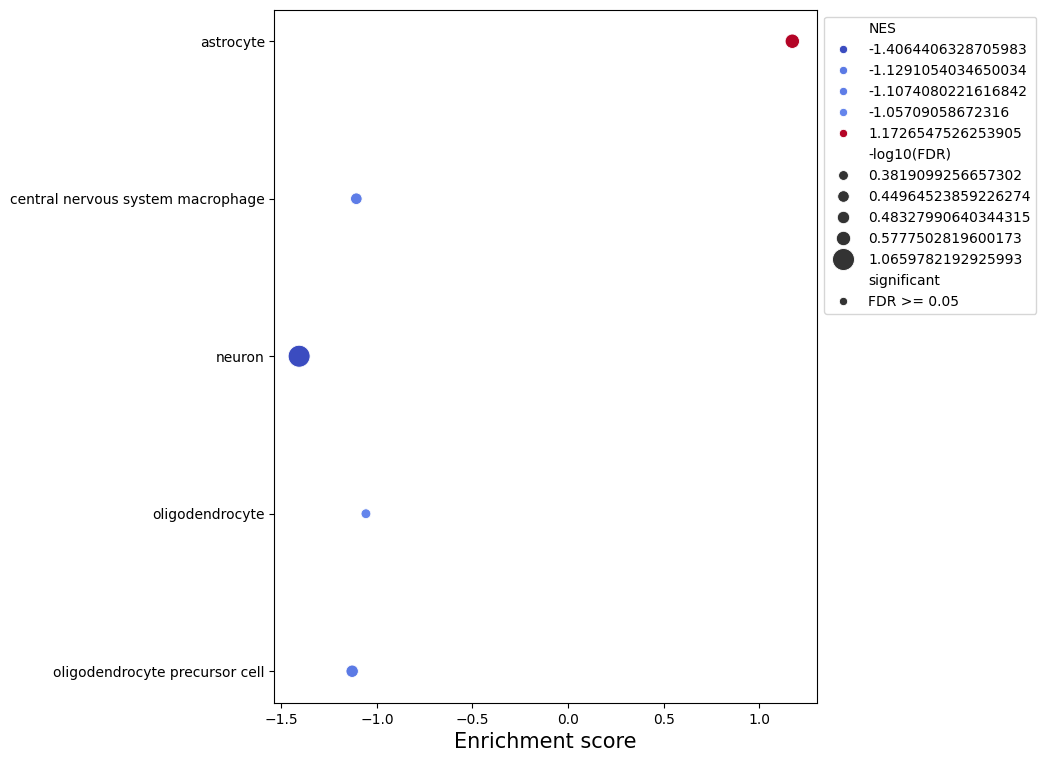

In [139]:
mpl.rcdefaults()
palette = sns.color_palette("coolwarm", as_cmap=True)

enrichment_plot(
    enrich_res=enrich_df,
    x='NES',
    y='celltype',
    size='-log10(FDR)',
    sizes=(50, 250),
    hue='NES',
    palette=palette,
    style='significant',
    markers={'FDR < 0.05': '*', 'FDR >= 0.05': 'o'}
)

### Logreg

Specify DE test

In [140]:
key = 'logreg'

Run enrichment for genesets

In [141]:
enrich_df = enrich_celltypes(celltypes, geneset, adata=adata_pb, key=key, gene_col='names', score_col='scores', method='score', gsea_kw={'verbose': False})
enrich_df.head(2)

  0%|          | 0/5 [00:00<?, ?it/s]

2024-07-15 16:34:55,941 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-15 16:34:56,378 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


Name                  Term        ES       NES NOM p-val FDR q-val  \
0  prerank  chimp-specific genes   0.64823  1.233241  0.247036  0.247036   
0  prerank  chimp-specific genes -0.443004 -0.933373  0.538636  0.538636   

  FWER p-val Tag %  Gene %                         Lead_genes  \
0      0.125  5/11   7.48%  SLC1A3;TPD52L1;BCL6;SEMA3A;RIPOR2   
0   0.538636  5/11  13.19%     ANK3;TPD52L1;BCL6;SPARC;SEMA3A   

                            celltype  
0                          astrocyte  
0  central nervous system macrophage

Process enrichment results

In [142]:
process_enrichment_df(enrich_df)
enrich_df.head(2)

Name                  Term        ES       NES NOM p-val FDR q-val  \
0  prerank  chimp-specific genes   0.64823  1.233241  0.247036  0.247036   
0  prerank  chimp-specific genes -0.443004 -0.933373  0.538636  0.538636   

  FWER p-val Tag %  Gene %                         Lead_genes  \
0      0.125  5/11   7.48%  SLC1A3;TPD52L1;BCL6;SEMA3A;RIPOR2   
0   0.538636  5/11  13.19%     ANK3;TPD52L1;BCL6;SPARC;SEMA3A   

                            celltype  -log10(FDR) direction  significant  
0                          astrocyte     0.605486  enriched  FDR >= 0.05  
0  central nervous system macrophage     0.267899  depleted  FDR >= 0.05

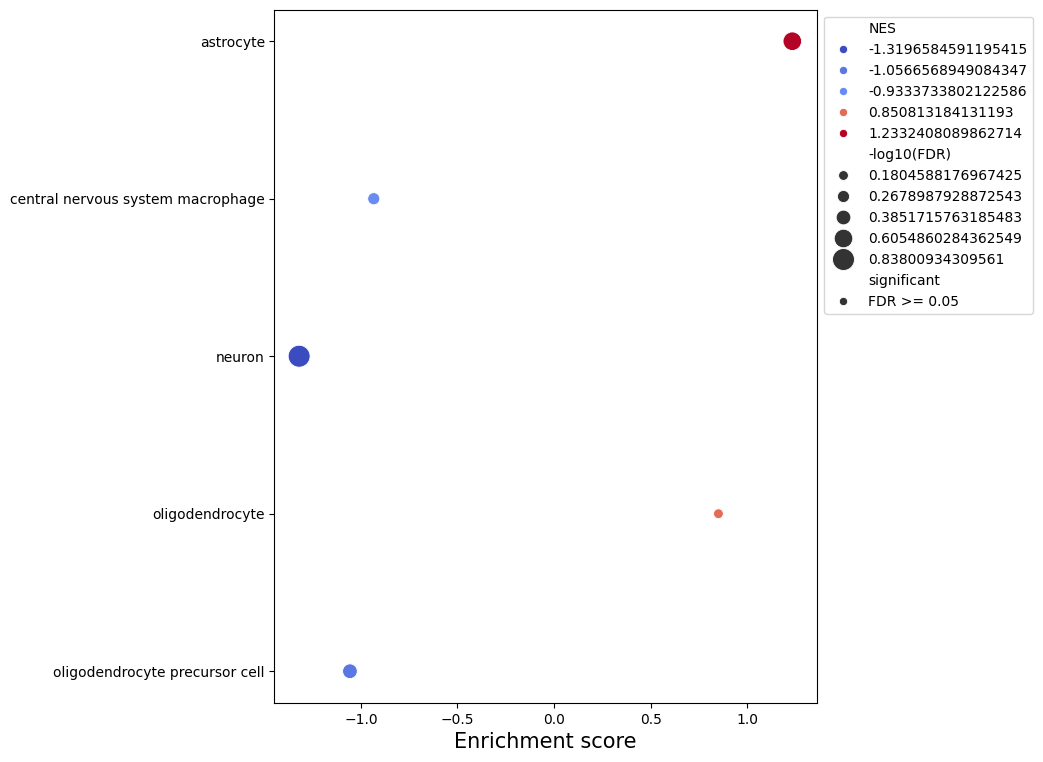

In [143]:
mpl.rcdefaults()
palette = sns.color_palette("coolwarm", as_cmap=True)

enrichment_plot(
    enrich_res=enrich_df,
    x='NES',
    y='celltype',
    size='-log10(FDR)',
    sizes=(50, 250),
    hue='NES',
    palette=palette,
    style='significant',
    markers={'FDR < 0.05': '*', 'FDR >= 0.05': 'o'}
)

### EdgeR

Run enrichment for genesets

In [144]:
enrich_df = enrich_celltypes(res_edgeR, geneset, gene_col='names', score_col='score', method='score', gsea_kw={'verbose': True})
enrich_df.head(2)

  0%|          | 0/5 [00:00<?, ?it/s]

2024-07-15 16:34:57,031 [WARNING] Duplicated values found in preranked stats: 0.16% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-15 16:34:57,033 [INFO] Parsing data files for GSEA.............................
2024-07-15 16:34:57,036 [INFO] 0000 gene_sets have been filtered out when max_size=1000 and min_size=0
2024-07-15 16:34:57,036 [INFO] 0001 gene_sets used for further statistical testing.....
2024-07-15 16:34:57,036 [INFO] Start to run GSEA...Might take a while..................
2024-07-15 16:34:57,544 [INFO] Congratulations. GSEApy runs successfully................

2024-07-15 16:34:57,558 [WARNING] Duplicated values found in preranked stats: 0.19% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-07-15 16:34:57,558 [INFO] Parsing data files for GSEA.............................
2024-07-15 16:34:57,564 [INFO] 0000 gene_sets have been filtered out when max_size=1000 and min_size=0
20

Name                  Term        ES       NES NOM p-val FDR q-val  \
0  prerank  chimp-specific genes  0.807007  1.642113  0.004093  0.004093   
0  prerank  chimp-specific genes  0.465916  0.982241  0.507246  0.507246   

  FWER p-val Tag % Gene %                                     Lead_genes  \
0      0.003  7/14  9.36%  SLC1A3;TPD52L1;BCL6;SEMA3A;MASP1;RIPOR2;HTRA1   
0      0.315  2/14  3.71%                                   SLC1A3;HTRA1   

                            celltype  
0                          astrocyte  
0  central nervous system macrophage

Process enrichment results

In [145]:
process_enrichment_df(enrich_df)
enrich_df.head(2)

Name                  Term        ES       NES NOM p-val FDR q-val  \
0  prerank  chimp-specific genes  0.807007  1.642113  0.004093  0.004093   
0  prerank  chimp-specific genes  0.465916  0.982241  0.507246  0.507246   

  FWER p-val Tag % Gene %                                     Lead_genes  \
0      0.003  7/14  9.36%  SLC1A3;TPD52L1;BCL6;SEMA3A;MASP1;RIPOR2;HTRA1   
0      0.315  2/14  3.71%                                   SLC1A3;HTRA1   

                            celltype  -log10(FDR) direction  significant  
0                          astrocyte     2.293046  enriched   FDR < 0.05  
0  central nervous system macrophage     0.293926  enriched  FDR >= 0.05

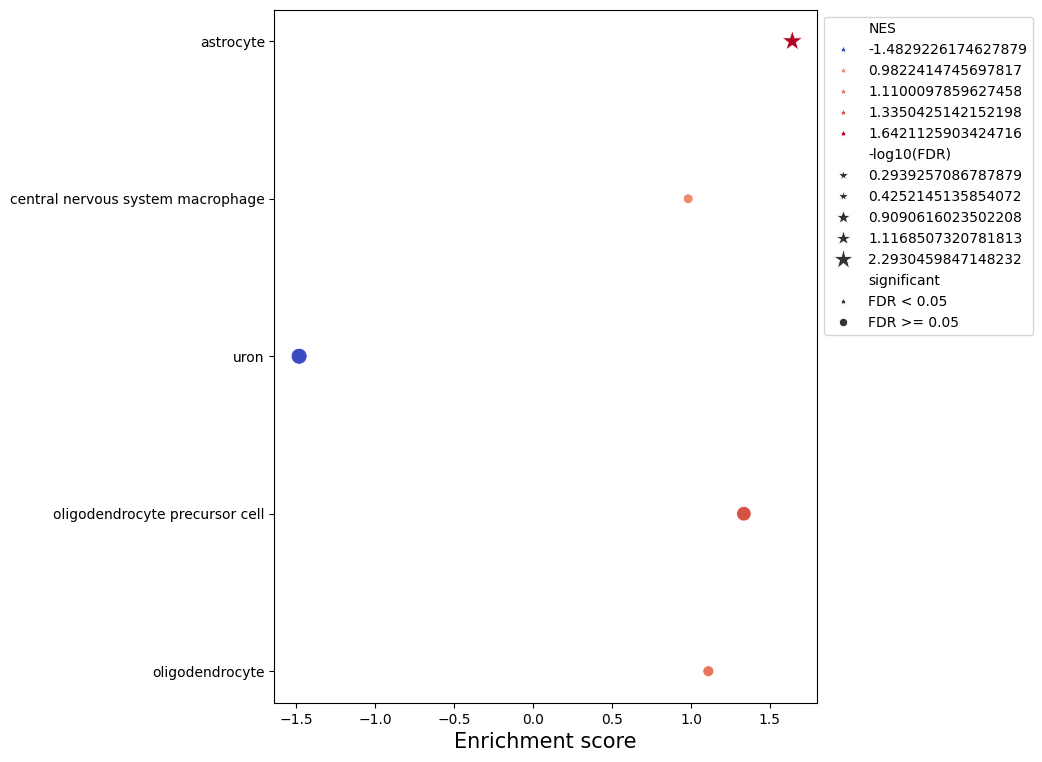

In [146]:
mpl.rcdefaults()
palette = sns.color_palette("coolwarm", as_cmap=True)

enrichment_plot(
    enrich_res=enrich_df,
    x='NES',
    y='celltype',
    size='-log10(FDR)',
    sizes=(50, 250),
    hue='NES',
    palette=palette,
    style='significant',
    markers={'FDR < 0.05': '*', 'FDR >= 0.05': 'o'}
)

### EdgeR (logFC)

Run enrichment for genesets

In [147]:
enrich_df = enrich_celltypes(res_edgeR, geneset, gene_col='names', score_col='logFC', method='score', gsea_kw={'verbose': True})
enrich_df.head(2)

  0%|          | 0/5 [00:00<?, ?it/s]

2024-07-15 16:35:00,112 [INFO] Parsing data files for GSEA.............................
2024-07-15 16:35:00,129 [INFO] 0000 gene_sets have been filtered out when max_size=1000 and min_size=0
2024-07-15 16:35:00,129 [INFO] 0001 gene_sets used for further statistical testing.....
2024-07-15 16:35:00,129 [INFO] Start to run GSEA...Might take a while..................
2024-07-15 16:35:00,643 [INFO] Congratulations. GSEApy runs successfully................

2024-07-15 16:35:00,648 [INFO] Parsing data files for GSEA.............................
2024-07-15 16:35:00,659 [INFO] 0000 gene_sets have been filtered out when max_size=1000 and min_size=0
2024-07-15 16:35:00,659 [INFO] 0001 gene_sets used for further statistical testing.....
2024-07-15 16:35:00,659 [INFO] Start to run GSEA...Might take a while..................
2024-07-15 16:35:01,121 [INFO] Congratulations. GSEApy runs successfully................

2024-07-15 16:35:01,136 [INFO] Parsing data files for GSEA............................

Name                  Term        ES       NES NOM p-val FDR q-val  \
0  prerank  chimp-specific genes  0.675494  1.483414  0.040493  0.040493   
0  prerank  chimp-specific genes -0.567558 -1.324485  0.147541  0.147541   

  FWER p-val Tag %  Gene %                               Lead_genes  \
0      0.023  6/14   5.26%  TPD52L1;SLC1A3;SEMA3A;BCL6;RIPOR2;MASP1   
0   0.147541  6/14  11.87%     ANK3;SPARC;TPD52L1;BCL6;SEMA3A;MASP1   

                            celltype  
0                          astrocyte  
0  central nervous system macrophage

Process enrichment results

In [148]:
process_enrichment_df(enrich_df)
enrich_df.head(2)

Name                  Term        ES       NES NOM p-val FDR q-val  \
0  prerank  chimp-specific genes  0.675494  1.483414  0.040493  0.040493   
0  prerank  chimp-specific genes -0.567558 -1.324485  0.147541  0.147541   

  FWER p-val Tag %  Gene %                               Lead_genes  \
0      0.023  6/14   5.26%  TPD52L1;SLC1A3;SEMA3A;BCL6;RIPOR2;MASP1   
0   0.147541  6/14  11.87%     ANK3;SPARC;TPD52L1;BCL6;SEMA3A;MASP1   

                            celltype  -log10(FDR) direction  significant  
0                          astrocyte     1.382026  enriched   FDR < 0.05  
0  central nervous system macrophage     0.828154  depleted  FDR >= 0.05

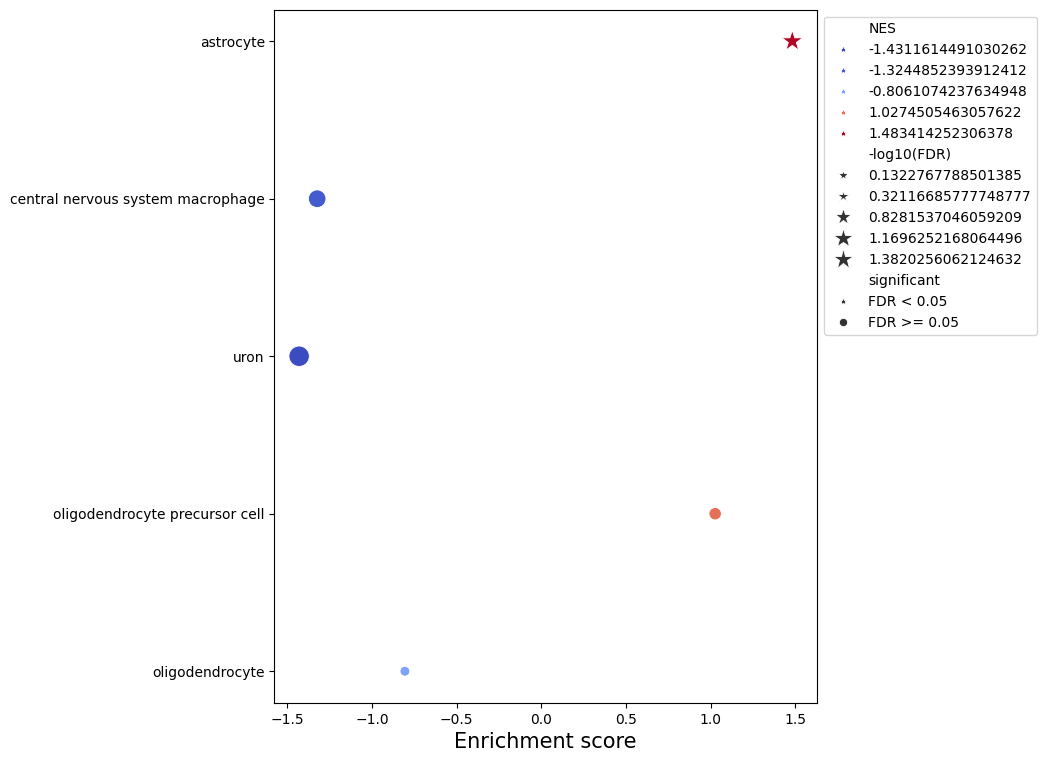

In [149]:
mpl.rcdefaults()
palette = sns.color_palette("coolwarm", as_cmap=True)

enrichment_plot(
    enrich_res=enrich_df,
    x='NES',
    y='celltype',
    size='-log10(FDR)',
    sizes=(50, 250),
    hue='NES',
    palette=palette,
    style='significant',
    markers={'FDR < 0.05': '*', 'FDR >= 0.05': 'o'}
)

### Gene visualization

Calculate average normalized expression

In [150]:
genes = scaled_adata.var_names.intersection(chimp_specific_genes)
scaled_adata.obs[f'chimp_specific_scaled'] = scaled_adata[:, genes].X.mean(axis=1)
scaled_adata.obs.head()

roi organism_ontology_term_id  \
CellID                                                           
10X227_5:AACGGGATCCGCTGTT  Human A24            NCBITaxon:9606   
10X227_5:ATCATTCAGGCTTAGG  Human A24            NCBITaxon:9606   
10X227_5:ACATCCCGTAGGAAAG  Human A24            NCBITaxon:9606   
10X227_5:CCATAAGTCCTGGCTT  Human A24            NCBITaxon:9606   
10X227_5:ATTCTTGGTACCAATC  Human A24            NCBITaxon:9606   

                          disease_ontology_term_id  \
CellID                                               
10X227_5:AACGGGATCCGCTGTT             PATO:0000461   
10X227_5:ATCATTCAGGCTTAGG             PATO:0000461   
10X227_5:ACATCCCGTAGGAAAG             PATO:0000461   
10X227_5:CCATAAGTCCTGGCTT             PATO:0000461   
10X227_5:ATTCTTGGTACCAATC             PATO:0000461   

                          self_reported_ethnicity_ontology_term_id  \
CellID                                                               
10X227_5:AACGGGATCCGCTGTT                           HANCESTRO:0005   
10X227_5:ATCATTCAGGCTTAGG                           HANCESTRO:0005   
10X227_5:ACATCCCGTAGGAAAG                           HANCESTRO:0005   
10X227_5:CCATAAGTCCTGGCTT                           HANCESTRO:0005   
10X227_5:ATTCTTGGTACCAATC                           HANCESTRO:0005   

                          assay_ontology_term_id sex_ontology_term_id  \
CellID                                                                  
10X227_5:AACGGGATCCGCTGTT            EFO:0009922         PATO:0000384   
10X227_5:ATCATTCAGGCTTAGG            EFO:0009922         PATO:0000384   
10X227_5:ACATCCCGTAGGAAAG            EFO:0009922         PATO:0000384   
10X227_5:CCATAAGTCCTGGCTT            EFO:0009922         PATO:0000384   
10X227_5:ATTCTTGGTACCAATC            EFO:0009922         PATO:0000384   

                          development_stage_ontology_term_id    donor_id  \
CellID                                                                     
10X227_5:AACGGGATCCGCTGTT                     HsapDv:0000144  H18.30.002   
10X227_5:ATCATTCAGGCTTAGG                     HsapDv:0000144  H18.30.002   
10X227_5:ACATCCCGTAGGAAAG                     HsapDv:0000144  H18.30.002   
10X227_5:CCATAAGTCCTGGCTT                     HsapDv:0000144  H18.30.002   
10X227_5:ATTCTTGGTACCAATC                     HsapDv:0000144  H18.30.002   

                          suspension_type  \
CellID                                      
10X227_5:AACGGGATCCGCTGTT         nucleus   
10X227_5:ATCATTCAGGCTTAGG         nucleus   
10X227_5:ACATCCCGTAGGAAAG         nucleus   
10X227_5:CCATAAGTCCTGGCTT         nucleus   
10X227_5:ATTCTTGGTACCAATC         nucleus   

                                                                  dissection  \
CellID                                                                         
10X227_5:AACGGGATCCGCTGTT  Cerebral cortex (Cx) - Cingulate gyrus, rostra...   
10X227_5:ATCATTCAGGCTTAGG  Cerebral cortex (Cx) - Cingulate gyrus, rostra...   
10X227_5:ACATCCCGTAGGAAAG  Cerebral cortex (Cx) - Cingulate gyrus, rostra...   
10X227_5:CCATAAGTCCTGGCTT  Cerebral cortex (Cx) - Cingulate gyrus, rostra...   
10X227_5:ATTCTTGGTACCAATC  Cerebral cortex (Cx) - Cingulate gyrus, rostra...   

                           ...  maybe age-specific_scaled  \
CellID                     ...                              
10X227_5:AACGGGATCCGCTGTT  ...                  -0.112366   
10X227_5:ATCATTCAGGCTTAGG  ...                   0.013721   
10X227_5:ACATCCCGTAGGAAAG  ...                  -0.172398   
10X227_5:CCATAAGTCCTGGCTT  ...                  -0.311726   
10X227_5:ATTCTTGGTACCAATC  ...                  -0.171606   

                           maybe human-specific_scaled  human-specific_scaled  \
CellID                                                                          
10X227_5:AACGGGATCCGCTGTT                     0.179321              -0.320138   
10X227_5:ATCATTCAGGCTTAGG                    -0.552547               0.032969   
10X227_5:ACATCCCGTAGGAAAG 

Vusualize

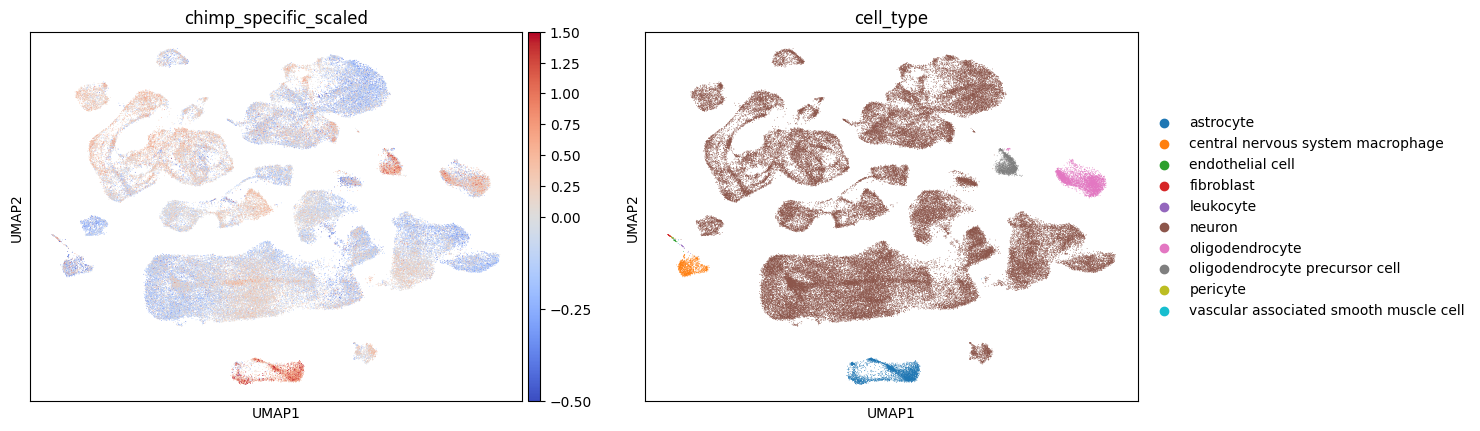

In [151]:
cmap = mpl.cm.coolwarm
norm = mpl.colors.TwoSlopeNorm(vcenter=0, vmax=1.5, vmin=-0.5)

sc.pl.umap(scaled_adata, color=['chimp_specific_scaled', 'cell_type'], cmap=cmap, norm=norm)

In [152]:
gene_sets = dict()
for label in chimp_cluster_groups.label.unique():
  gene_sets[f'cluster{label}'] = chimp_cluster_groups[chimp_cluster_groups.label == label].index.to_list()

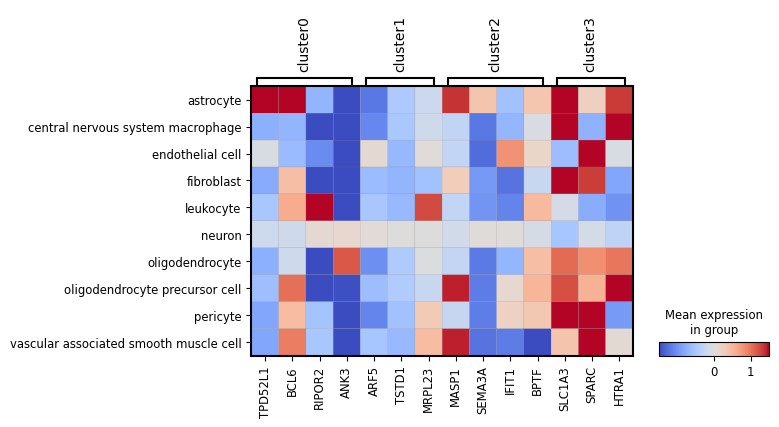

In [153]:
cmap = mpl.cm.coolwarm
norm = mpl.colors.TwoSlopeNorm(vcenter=0, vmax=1.5, vmin=-1.5)
gene_sets_inter = {key: scaled_adata.var_names.intersection(value) for key, value in gene_sets.items()}

sc.pl.matrixplot(scaled_adata, gene_sets_inter, groupby='cell_type', cmap='coolwarm', vcenter=0, vmin=-0.7, vmax=1.5)

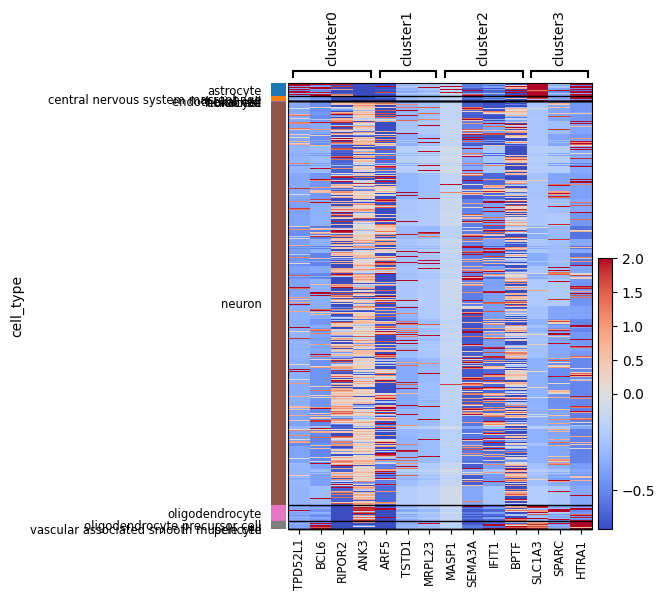

In [154]:
cmap = mpl.cm.coolwarm
norm = mpl.colors.TwoSlopeNorm(vcenter=0, vmax=2, vmin=-2)
gene_sets_inter = {key: scaled_adata.var_names.intersection(value) for key, value in gene_sets.items()}

sc.pl.heatmap(scaled_adata, gene_sets_inter, groupby='cell_type', cmap='coolwarm', vcenter=0, vmin=-0.7, vmax=2)

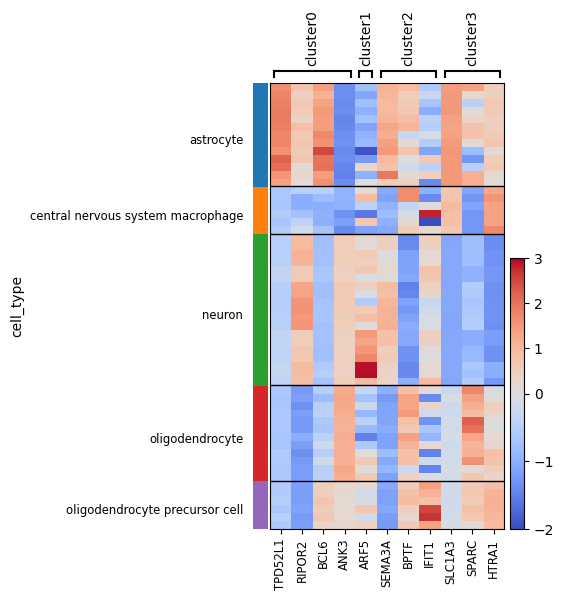

In [155]:
cmap = mpl.cm.coolwarm
norm = mpl.colors.TwoSlopeNorm(vcenter=0)
gene_sets_inter = {key: scaled_adata_pb.var_names.intersection(value) for key, value in gene_sets.items()}

sc.pl.heatmap(scaled_adata_pb, gene_sets_inter, groupby='cell_type', cmap='coolwarm', vcenter=0, vmin=-2, vmax=3)